In [1]:
experiment_setup_name = "wikicat.bizillion_iterations.10s_batch.nesterov"

In [2]:
import sys
sys.path.append("..")

In [3]:
#import everything in the world
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2
import pandas as pd
!mkdir ~/agentnet_snapshots


Couldn't import dot_parser, loading of dot files will not be possible.
mkdir: cannot create directory '/root/agentnet_snapshots': File exists


In [4]:
floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* two layers of GRU memory
* Qvalues predicted via dense layer from both memory layers
* epsilon-greedy decision making
* trained with Nesterov Mommentum SGD

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 393 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [5]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


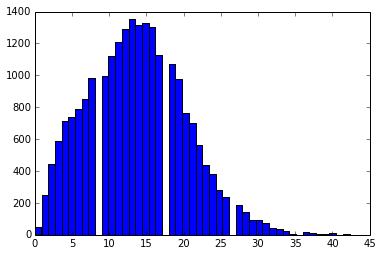

In [6]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [7]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [10]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.99,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 85
контрольная выборка: 8509


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [11]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = _shared("batch_size_scalar",batch_size,'int32')
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1
).astype('float32') #it is highly important to make sure 
        #that variables touched by theano.grad have float* type
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)
        set_shared(self._batch_size,attrs_batch.shape[0])

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
    

    
    def get_first_state(self,batch_size=1):
        return T.zeros_like(self._joint_data,dtype='uint8') 
    
    
    def get_action_results(self,last_state,action,time_i):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,session_states,session_actions,batch_i):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[batch_id, memory_id]: environment state before taking action
            session_actions int[batch_id]: agent action at this tick
        returns:
            reward float[batch_id]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-2,
            _response*2-1
        )
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            0,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [12]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [13]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [14]:
import lasagne
__idea__="""
 
We train two memory states:
    first one, based on observations, and second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.

"""
n_hid_1=128 #first GRU memory
n_hid_2=64 #second GRU memory


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer([None,n_hid_2],name="prev_gru2_state_input")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     _observation_layer,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

concatenated_memory = lasagne.layers.concat([gru1,gru2])

#q_eval
q_eval = lasagne.layers.DenseLayer(concatenated_memory, #taking both memories. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#we need to define the new input map because concatenated_memory is a ConcatLayer and does not have default one

def custom_input_map(last_hidden,observation):
    """just a function that maps memory states to respective inputs"""
    return {
        _prev_gru1_layer:last_hidden[:,0:n_hid_1],
        _prev_gru2_layer:last_hidden[:,n_hid_1:n_hid_1+n_hid_2],
        _observation_layer:observation
    }

#all together
agent = Agent(concatenated_memory,q_eval,resolver,input_map=custom_input_map
             )


In [15]:
history = agent.get_sessions(env,session_length=20,
                       batch_size=env._joint_data.shape[0],
                       initial_env_state=env.get_first_state(env.batch_size))
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [16]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [17]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [18]:
#all weights but for Qvalues prediciton ones (not to penalize q-predictors by l2)
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update]

# целевая функция для обучения сети

* Интуитивно, цель - предсказывать Q-значения (полезности) действий
* $Q(s,a) = R(s,a) + gamma* Max_{a'}{ Q(s',a')}  $
 * R(s,a) - непосредственная награда за действие (+5 если угадал, -1 если нет и т.п.)
 * s' - состояние, в которое агент попал, сделав действие a из состояния s
 * a' - действие, которое можно совершить в состоянии s'
 * gamma - во сколько раз награда/пинок через 1 шаг менее значимы, чем сейчас
 * интуиция - "в состоянии s полезность действия a - это непосредственная печенька за это действие ПЛЮС все печеньки, которые можно собрать, если после этого действия вести себя оптимально"
 
* В реальном мире оптимизируются попарно 2 приближения этой функции
* $ RMSE_{reccurent}: (NN_s(a) - (R + gamma* Max_a'{ NN_s'(a')})^2$
 * NN_s(a) предсказаннная из состояния s полезност Q(s,a)
 * считается для тех NN_s(a), которые агент совершил
 * NN_s'(a') - полезности всех действий сразу после совершения a из состяния s

* $ RMSE_{naive}: (NN_s(a^*) - (R + gamma*  NN_s'(a'^*))^2$
 * аналогично предыдущему, но a* - реально совершённое агентом действие
 * оценка смещена, но куда проще оптимизируется, чем предыдущая
   * по крайней мере, с softmax принятием решений

In [19]:
is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)


ref_tuples = env.get_reference_tuples(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_ids_ravel,immediate_rewards_ravel, predicted_Qvalues_ravel,reference_Qvalues_ravel,is_end_ravel= ref_tuples

from auxilary import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

predicted_Qvalues_for_actions_ravel = predicted_Qvalues_ravel[T.arange(action_ids_ravel.shape[0]),action_ids_ravel]


In [20]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,predicted_Qvalues_for_actions_ravel).mean()

In [21]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [22]:
loss = loss_recurrent + reg_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [24]:
_updates = lasagne.updates.nesterov_momentum(loss,weights,learning_rate=0.01,momentum=0.9)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [26]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation
* удобная [мне одному] функция, которая показывает примеры сессий и внутреннее состояние нейронки
* текстовая часть - 
    * #(номер_действия) (имя_действия) (предсказанное_Qvalue) -> (награда) | следующая итерация
* картинка (если display = True)
    * X - моменты времени, Y - попугаи
    * жЫрные линии - Q-значения категорий
    * тонкие линии - Q-значения узнавания аттрибутов
    * точки на линиях - выбранные действия
    * пунктирные линии - активация нейронов в памяти агента
    * синяя черта (тонкая, вертикальная) - конец сессии (действие или лимит времени)


In [27]:
evaluation_fun = theano.function([],[action_ids_ravel,predicted_Qvalues_for_actions_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [28]:
#new names order
feature_names = list(data_attrs.columns) + list(data_cats.columns) + ["<end_session_action>"]
is_categorical = lambda i: feature_names[i].startswith("category:")

def print_session(n_sessions = 3,display=False,legend=True):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i],linewidth = 1 + 4*is_categorical(i))

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                if legend:
                    plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


# training

In [29]:
def load_random_batch(env,attrs,cats,batch_size=10):
    
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [30]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [31]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.

# само обучение
* шаг алгоритма - 
 * выбрать B случайных людей
 * пересчитать "жадность" алгоритма (чем дальше, тем более жадный)
 * сделать шаг обучения
 * раз в M итераций - добавить точку на график обучения по 3 метрикам
   * ожидание награды за сессию при текущей жадности на тренировочных данных
   * то же самое при максимальной жадности
 * раз в N итераций - 
   * показать несколько примеров сессий на обучающих данных при разной жадности
   * показать графики обучения
* раз в K итераций - записать веса нейронки в файл (snapshot)

Evaluation:

deterministic
#166: decades_active:2000 (4.583) -> 1.0 | #25: last_activity:still_active (4.116) -> 1.0 | #26: decades_active:2010 (3.410) -> 1.0 | #149: Labels:is_known (2.535) -> 1.0 | #260: decades_active:1990 (1.977) -> 1.0 | #1: Birth name:is_known (1.455) -> 1.0 | #247: Website:is_known (1.052) -> 1.0 | #149: Labels:is_known (0.607) -> 0.0 | #1: Birth name:is_known (0.621) -> 0.0 | #149: Labels:is_known (0.620) -> 0.0 | #167: Genres:rock (0.688) -> 1.0 | #3: Instruments:guitar (1.201) -> -1.0 | #393: <end_session_action> (-0.004) -> 0.0 | <end>
true: category:List_of_band_name_etymologies category:List_of_lead_guitarists category:List_of_drummers category:List_of_jazz_fusion_musicians category:List_of_performers_on_Top_of_the_Pops category:List_of_bass_guitarists category:List_of_slide_guitarists


current_greediness (0.950000)
#166: decades_active:2000 (4.583) -> 1.0 | #25: last_activity:still_active (4.116) -> 1.0 | #26: decades_active:2010 (3.410) -> 1.0 | #149: L

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


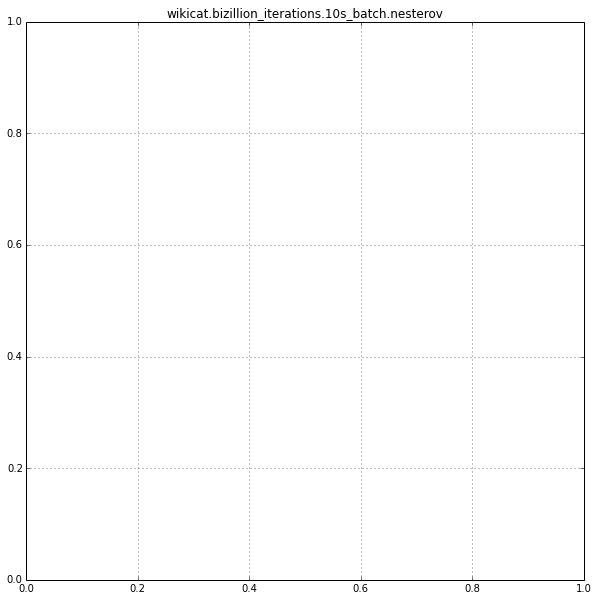

snapshot saved
epoch 250000,loss 0.44434, greed 0.95000, rewards: ( train -1.74000, det_train 0.00000) 
rec 0.443 reg 0.001
epoch 250100,loss 0.64562, greed 0.95000, rewards: ( train 2.46531, det_train 0.42000) 
rec 0.644 reg 0.001
epoch 250200,loss 0.26441, greed 0.95000, rewards: ( train 3.36868, det_train 0.74800) 
rec 0.263 reg 0.001
epoch 250300,loss 0.49276, greed 0.95000, rewards: ( train 3.98984, det_train 1.09320) 
rec 0.492 reg 0.001
epoch 250400,loss 1.15178, greed 0.95000, rewards: ( train 3.87132, det_train 1.53388) 
rec 1.151 reg 0.001
epoch 250500,loss 0.78797, greed 0.95000, rewards: ( train 1.38006, det_train 1.68049) 
rec 0.787 reg 0.001
epoch 250600,loss 0.31536, greed 0.95000, rewards: ( train 1.06073, det_train 1.74244) 
rec 0.314 reg 0.001
epoch 250700,loss 0.57077, greed 0.95000, rewards: ( train 0.97797, det_train 1.68820) 
rec 0.570 reg 0.001
epoch 250800,loss 0.57902, greed 0.95000, rewards: ( train 1.26458, det_train 1.61938) 
rec 0.578 reg 0.001
epoch 250900

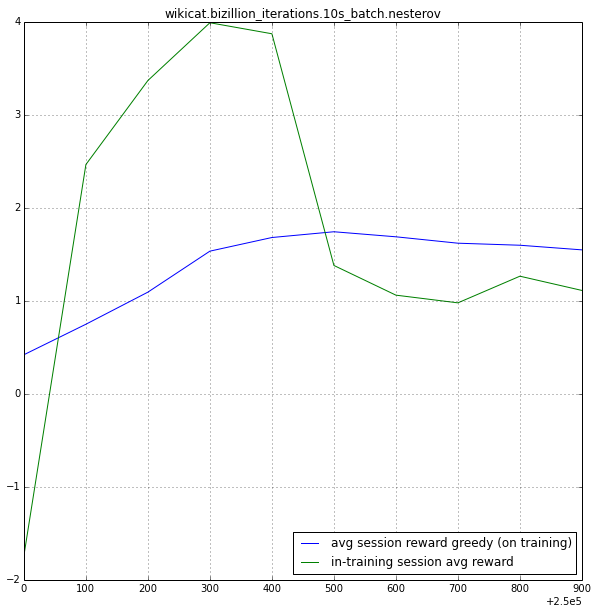

epoch 251000,loss 0.85364, greed 0.95000, rewards: ( train 1.52113, det_train 1.54770) 
rec 0.852 reg 0.001
epoch 251100,loss 0.59806, greed 0.95000, rewards: ( train 1.23887, det_train 1.52293) 
rec 0.597 reg 0.001
epoch 251200,loss 0.32003, greed 0.95000, rewards: ( train 2.35993, det_train 1.57063) 
rec 0.319 reg 0.001
epoch 251300,loss 0.53275, greed 0.95000, rewards: ( train 2.56244, det_train 1.66357) 
rec 0.532 reg 0.001
epoch 251400,loss 0.34320, greed 0.95000, rewards: ( train 3.45733, det_train 1.75721) 
rec 0.342 reg 0.001
epoch 251500,loss 0.65145, greed 0.95000, rewards: ( train 3.18167, det_train 2.00149) 
rec 0.650 reg 0.001
epoch 251600,loss 0.64553, greed 0.95000, rewards: ( train 4.08109, det_train 2.20134) 
rec 0.644 reg 0.001
epoch 251700,loss 0.72598, greed 0.95000, rewards: ( train 3.86196, det_train 2.42121) 
rec 0.725 reg 0.001
epoch 251800,loss 0.62168, greed 0.95000, rewards: ( train 3.65995, det_train 2.47909) 
rec 0.621 reg 0.001
epoch 251900,loss 0.36151, g

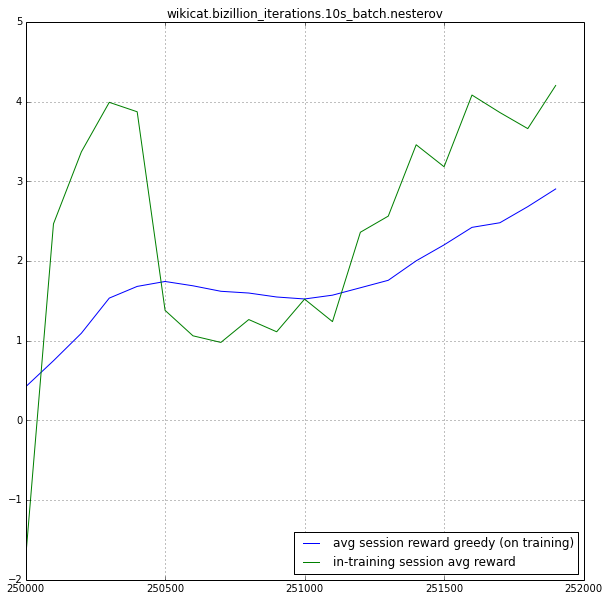

epoch 252000,loss 0.59547, greed 0.95000, rewards: ( train 4.62964, det_train 2.90306) 
rec 0.594 reg 0.001
epoch 252100,loss 0.67156, greed 0.95000, rewards: ( train 3.75081, det_train 3.18276) 
rec 0.670 reg 0.001
epoch 252200,loss 0.73417, greed 0.95000, rewards: ( train 3.85150, det_train 3.30448) 
rec 0.733 reg 0.001
epoch 252300,loss 0.53943, greed 0.95000, rewards: ( train 3.76245, det_train 3.37403) 
rec 0.538 reg 0.001
epoch 252400,loss 0.64189, greed 0.95000, rewards: ( train 3.51166, det_train 3.56663) 
rec 0.641 reg 0.001
epoch 252500,loss 0.47913, greed 0.95000, rewards: ( train 4.15462, det_train 3.55997) 
rec 0.478 reg 0.001
epoch 252600,loss 0.50105, greed 0.95000, rewards: ( train 4.04893, det_train 3.71397) 
rec 0.500 reg 0.001
epoch 252700,loss 0.79308, greed 0.95000, rewards: ( train 4.05703, det_train 3.86257) 
rec 0.792 reg 0.001
epoch 252800,loss 0.47183, greed 0.95000, rewards: ( train 4.28834, det_train 3.91631) 
rec 0.471 reg 0.001
epoch 252900,loss 0.71692, g

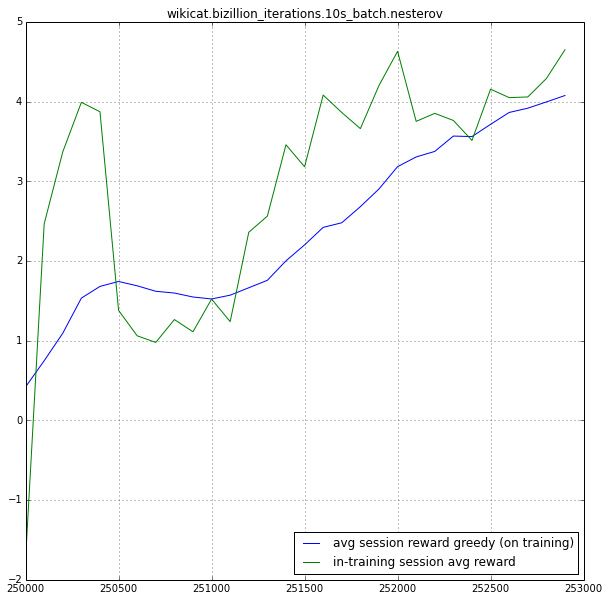

epoch 253000,loss 0.79226, greed 0.95000, rewards: ( train 4.33514, det_train 4.07522) 
rec 0.791 reg 0.001
epoch 253100,loss 0.26680, greed 0.95000, rewards: ( train 4.25679, det_train 4.08769) 
rec 0.266 reg 0.001
epoch 253200,loss 0.75024, greed 0.95000, rewards: ( train 4.31940, det_train 4.18892) 
rec 0.749 reg 0.001
epoch 253300,loss 0.54802, greed 0.95000, rewards: ( train 3.89783, det_train 4.29003) 
rec 0.547 reg 0.001
epoch 253400,loss 0.48289, greed 0.95000, rewards: ( train 4.51358, det_train 4.36103) 
rec 0.482 reg 0.001
epoch 253500,loss 0.68504, greed 0.95000, rewards: ( train 4.67633, det_train 4.29493) 
rec 0.684 reg 0.001
epoch 253600,loss 0.57585, greed 0.95000, rewards: ( train 4.44953, det_train 4.35543) 
rec 0.575 reg 0.001
epoch 253700,loss 0.55973, greed 0.95000, rewards: ( train 4.40241, det_train 4.42989) 
rec 0.559 reg 0.001
epoch 253800,loss 0.60831, greed 0.95000, rewards: ( train 4.31272, det_train 4.50690) 
rec 0.607 reg 0.001
epoch 253900,loss 0.54713, g

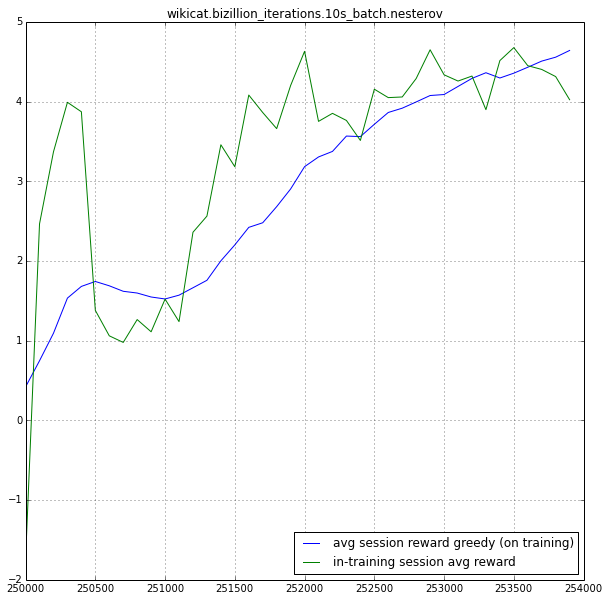

epoch 254000,loss 0.69289, greed 0.95000, rewards: ( train 4.08655, det_train 4.64059) 
rec 0.692 reg 0.001
epoch 254100,loss 0.49758, greed 0.95000, rewards: ( train 4.37344, det_train 4.54653) 
rec 0.496 reg 0.001
epoch 254200,loss 0.60331, greed 0.95000, rewards: ( train 4.44982, det_train 4.62188) 
rec 0.602 reg 0.001
epoch 254300,loss 0.58798, greed 0.95000, rewards: ( train 4.36696, det_train 4.55969) 
rec 0.587 reg 0.001
epoch 254400,loss 0.67231, greed 0.95000, rewards: ( train 4.65752, det_train 4.54372) 
rec 0.671 reg 0.001
epoch 254500,loss 0.92345, greed 0.95000, rewards: ( train 4.63570, det_train 4.60935) 
rec 0.922 reg 0.001
epoch 254600,loss 0.54575, greed 0.95000, rewards: ( train 3.90997, det_train 4.75841) 
rec 0.545 reg 0.001
epoch 254700,loss 0.54640, greed 0.95000, rewards: ( train 4.95875, det_train 4.75257) 
rec 0.545 reg 0.001
epoch 254800,loss 0.55599, greed 0.95000, rewards: ( train 4.58763, det_train 4.85732) 
rec 0.555 reg 0.001
epoch 254900,loss 0.65305, g

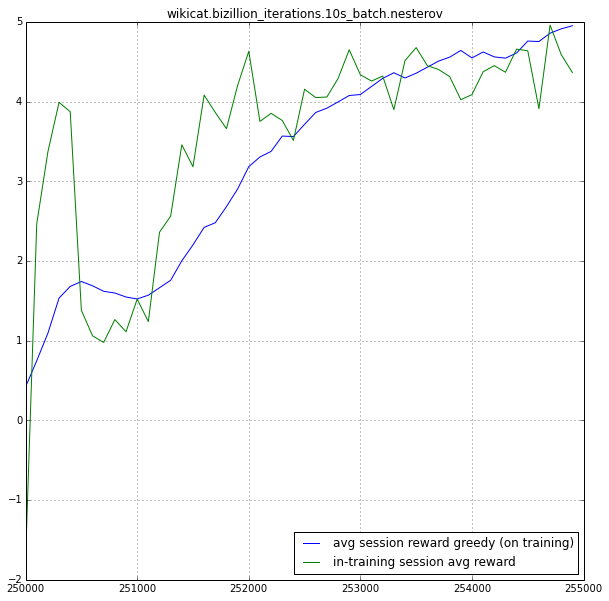

epoch 255000,loss 0.66801, greed 0.95000, rewards: ( train 4.07862, det_train 4.95043) 
rec 0.667 reg 0.001
epoch 255100,loss 0.64562, greed 0.95000, rewards: ( train 4.47532, det_train 4.91538) 
rec 0.644 reg 0.001
epoch 255200,loss 0.52774, greed 0.95000, rewards: ( train 4.00757, det_train 4.97384) 
rec 0.527 reg 0.001
epoch 255300,loss 0.52290, greed 0.95000, rewards: ( train 4.00275, det_train 4.89646) 
rec 0.522 reg 0.001
epoch 255400,loss 0.77102, greed 0.95000, rewards: ( train 4.82188, det_train 4.95681) 
rec 0.770 reg 0.001
epoch 255500,loss 0.75473, greed 0.95000, rewards: ( train 4.28984, det_train 5.18113) 
rec 0.754 reg 0.001
epoch 255600,loss 0.80059, greed 0.95000, rewards: ( train 4.84914, det_train 5.30302) 
rec 0.799 reg 0.001
epoch 255700,loss 0.87895, greed 0.95000, rewards: ( train 4.45375, det_train 5.32272) 
rec 0.878 reg 0.001
epoch 255800,loss 0.82696, greed 0.95000, rewards: ( train 4.76758, det_train 5.18045) 
rec 0.826 reg 0.001
epoch 255900,loss 0.48652, g

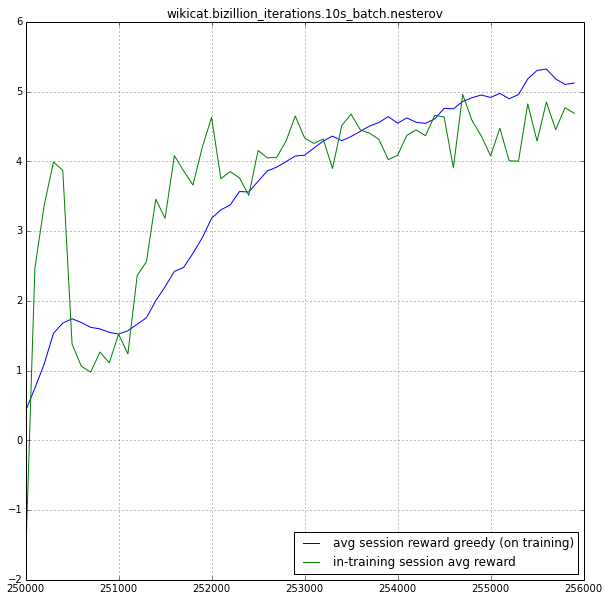

epoch 256000,loss 0.53151, greed 0.95000, rewards: ( train 4.35434, det_train 5.12216) 
rec 0.530 reg 0.001
epoch 256100,loss 0.30762, greed 0.95000, rewards: ( train 4.93462, det_train 5.22994) 
rec 0.306 reg 0.001
epoch 256200,loss 0.80917, greed 0.95000, rewards: ( train 4.43687, det_train 5.37695) 
rec 0.808 reg 0.001
epoch 256300,loss 0.54886, greed 0.95000, rewards: ( train 4.02722, det_train 5.24926) 
rec 0.548 reg 0.001
epoch 256400,loss 0.35562, greed 0.95000, rewards: ( train 4.51837, det_train 5.27433) 
rec 0.354 reg 0.001
epoch 256500,loss 0.81658, greed 0.95000, rewards: ( train 4.21699, det_train 5.33690) 
rec 0.815 reg 0.001
epoch 256600,loss 0.44635, greed 0.95000, rewards: ( train 4.52833, det_train 5.20321) 
rec 0.445 reg 0.001
epoch 256700,loss 0.57401, greed 0.95000, rewards: ( train 4.70608, det_train 5.22289) 
rec 0.573 reg 0.001
epoch 256800,loss 0.74444, greed 0.95000, rewards: ( train 4.49607, det_train 5.24060) 
rec 0.743 reg 0.001
epoch 256900,loss 0.47652, g

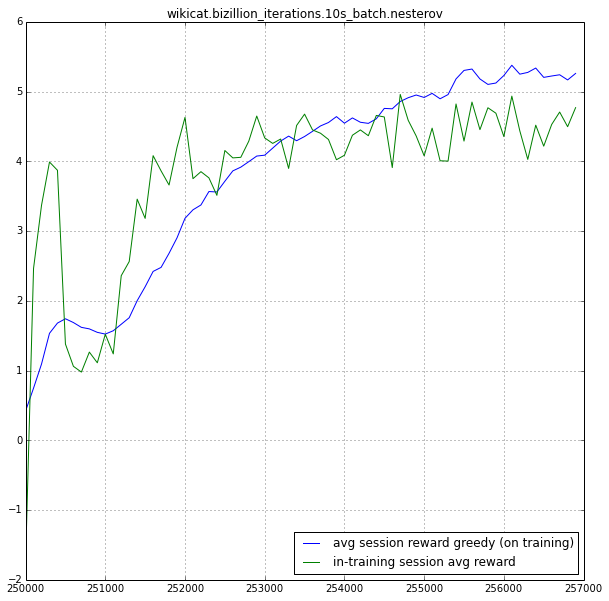

epoch 257000,loss 0.67037, greed 0.95000, rewards: ( train 4.97744, det_train 5.25988) 
rec 0.669 reg 0.001
epoch 257100,loss 0.58034, greed 0.95000, rewards: ( train 4.71383, det_train 5.25390) 
rec 0.579 reg 0.001
epoch 257200,loss 0.78350, greed 0.95000, rewards: ( train 4.90061, det_train 5.29851) 
rec 0.782 reg 0.001
epoch 257300,loss 0.79442, greed 0.95000, rewards: ( train 4.54628, det_train 5.32866) 
rec 0.793 reg 0.001
epoch 257400,loss 0.79907, greed 0.95000, rewards: ( train 4.42783, det_train 5.26579) 
rec 0.798 reg 0.001
epoch 257500,loss 0.62236, greed 0.95000, rewards: ( train 4.89843, det_train 5.29921) 
rec 0.621 reg 0.001
epoch 257600,loss 0.50520, greed 0.95000, rewards: ( train 4.75039, det_train 5.35929) 
rec 0.504 reg 0.001
epoch 257700,loss 0.44920, greed 0.95000, rewards: ( train 4.53660, det_train 5.42336) 
rec 0.448 reg 0.001
epoch 257800,loss 0.42058, greed 0.95000, rewards: ( train 4.36428, det_train 5.45102) 
rec 0.419 reg 0.001
epoch 257900,loss 0.65527, g

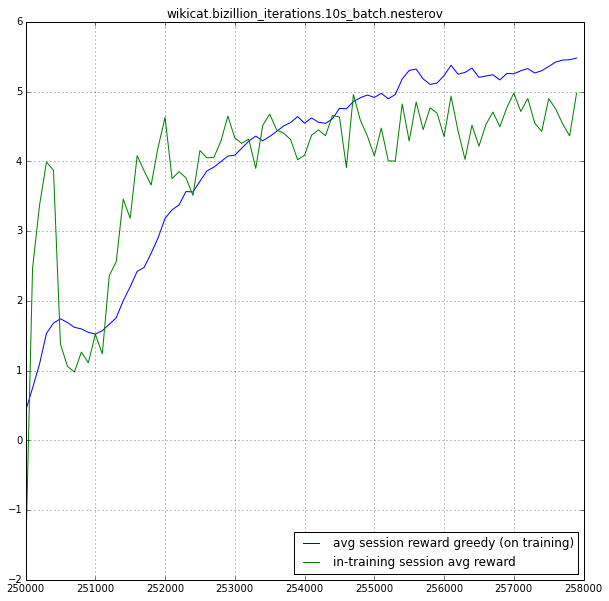

epoch 258000,loss 0.60283, greed 0.95000, rewards: ( train 4.78853, det_train 5.48033) 
rec 0.602 reg 0.001
epoch 258100,loss 0.67088, greed 0.95000, rewards: ( train 4.53033, det_train 5.53230) 
rec 0.670 reg 0.001
epoch 258200,loss 0.83062, greed 0.95000, rewards: ( train 4.10550, det_train 5.51907) 
rec 0.829 reg 0.001
epoch 258300,loss 0.48810, greed 0.95000, rewards: ( train 4.14633, det_train 5.38716) 
rec 0.487 reg 0.001
epoch 258400,loss 0.43839, greed 0.95000, rewards: ( train 4.46494, det_train 5.29844) 
rec 0.437 reg 0.001
epoch 258500,loss 0.53989, greed 0.95000, rewards: ( train 4.42672, det_train 5.23860) 
rec 0.539 reg 0.001
epoch 258600,loss 0.53783, greed 0.95000, rewards: ( train 4.26871, det_train 5.19474) 
rec 0.537 reg 0.001
epoch 258700,loss 0.48632, greed 0.95000, rewards: ( train 4.67396, det_train 5.18527) 
rec 0.485 reg 0.001
epoch 258800,loss 0.36238, greed 0.95000, rewards: ( train 4.72186, det_train 5.19674) 
rec 0.361 reg 0.001
epoch 258900,loss 0.46389, g

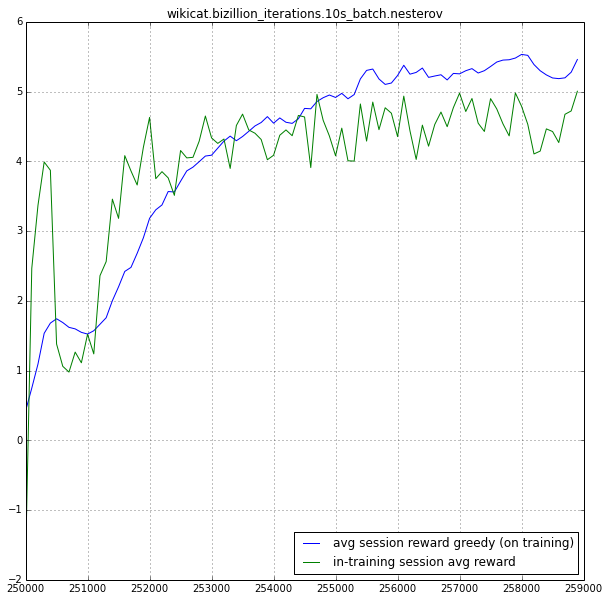

epoch 259000,loss 0.57420, greed 0.95000, rewards: ( train 4.75376, det_train 5.45936) 
rec 0.573 reg 0.001
epoch 259100,loss 0.83148, greed 0.95000, rewards: ( train 4.50040, det_train 5.36342) 
rec 0.830 reg 0.001
epoch 259200,loss 0.36086, greed 0.95000, rewards: ( train 4.69925, det_train 5.31708) 
rec 0.360 reg 0.001
epoch 259300,loss 0.47356, greed 0.95000, rewards: ( train 4.22692, det_train 5.40537) 
rec 0.472 reg 0.001
epoch 259400,loss 0.60243, greed 0.95000, rewards: ( train 4.83301, det_train 5.30484) 
rec 0.601 reg 0.001
epoch 259500,loss 0.54032, greed 0.95000, rewards: ( train 4.26731, det_train 5.33435) 
rec 0.539 reg 0.001
epoch 259600,loss 0.77005, greed 0.95000, rewards: ( train 5.04709, det_train 5.23092) 
rec 0.769 reg 0.001
epoch 259700,loss 0.74205, greed 0.95000, rewards: ( train 4.61753, det_train 5.41783) 
rec 0.741 reg 0.001
epoch 259800,loss 0.34567, greed 0.95000, rewards: ( train 4.29516, det_train 5.30604) 
rec 0.344 reg 0.001
epoch 259900,loss 0.57494, g

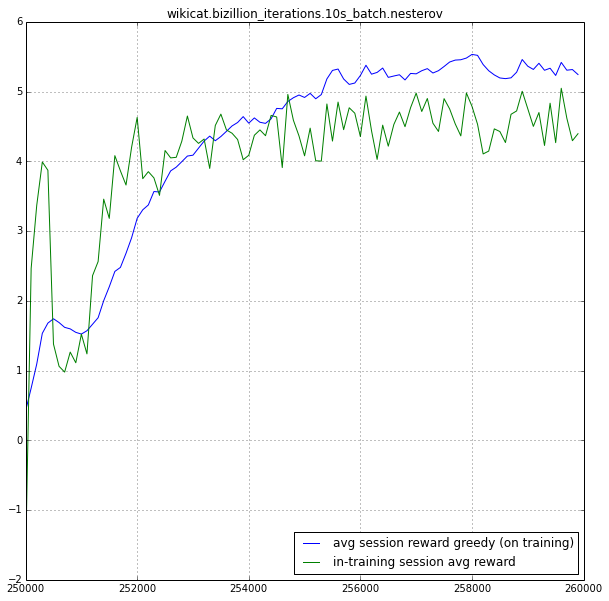

epoch 260000,loss 0.64079, greed 0.95000, rewards: ( train 4.63665, det_train 5.24389) 
rec 0.640 reg 0.001
epoch 260100,loss 0.71334, greed 0.95000, rewards: ( train 4.76312, det_train 5.24951) 
rec 0.712 reg 0.001
epoch 260200,loss 0.68142, greed 0.95000, rewards: ( train 4.09081, det_train 5.15455) 
rec 0.680 reg 0.001
epoch 260300,loss 0.51946, greed 0.95000, rewards: ( train 3.89698, det_train 5.00910) 
rec 0.518 reg 0.001
epoch 260400,loss 0.21195, greed 0.95000, rewards: ( train 4.46074, det_train 4.96819) 
rec 0.211 reg 0.001
epoch 260500,loss 0.48547, greed 0.95000, rewards: ( train 4.93581, det_train 5.09137) 
rec 0.484 reg 0.001
epoch 260600,loss 0.65158, greed 0.95000, rewards: ( train 5.12237, det_train 5.17223) 
rec 0.650 reg 0.001
epoch 260700,loss 0.58231, greed 0.95000, rewards: ( train 4.72215, det_train 5.24501) 
rec 0.581 reg 0.001
epoch 260800,loss 0.57716, greed 0.95000, rewards: ( train 4.77037, det_train 5.30051) 
rec 0.576 reg 0.001
epoch 260900,loss 0.52379, g

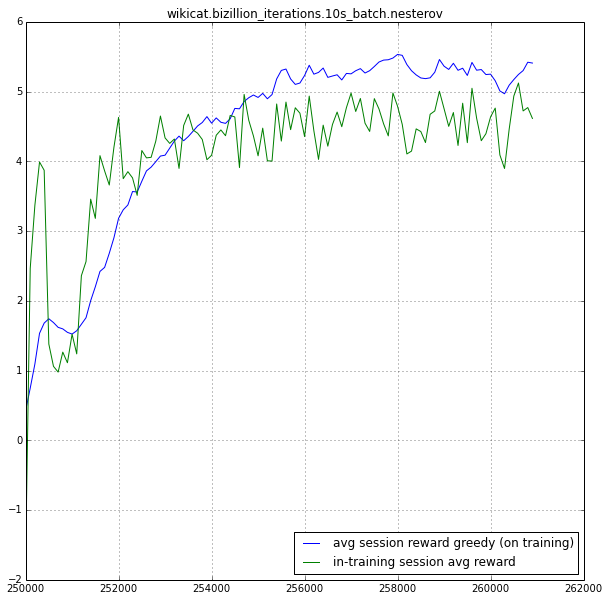

epoch 261000,loss 0.62214, greed 0.95000, rewards: ( train 4.61748, det_train 5.40841) 
rec 0.621 reg 0.001
epoch 261100,loss 0.44679, greed 0.95000, rewards: ( train 4.70779, det_train 5.31757) 
rec 0.446 reg 0.001
epoch 261200,loss 0.57358, greed 0.95000, rewards: ( train 4.86600, det_train 5.36581) 
rec 0.572 reg 0.001
epoch 261300,loss 0.51822, greed 0.95000, rewards: ( train 4.88879, det_train 5.36923) 
rec 0.517 reg 0.001
epoch 261400,loss 0.57573, greed 0.95000, rewards: ( train 4.79221, det_train 5.43231) 
rec 0.575 reg 0.001
epoch 261500,loss 0.56742, greed 0.95000, rewards: ( train 4.91432, det_train 5.45908) 
rec 0.566 reg 0.001
epoch 261600,loss 0.57157, greed 0.95000, rewards: ( train 4.74591, det_train 5.45317) 
rec 0.570 reg 0.001
epoch 261700,loss 0.38725, greed 0.95000, rewards: ( train 4.82901, det_train 5.56785) 
rec 0.386 reg 0.001
epoch 261800,loss 0.57629, greed 0.95000, rewards: ( train 5.01994, det_train 5.68107) 
rec 0.575 reg 0.001
epoch 261900,loss 0.49617, g

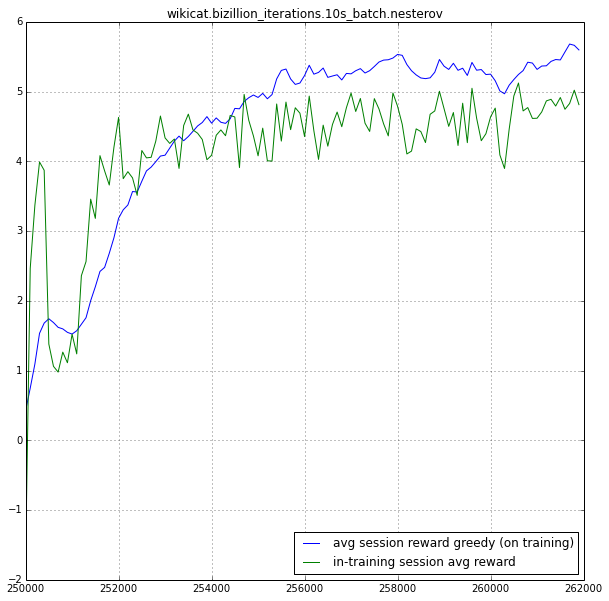

epoch 262000,loss 0.54035, greed 0.95000, rewards: ( train 4.41392, det_train 5.59667) 
rec 0.539 reg 0.001
epoch 262100,loss 0.61293, greed 0.95000, rewards: ( train 5.04374, det_train 5.59700) 
rec 0.612 reg 0.001
epoch 262200,loss 0.70237, greed 0.95000, rewards: ( train 4.70355, det_train 5.74730) 
rec 0.701 reg 0.001
epoch 262300,loss 0.70302, greed 0.95000, rewards: ( train 4.61105, det_train 5.65257) 
rec 0.702 reg 0.001
epoch 262400,loss 0.62535, greed 0.95000, rewards: ( train 4.73763, det_train 5.52731) 
rec 0.624 reg 0.001
epoch 262500,loss 0.54329, greed 0.95000, rewards: ( train 4.98698, det_train 5.44458) 
rec 0.542 reg 0.001
epoch 262600,loss 0.51323, greed 0.95000, rewards: ( train 4.63258, det_train 5.47012) 
rec 0.512 reg 0.001
epoch 262700,loss 0.62281, greed 0.95000, rewards: ( train 4.70009, det_train 5.56311) 
rec 0.622 reg 0.001
epoch 262800,loss 0.37746, greed 0.95000, rewards: ( train 4.92885, det_train 5.62680) 
rec 0.376 reg 0.001
epoch 262900,loss 0.56287, g

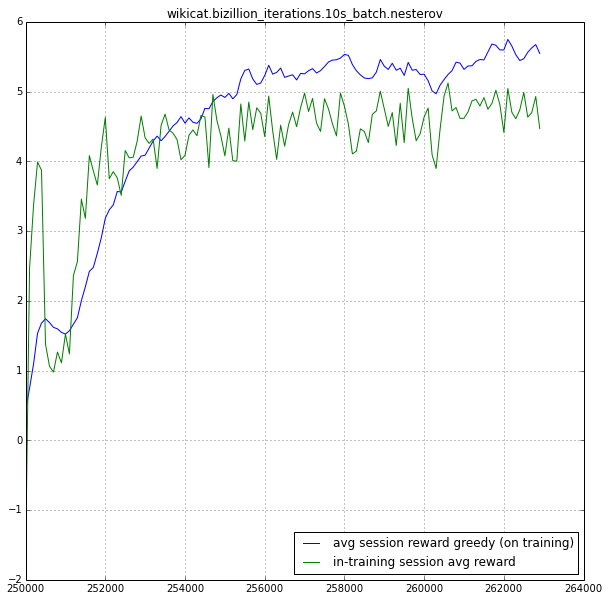

epoch 263000,loss 0.31924, greed 0.95000, rewards: ( train 4.41604, det_train 5.54671) 
rec 0.318 reg 0.001
epoch 263100,loss 0.34784, greed 0.95000, rewards: ( train 4.44321, det_train 5.56204) 
rec 0.347 reg 0.001
epoch 263200,loss 0.44322, greed 0.95000, rewards: ( train 4.59730, det_train 5.53583) 
rec 0.442 reg 0.001
epoch 263300,loss 0.50811, greed 0.95000, rewards: ( train 4.73650, det_train 5.54225) 
rec 0.507 reg 0.001
epoch 263400,loss 0.48284, greed 0.95000, rewards: ( train 4.75385, det_train 5.59802) 
rec 0.482 reg 0.001
epoch 263500,loss 0.69790, greed 0.95000, rewards: ( train 4.92431, det_train 5.50822) 
rec 0.697 reg 0.001
epoch 263600,loss 0.55878, greed 0.95000, rewards: ( train 4.58084, det_train 5.43740) 
rec 0.558 reg 0.001
epoch 263700,loss 0.67924, greed 0.95000, rewards: ( train 4.47811, det_train 5.35366) 
rec 0.678 reg 0.001
epoch 263800,loss 0.46102, greed 0.95000, rewards: ( train 4.91910, det_train 5.23829) 
rec 0.460 reg 0.001
epoch 263900,loss 0.76624, g

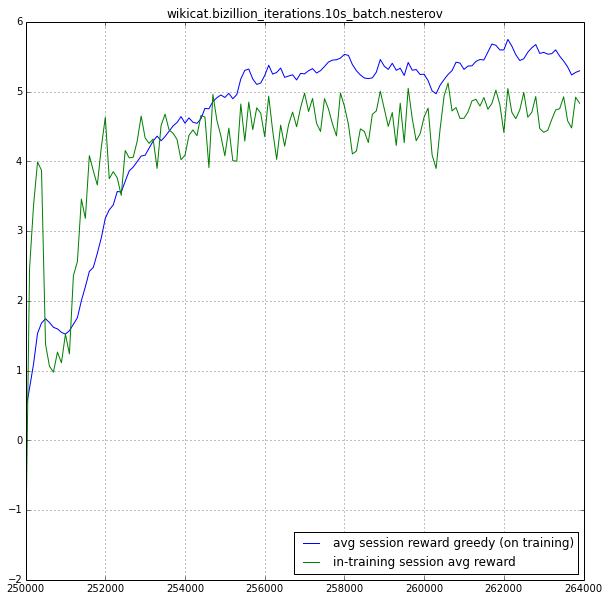

epoch 264000,loss 0.47068, greed 0.95000, rewards: ( train 4.53165, det_train 5.29702) 
rec 0.469 reg 0.001
epoch 264100,loss 0.81950, greed 0.95000, rewards: ( train 4.58406, det_train 5.26732) 
rec 0.818 reg 0.001
epoch 264200,loss 0.70303, greed 0.95000, rewards: ( train 4.67097, det_train 5.21058) 
rec 0.702 reg 0.001
epoch 264300,loss 0.55727, greed 0.95000, rewards: ( train 4.86079, det_train 5.15953) 
rec 0.556 reg 0.001
epoch 264400,loss 0.54976, greed 0.95000, rewards: ( train 4.72144, det_train 5.16357) 
rec 0.549 reg 0.001
epoch 264500,loss 0.83765, greed 0.95000, rewards: ( train 4.84152, det_train 5.24722) 
rec 0.836 reg 0.001
epoch 264600,loss 0.52262, greed 0.95000, rewards: ( train 4.52004, det_train 5.17249) 
rec 0.521 reg 0.001
epoch 264700,loss 0.55909, greed 0.95000, rewards: ( train 4.65047, det_train 5.18525) 
rec 0.558 reg 0.001
epoch 264800,loss 0.33289, greed 0.95000, rewards: ( train 4.89765, det_train 5.12672) 
rec 0.332 reg 0.001
epoch 264900,loss 0.37217, g

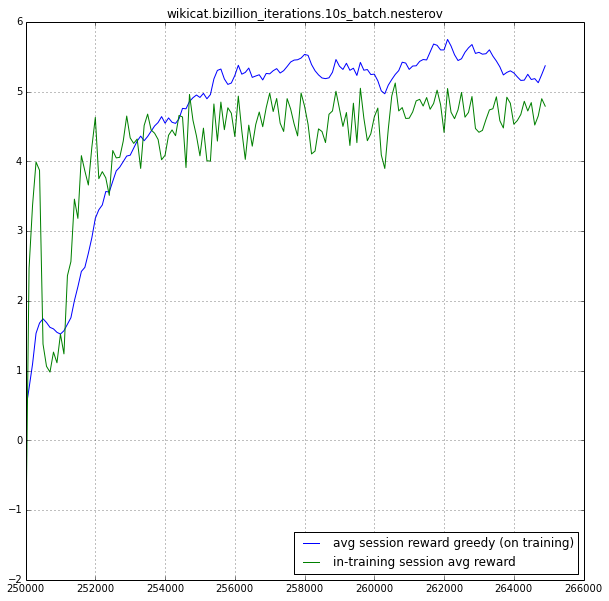

epoch 265000,loss 0.40521, greed 0.95000, rewards: ( train 4.76961, det_train 5.36964) 
rec 0.404 reg 0.001
epoch 265100,loss 0.61998, greed 0.95000, rewards: ( train 4.77876, det_train 5.44268) 
rec 0.619 reg 0.001
epoch 265200,loss 0.87999, greed 0.95000, rewards: ( train 4.74221, det_train 5.47841) 
rec 0.879 reg 0.001
epoch 265300,loss 0.50412, greed 0.95000, rewards: ( train 4.87254, det_train 5.39057) 
rec 0.503 reg 0.001
epoch 265400,loss 0.58495, greed 0.95000, rewards: ( train 4.63276, det_train 5.54151) 
rec 0.584 reg 0.001
epoch 265500,loss 0.46371, greed 0.95000, rewards: ( train 5.04820, det_train 5.51736) 
rec 0.463 reg 0.001
epoch 265600,loss 0.53772, greed 0.95000, rewards: ( train 4.49644, det_train 5.56563) 
rec 0.537 reg 0.001
epoch 265700,loss 0.62473, greed 0.95000, rewards: ( train 4.84472, det_train 5.46906) 
rec 0.624 reg 0.001
epoch 265800,loss 0.58188, greed 0.95000, rewards: ( train 5.01157, det_train 5.53216) 
rec 0.581 reg 0.001
epoch 265900,loss 0.75349, g

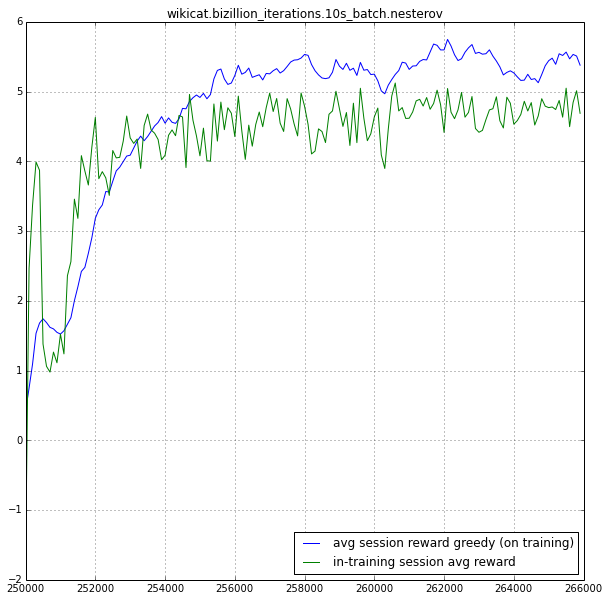

epoch 266000,loss 0.64258, greed 0.95000, rewards: ( train 4.94399, det_train 5.37805) 
rec 0.641 reg 0.001
epoch 266100,loss 0.55641, greed 0.95000, rewards: ( train 5.03520, det_train 5.32024) 
rec 0.555 reg 0.001
epoch 266200,loss 0.62783, greed 0.95000, rewards: ( train 4.50922, det_train 5.32822) 
rec 0.627 reg 0.001
epoch 266300,loss 0.69327, greed 0.95000, rewards: ( train 4.99381, det_train 5.28540) 
rec 0.692 reg 0.001
epoch 266400,loss 0.71263, greed 0.95000, rewards: ( train 4.61364, det_train 5.24686) 
rec 0.711 reg 0.001
epoch 266500,loss 0.71268, greed 0.95000, rewards: ( train 4.87772, det_train 5.24217) 
rec 0.711 reg 0.001
epoch 266600,loss 0.55501, greed 0.95000, rewards: ( train 4.35842, det_train 5.21795) 
rec 0.554 reg 0.001
epoch 266700,loss 0.70165, greed 0.95000, rewards: ( train 4.72594, det_train 5.21616) 
rec 0.700 reg 0.001
epoch 266800,loss 0.59664, greed 0.95000, rewards: ( train 4.88269, det_train 5.16454) 
rec 0.595 reg 0.001
epoch 266900,loss 0.69193, g

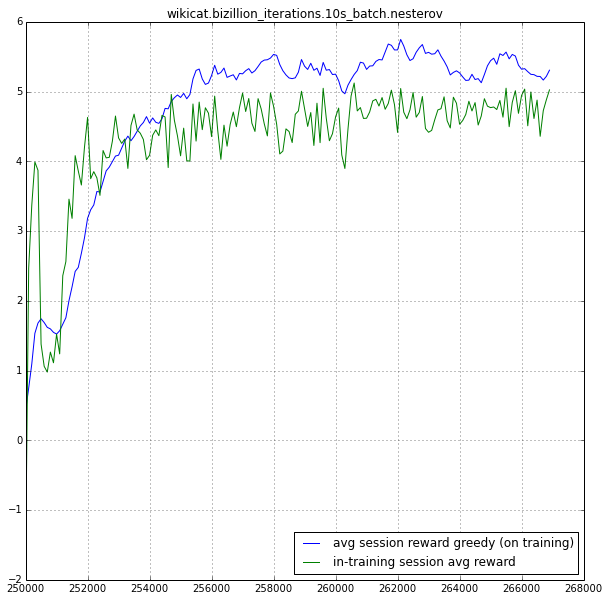

epoch 267000,loss 0.67546, greed 0.95000, rewards: ( train 5.07682, det_train 5.30628) 
rec 0.674 reg 0.001
epoch 267100,loss 0.40431, greed 0.95000, rewards: ( train 4.26610, det_train 5.27565) 
rec 0.403 reg 0.001
epoch 267200,loss 0.75403, greed 0.95000, rewards: ( train 4.84640, det_train 5.23809) 
rec 0.753 reg 0.001
epoch 267300,loss 0.80241, greed 0.95000, rewards: ( train 5.16317, det_train 5.24428) 
rec 0.801 reg 0.001
epoch 267400,loss 0.57411, greed 0.95000, rewards: ( train 4.74482, det_train 5.26985) 
rec 0.573 reg 0.001
epoch 267500,loss 0.59033, greed 0.95000, rewards: ( train 4.61509, det_train 5.28287) 
rec 0.589 reg 0.001
epoch 267600,loss 0.54151, greed 0.95000, rewards: ( train 4.73674, det_train 5.16458) 
rec 0.540 reg 0.001
epoch 267700,loss 0.57143, greed 0.95000, rewards: ( train 4.42447, det_train 5.22812) 
rec 0.570 reg 0.001
epoch 267800,loss 0.58739, greed 0.95000, rewards: ( train 5.18205, det_train 5.20531) 
rec 0.586 reg 0.001
epoch 267900,loss 0.69588, g

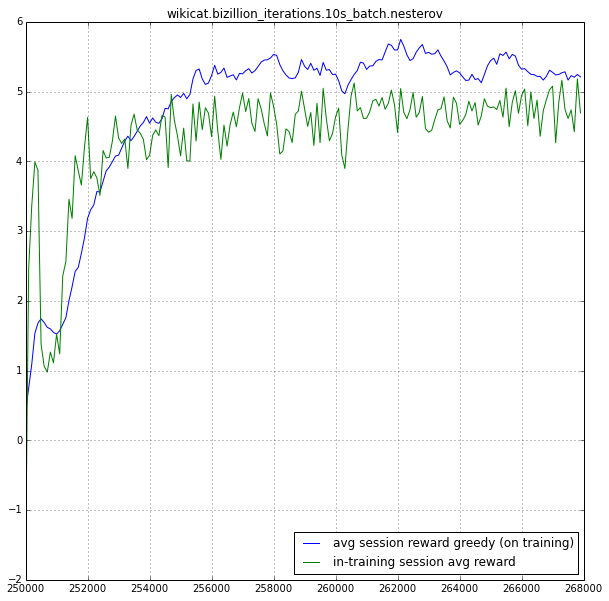

epoch 268000,loss 0.63919, greed 0.95000, rewards: ( train 5.02383, det_train 5.21030) 
rec 0.638 reg 0.001
epoch 268100,loss 0.64723, greed 0.95000, rewards: ( train 4.89113, det_train 5.24927) 
rec 0.646 reg 0.001
epoch 268200,loss 0.46895, greed 0.95000, rewards: ( train 4.81160, det_train 5.31434) 
rec 0.468 reg 0.001
epoch 268300,loss 0.57864, greed 0.95000, rewards: ( train 4.74027, det_train 5.35291) 
rec 0.577 reg 0.001
epoch 268400,loss 0.50283, greed 0.95000, rewards: ( train 5.13103, det_train 5.38762) 
rec 0.502 reg 0.001
epoch 268500,loss 0.68746, greed 0.95000, rewards: ( train 5.06049, det_train 5.36886) 
rec 0.686 reg 0.001
epoch 268600,loss 0.65712, greed 0.95000, rewards: ( train 5.00376, det_train 5.31197) 
rec 0.656 reg 0.001
epoch 268700,loss 0.59176, greed 0.95000, rewards: ( train 5.23039, det_train 5.33077) 
rec 0.591 reg 0.001
epoch 268800,loss 0.54383, greed 0.95000, rewards: ( train 4.84011, det_train 5.42770) 
rec 0.543 reg 0.001
epoch 268900,loss 0.91876, g

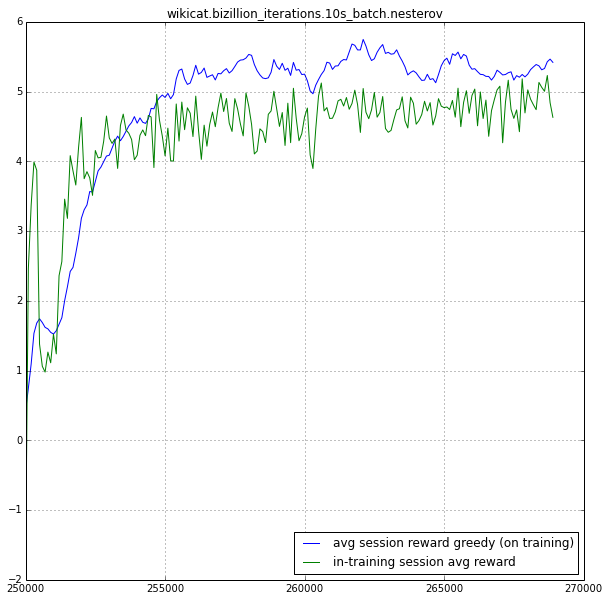

epoch 269000,loss 0.52048, greed 0.95000, rewards: ( train 4.90466, det_train 5.41843) 
rec 0.519 reg 0.001
epoch 269100,loss 0.54530, greed 0.95000, rewards: ( train 4.99595, det_train 5.46659) 
rec 0.544 reg 0.001
epoch 269200,loss 0.90186, greed 0.95000, rewards: ( train 5.25437, det_train 5.49993) 
rec 0.901 reg 0.001
epoch 269300,loss 0.47586, greed 0.95000, rewards: ( train 5.24496, det_train 5.36994) 
rec 0.475 reg 0.001
epoch 269400,loss 0.95206, greed 0.95000, rewards: ( train 5.10960, det_train 5.57294) 
rec 0.951 reg 0.001
epoch 269500,loss 0.58879, greed 0.95000, rewards: ( train 4.89390, det_train 5.35565) 
rec 0.588 reg 0.001
epoch 269600,loss 0.75097, greed 0.95000, rewards: ( train 5.21164, det_train 5.39008) 
rec 0.750 reg 0.001
epoch 269700,loss 0.53261, greed 0.95000, rewards: ( train 4.97960, det_train 5.33108) 
rec 0.531 reg 0.001
epoch 269800,loss 0.82278, greed 0.95000, rewards: ( train 4.92290, det_train 5.45797) 
rec 0.822 reg 0.001
epoch 269900,loss 0.92689, g

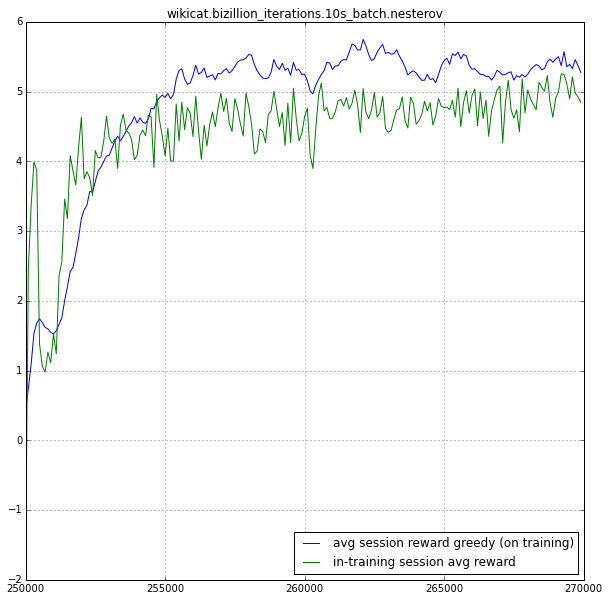

epoch 270000,loss 0.49675, greed 0.95000, rewards: ( train 4.90837, det_train 5.27495) 
rec 0.496 reg 0.001
epoch 270100,loss 0.92404, greed 0.95000, rewards: ( train 5.00709, det_train 5.33746) 
rec 0.923 reg 0.001
epoch 270200,loss 0.58718, greed 0.95000, rewards: ( train 4.89331, det_train 5.24371) 
rec 0.586 reg 0.001
epoch 270300,loss 0.62032, greed 0.95000, rewards: ( train 4.83027, det_train 5.37934) 
rec 0.619 reg 0.001
epoch 270400,loss 0.67970, greed 0.95000, rewards: ( train 5.25548, det_train 5.38141) 
rec 0.678 reg 0.001
epoch 270500,loss 0.62417, greed 0.95000, rewards: ( train 5.02947, det_train 5.50327) 
rec 0.623 reg 0.001
epoch 270600,loss 0.63461, greed 0.95000, rewards: ( train 4.82792, det_train 5.52294) 
rec 0.633 reg 0.001
epoch 270700,loss 0.69563, greed 0.95000, rewards: ( train 4.69651, det_train 5.47065) 
rec 0.694 reg 0.001
epoch 270800,loss 0.69180, greed 0.95000, rewards: ( train 5.11275, det_train 5.57358) 
rec 0.691 reg 0.001
epoch 270900,loss 0.58478, g

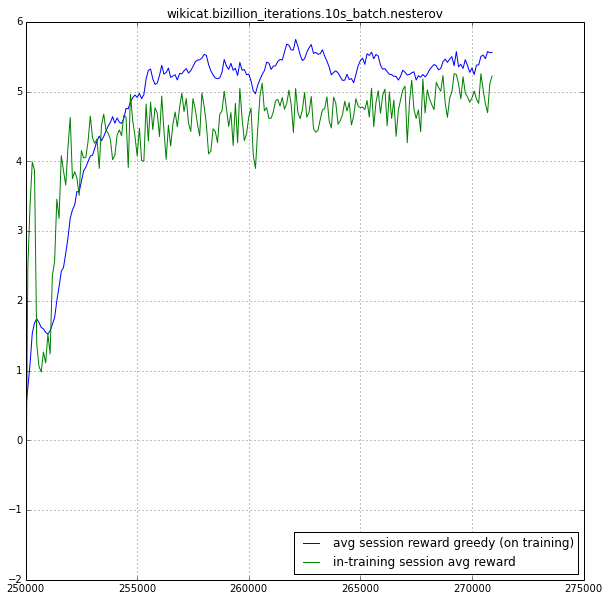

epoch 271000,loss 0.62446, greed 0.95000, rewards: ( train 4.98232, det_train 5.56060) 
rec 0.623 reg 0.001
epoch 271100,loss 0.45782, greed 0.95000, rewards: ( train 4.71944, det_train 5.57454) 
rec 0.457 reg 0.001
epoch 271200,loss 0.58139, greed 0.95000, rewards: ( train 4.66183, det_train 5.71709) 
rec 0.580 reg 0.001
epoch 271300,loss 0.62215, greed 0.95000, rewards: ( train 4.93038, det_train 5.64538) 
rec 0.621 reg 0.001
epoch 271400,loss 0.54590, greed 0.95000, rewards: ( train 5.09829, det_train 5.60084) 
rec 0.545 reg 0.001
epoch 271500,loss 0.52552, greed 0.95000, rewards: ( train 4.78132, det_train 5.66076) 
rec 0.524 reg 0.001
epoch 271600,loss 0.57184, greed 0.95000, rewards: ( train 5.17696, det_train 5.62468) 
rec 0.571 reg 0.001
epoch 271700,loss 0.62819, greed 0.95000, rewards: ( train 4.81321, det_train 5.71221) 
rec 0.627 reg 0.001
epoch 271800,loss 0.63013, greed 0.95000, rewards: ( train 5.16639, det_train 5.64099) 
rec 0.629 reg 0.001
epoch 271900,loss 0.50883, g

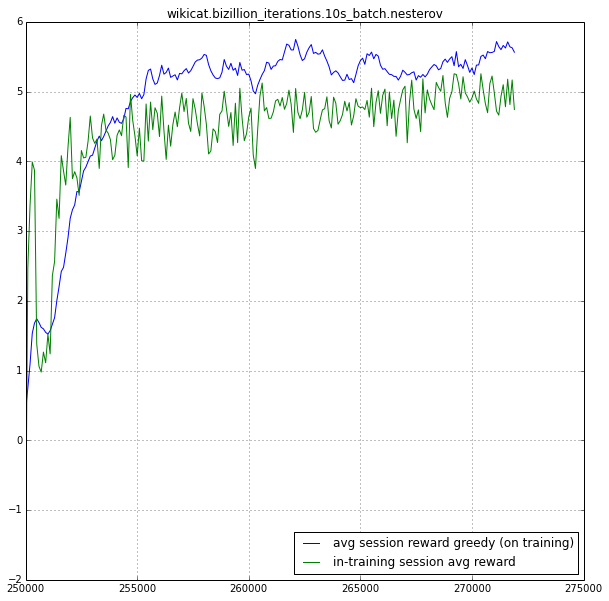

epoch 272000,loss 0.48677, greed 0.95000, rewards: ( train 4.93498, det_train 5.56420) 
rec 0.486 reg 0.001
epoch 272100,loss 0.57961, greed 0.95000, rewards: ( train 4.57905, det_train 5.64778) 
rec 0.578 reg 0.001
epoch 272200,loss 0.74669, greed 0.95000, rewards: ( train 4.88496, det_train 5.62300) 
rec 0.745 reg 0.001
epoch 272300,loss 0.65987, greed 0.95000, rewards: ( train 4.72124, det_train 5.57070) 
rec 0.659 reg 0.001
epoch 272400,loss 0.91130, greed 0.95000, rewards: ( train 4.92180, det_train 5.49363) 
rec 0.910 reg 0.001
epoch 272500,loss 0.49119, greed 0.95000, rewards: ( train 5.14196, det_train 5.30427) 
rec 0.490 reg 0.001
epoch 272600,loss 0.39144, greed 0.95000, rewards: ( train 4.85693, det_train 5.33384) 
rec 0.390 reg 0.001
epoch 272700,loss 0.61854, greed 0.95000, rewards: ( train 4.96925, det_train 5.41046) 
rec 0.617 reg 0.001
epoch 272800,loss 0.35685, greed 0.95000, rewards: ( train 4.81387, det_train 5.42941) 
rec 0.356 reg 0.001
epoch 272900,loss 0.37052, g

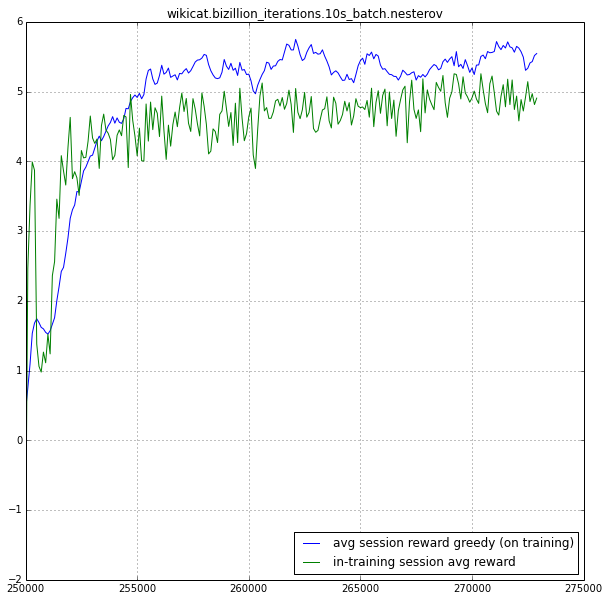

epoch 273000,loss 0.45801, greed 0.95000, rewards: ( train 4.92350, det_train 5.54482) 
rec 0.457 reg 0.001
epoch 273100,loss 0.47062, greed 0.95000, rewards: ( train 4.94116, det_train 5.61034) 
rec 0.469 reg 0.001
epoch 273200,loss 0.47483, greed 0.95000, rewards: ( train 5.10340, det_train 5.56931) 
rec 0.474 reg 0.001
epoch 273300,loss 0.61719, greed 0.95000, rewards: ( train 4.82268, det_train 5.62238) 
rec 0.616 reg 0.001
epoch 273400,loss 0.83266, greed 0.95000, rewards: ( train 4.75776, det_train 5.52014) 
rec 0.831 reg 0.001
epoch 273500,loss 0.70470, greed 0.95000, rewards: ( train 5.05785, det_train 5.38813) 
rec 0.703 reg 0.001
epoch 273600,loss 0.40257, greed 0.95000, rewards: ( train 5.05195, det_train 5.36931) 
rec 0.401 reg 0.001
epoch 273700,loss 0.46096, greed 0.95000, rewards: ( train 4.62252, det_train 5.44238) 
rec 0.460 reg 0.001
epoch 273800,loss 0.37815, greed 0.95000, rewards: ( train 4.76101, det_train 5.42814) 
rec 0.377 reg 0.001
epoch 273900,loss 0.62000, g

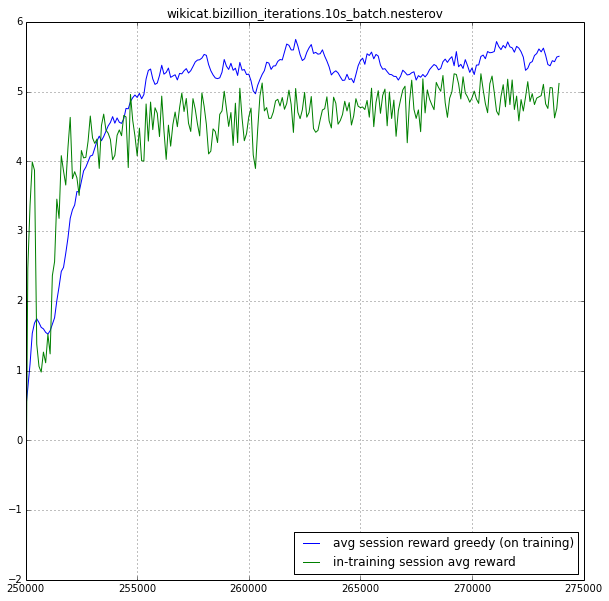

epoch 274000,loss 0.50579, greed 0.95000, rewards: ( train 5.15961, det_train 5.50580) 
rec 0.505 reg 0.001
epoch 274100,loss 0.47651, greed 0.95000, rewards: ( train 5.27966, det_train 5.58522) 
rec 0.475 reg 0.001
epoch 274200,loss 0.54142, greed 0.95000, rewards: ( train 5.29647, det_train 5.62669) 
rec 0.540 reg 0.001
epoch 274300,loss 0.54465, greed 0.95000, rewards: ( train 4.68592, det_train 5.71403) 
rec 0.543 reg 0.001
epoch 274400,loss 0.60625, greed 0.95000, rewards: ( train 4.83850, det_train 5.62262) 
rec 0.605 reg 0.001
epoch 274500,loss 0.56440, greed 0.95000, rewards: ( train 5.33786, det_train 5.64036) 
rec 0.563 reg 0.001
epoch 274600,loss 0.45577, greed 0.95000, rewards: ( train 5.35776, det_train 5.74632) 
rec 0.455 reg 0.001
epoch 274700,loss 0.59351, greed 0.95000, rewards: ( train 5.02718, det_train 5.75169) 
rec 0.592 reg 0.001
epoch 274800,loss 0.59626, greed 0.95000, rewards: ( train 4.69139, det_train 5.70652) 
rec 0.595 reg 0.001
epoch 274900,loss 0.55108, g

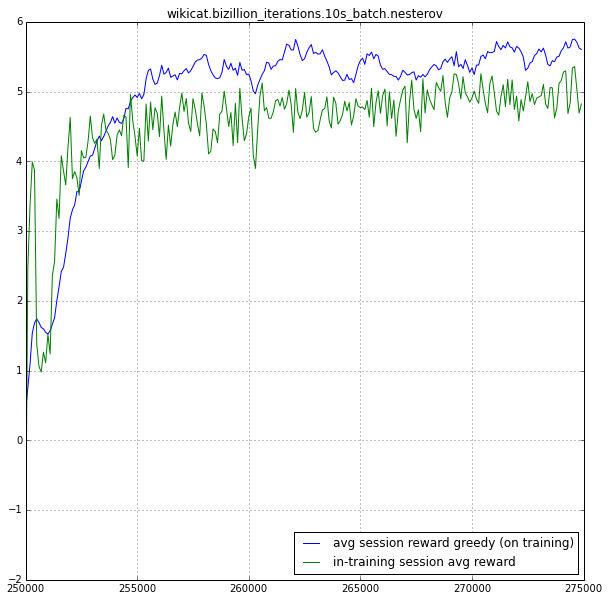

snapshot saved
epoch 275000,loss 0.50214, greed 0.95000, rewards: ( train 4.73114, det_train 5.60328) 
rec 0.501 reg 0.001
epoch 275100,loss 0.74698, greed 0.95000, rewards: ( train 5.10950, det_train 5.51296) 
rec 0.746 reg 0.001
epoch 275200,loss 0.51049, greed 0.95000, rewards: ( train 5.42419, det_train 5.49166) 
rec 0.509 reg 0.001
epoch 275300,loss 0.75819, greed 0.95000, rewards: ( train 4.75132, det_train 5.54249) 
rec 0.757 reg 0.001
epoch 275400,loss 0.67455, greed 0.95000, rewards: ( train 4.79311, det_train 5.45824) 
rec 0.673 reg 0.001
epoch 275500,loss 0.90776, greed 0.95000, rewards: ( train 5.26668, det_train 5.42242) 
rec 0.907 reg 0.001
epoch 275600,loss 0.61674, greed 0.95000, rewards: ( train 4.34872, det_train 5.36018) 
rec 0.616 reg 0.001
epoch 275700,loss 0.53334, greed 0.95000, rewards: ( train 4.72611, det_train 5.37416) 
rec 0.532 reg 0.001
epoch 275800,loss 0.72033, greed 0.95000, rewards: ( train 4.99500, det_train 5.31674) 
rec 0.719 reg 0.001
epoch 275900,

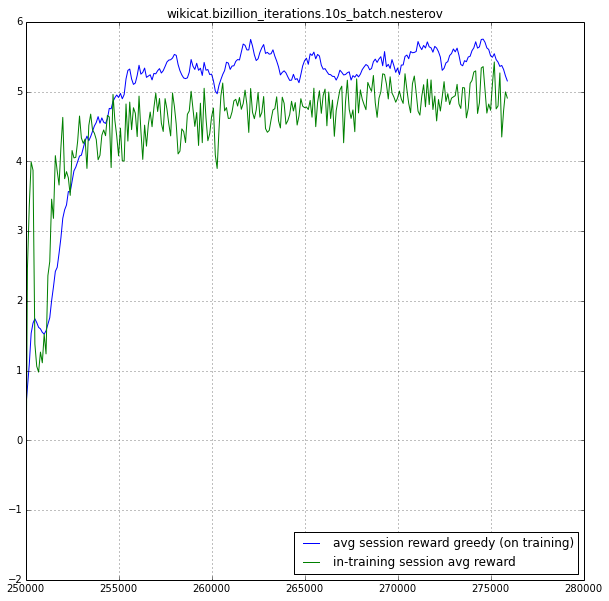

epoch 276000,loss 0.72502, greed 0.95000, rewards: ( train 5.22152, det_train 5.15256) 
rec 0.724 reg 0.001
epoch 276100,loss 0.49461, greed 0.95000, rewards: ( train 5.12475, det_train 5.23731) 
rec 0.493 reg 0.001
epoch 276200,loss 0.68814, greed 0.95000, rewards: ( train 4.89551, det_train 5.42358) 
rec 0.687 reg 0.001
epoch 276300,loss 0.59952, greed 0.95000, rewards: ( train 4.88206, det_train 5.41122) 
rec 0.598 reg 0.001
epoch 276400,loss 0.82364, greed 0.95000, rewards: ( train 4.48611, det_train 5.42010) 
rec 0.822 reg 0.001
epoch 276500,loss 0.59720, greed 0.95000, rewards: ( train 5.30102, det_train 5.28809) 
rec 0.596 reg 0.001
epoch 276600,loss 0.51651, greed 0.95000, rewards: ( train 5.05130, det_train 5.35928) 
rec 0.515 reg 0.001
epoch 276700,loss 0.39590, greed 0.95000, rewards: ( train 4.75165, det_train 5.49335) 
rec 0.395 reg 0.001
epoch 276800,loss 0.53215, greed 0.95000, rewards: ( train 4.93212, det_train 5.59402) 
rec 0.531 reg 0.001
epoch 276900,loss 0.58321, g

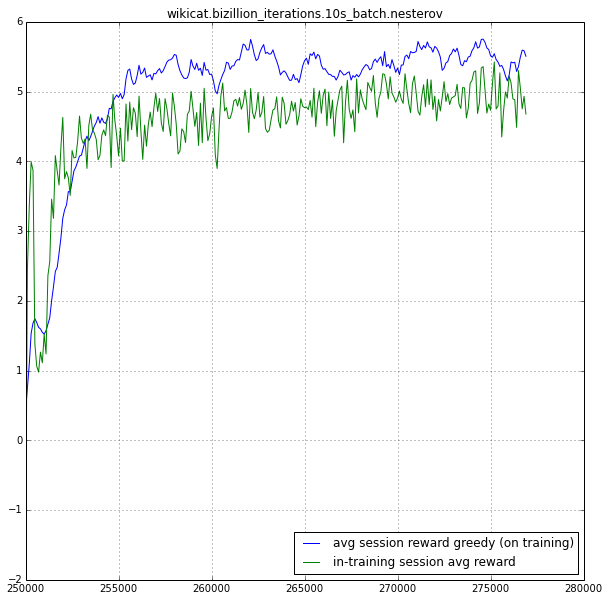

epoch 277000,loss 0.36685, greed 0.95000, rewards: ( train 5.43536, det_train 5.50615) 
rec 0.366 reg 0.001
epoch 277100,loss 0.75220, greed 0.95000, rewards: ( train 4.94599, det_train 5.82554) 
rec 0.751 reg 0.001
epoch 277200,loss 0.51820, greed 0.95000, rewards: ( train 5.23627, det_train 5.76298) 
rec 0.517 reg 0.001
epoch 277300,loss 0.61659, greed 0.95000, rewards: ( train 5.41991, det_train 5.75669) 
rec 0.615 reg 0.001
epoch 277400,loss 0.65274, greed 0.95000, rewards: ( train 5.12242, det_train 5.87102) 
rec 0.652 reg 0.001
epoch 277500,loss 0.70475, greed 0.95000, rewards: ( train 4.96736, det_train 5.79391) 
rec 0.704 reg 0.001
epoch 277600,loss 0.74623, greed 0.95000, rewards: ( train 5.01842, det_train 5.70452) 
rec 0.745 reg 0.001
epoch 277700,loss 0.69567, greed 0.95000, rewards: ( train 4.93009, det_train 5.62407) 
rec 0.694 reg 0.001
epoch 277800,loss 0.46923, greed 0.95000, rewards: ( train 5.40734, det_train 5.72166) 
rec 0.468 reg 0.001
epoch 277900,loss 0.60138, g

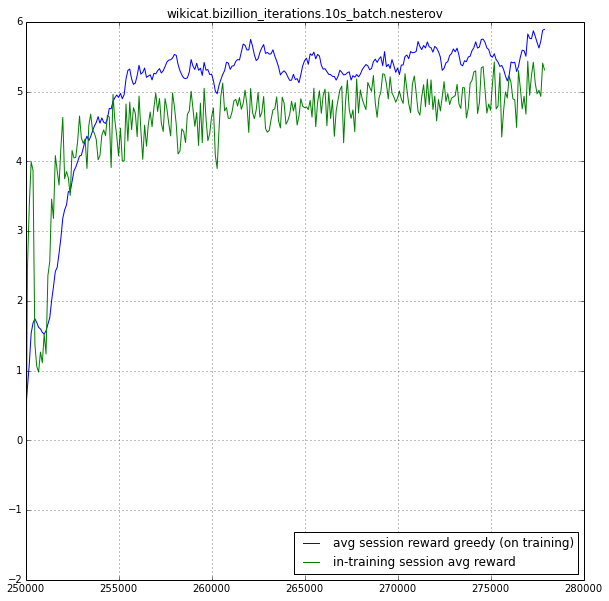

epoch 278000,loss 0.47460, greed 0.95000, rewards: ( train 5.14025, det_train 5.89155) 
rec 0.473 reg 0.001
epoch 278100,loss 0.75328, greed 0.95000, rewards: ( train 4.50015, det_train 5.95239) 
rec 0.752 reg 0.001
epoch 278200,loss 0.57851, greed 0.95000, rewards: ( train 4.98551, det_train 5.71715) 
rec 0.577 reg 0.001
epoch 278300,loss 0.66861, greed 0.95000, rewards: ( train 4.80006, det_train 5.77544) 
rec 0.667 reg 0.001
epoch 278400,loss 0.45955, greed 0.95000, rewards: ( train 4.84793, det_train 5.70789) 
rec 0.458 reg 0.001
epoch 278500,loss 0.83921, greed 0.95000, rewards: ( train 5.37880, det_train 5.82711) 
rec 0.838 reg 0.001
epoch 278600,loss 0.47446, greed 0.95000, rewards: ( train 5.14660, det_train 5.68439) 
rec 0.473 reg 0.001
epoch 278700,loss 0.56980, greed 0.95000, rewards: ( train 5.17329, det_train 5.84596) 
rec 0.569 reg 0.001
epoch 278800,loss 0.60409, greed 0.95000, rewards: ( train 4.99644, det_train 5.85136) 
rec 0.603 reg 0.001
epoch 278900,loss 0.64969, g

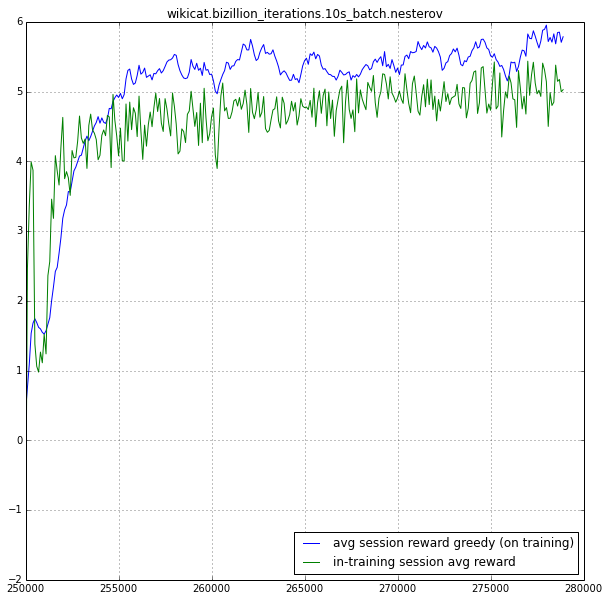

epoch 279000,loss 0.51505, greed 0.95000, rewards: ( train 5.07180, det_train 5.78560) 
rec 0.514 reg 0.001
epoch 279100,loss 0.53632, greed 0.95000, rewards: ( train 4.57886, det_train 5.92704) 
rec 0.535 reg 0.001
epoch 279200,loss 0.54023, greed 0.95000, rewards: ( train 4.89591, det_train 5.85434) 
rec 0.539 reg 0.001
epoch 279300,loss 0.71591, greed 0.95000, rewards: ( train 4.87151, det_train 5.86890) 
rec 0.715 reg 0.001
epoch 279400,loss 0.59480, greed 0.95000, rewards: ( train 4.78632, det_train 5.76201) 
rec 0.594 reg 0.001
epoch 279500,loss 0.51482, greed 0.95000, rewards: ( train 5.28560, det_train 5.67581) 
rec 0.514 reg 0.001
epoch 279600,loss 0.42036, greed 0.95000, rewards: ( train 5.17623, det_train 5.71823) 
rec 0.419 reg 0.001
epoch 279700,loss 0.51768, greed 0.95000, rewards: ( train 4.93076, det_train 5.78641) 
rec 0.516 reg 0.001
epoch 279800,loss 0.61314, greed 0.95000, rewards: ( train 5.05044, det_train 5.76777) 
rec 0.612 reg 0.001
epoch 279900,loss 0.60231, g

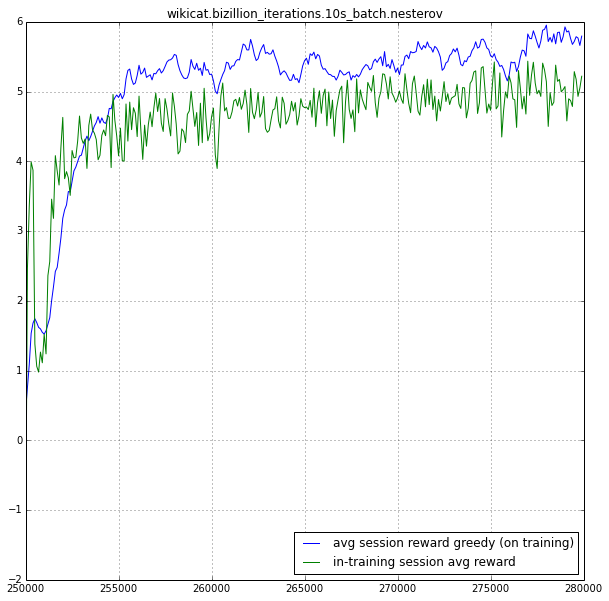

epoch 280000,loss 0.69532, greed 0.95000, rewards: ( train 5.18851, det_train 5.79489) 
rec 0.694 reg 0.001
epoch 280100,loss 0.43187, greed 0.95000, rewards: ( train 5.16057, det_train 5.70540) 
rec 0.431 reg 0.001
epoch 280200,loss 0.52804, greed 0.95000, rewards: ( train 4.93778, det_train 5.70486) 
rec 0.527 reg 0.001
epoch 280300,loss 0.42993, greed 0.95000, rewards: ( train 5.02201, det_train 5.67438) 
rec 0.429 reg 0.001
epoch 280400,loss 0.51509, greed 0.95000, rewards: ( train 5.05394, det_train 5.75694) 
rec 0.514 reg 0.001
epoch 280500,loss 0.53209, greed 0.95000, rewards: ( train 5.09011, det_train 5.84124) 
rec 0.531 reg 0.001
epoch 280600,loss 0.49745, greed 0.95000, rewards: ( train 4.99513, det_train 5.82712) 
rec 0.496 reg 0.001
epoch 280700,loss 0.65453, greed 0.95000, rewards: ( train 4.91712, det_train 5.83441) 
rec 0.653 reg 0.001
epoch 280800,loss 0.56065, greed 0.95000, rewards: ( train 5.45159, det_train 5.70097) 
rec 0.559 reg 0.001
epoch 280900,loss 0.32446, g

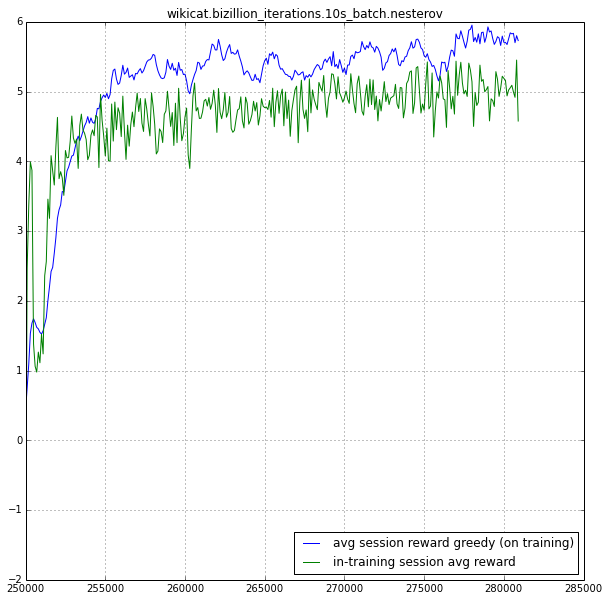

epoch 281000,loss 0.58763, greed 0.95000, rewards: ( train 5.30656, det_train 5.73078) 
rec 0.586 reg 0.001
epoch 281100,loss 0.60150, greed 0.95000, rewards: ( train 4.93881, det_train 5.80770) 
rec 0.600 reg 0.001
epoch 281200,loss 0.51723, greed 0.95000, rewards: ( train 5.21003, det_train 5.70693) 
rec 0.516 reg 0.001
epoch 281300,loss 0.62250, greed 0.95000, rewards: ( train 5.12372, det_train 5.71624) 
rec 0.621 reg 0.001
epoch 281400,loss 0.43047, greed 0.95000, rewards: ( train 5.22315, det_train 5.64462) 
rec 0.429 reg 0.001
epoch 281500,loss 0.44707, greed 0.95000, rewards: ( train 5.48681, det_train 5.67016) 
rec 0.446 reg 0.001
epoch 281600,loss 0.43047, greed 0.95000, rewards: ( train 4.92907, det_train 5.78314) 
rec 0.429 reg 0.001
epoch 281700,loss 0.55088, greed 0.95000, rewards: ( train 5.23823, det_train 5.87483) 
rec 0.550 reg 0.001
epoch 281800,loss 0.58935, greed 0.95000, rewards: ( train 5.02992, det_train 5.93734) 
rec 0.588 reg 0.001
epoch 281900,loss 0.60381, g

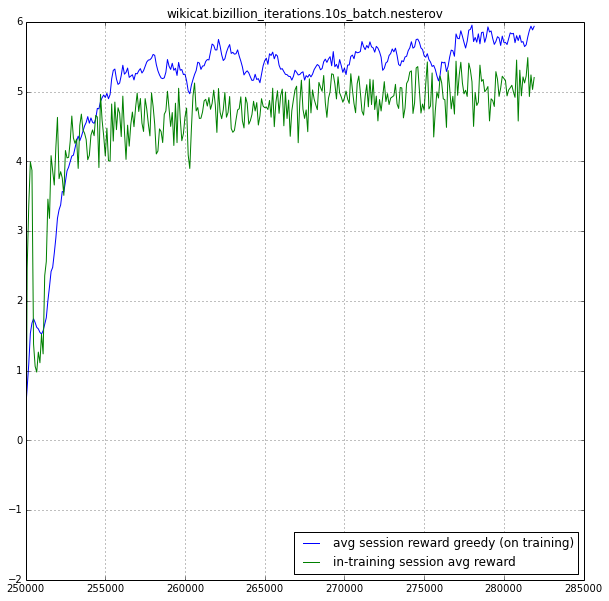

epoch 282000,loss 0.70457, greed 0.95000, rewards: ( train 5.45045, det_train 5.93525) 
rec 0.703 reg 0.001
epoch 282100,loss 0.78669, greed 0.95000, rewards: ( train 5.12892, det_train 6.05172) 
rec 0.785 reg 0.001
epoch 282200,loss 0.50815, greed 0.95000, rewards: ( train 4.90876, det_train 5.98655) 
rec 0.507 reg 0.001
epoch 282300,loss 0.61815, greed 0.95000, rewards: ( train 5.33806, det_train 5.97790) 
rec 0.617 reg 0.001
epoch 282400,loss 0.50926, greed 0.95000, rewards: ( train 4.93388, det_train 5.88011) 
rec 0.508 reg 0.001
epoch 282500,loss 0.59841, greed 0.95000, rewards: ( train 4.98266, det_train 5.86210) 
rec 0.597 reg 0.001
epoch 282600,loss 0.65838, greed 0.95000, rewards: ( train 5.02467, det_train 5.75589) 
rec 0.657 reg 0.001
epoch 282700,loss 0.37860, greed 0.95000, rewards: ( train 4.94402, det_train 5.70030) 
rec 0.377 reg 0.001
epoch 282800,loss 0.62663, greed 0.95000, rewards: ( train 5.14710, det_train 5.68027) 
rec 0.625 reg 0.001
epoch 282900,loss 0.55366, g

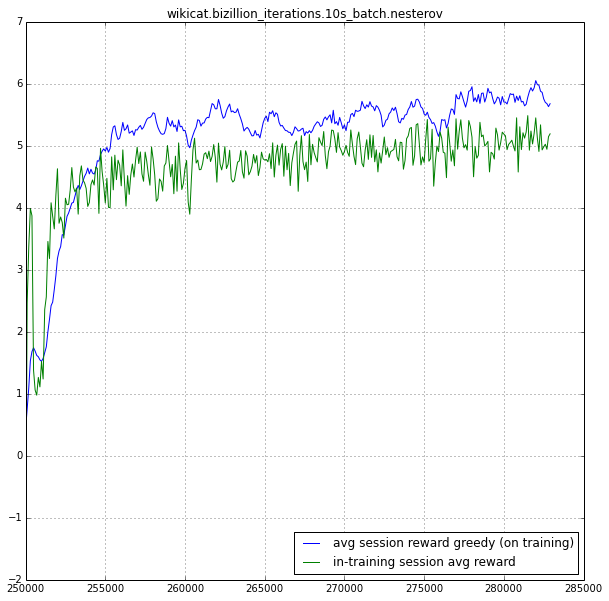

epoch 283000,loss 0.50308, greed 0.95000, rewards: ( train 5.28590, det_train 5.67902) 
rec 0.502 reg 0.001
epoch 283100,loss 0.57067, greed 0.95000, rewards: ( train 4.82364, det_train 5.77112) 
rec 0.569 reg 0.001
epoch 283200,loss 0.53744, greed 0.95000, rewards: ( train 5.48227, det_train 5.74400) 
rec 0.536 reg 0.001
epoch 283300,loss 0.50763, greed 0.95000, rewards: ( train 5.13912, det_train 5.82960) 
rec 0.506 reg 0.001
epoch 283400,loss 0.52239, greed 0.95000, rewards: ( train 5.16844, det_train 5.82664) 
rec 0.521 reg 0.001
epoch 283500,loss 0.67496, greed 0.95000, rewards: ( train 5.40206, det_train 5.86398) 
rec 0.674 reg 0.001
epoch 283600,loss 0.58090, greed 0.95000, rewards: ( train 5.23437, det_train 5.84758) 
rec 0.580 reg 0.001
epoch 283700,loss 0.65439, greed 0.95000, rewards: ( train 5.25912, det_train 5.81282) 
rec 0.653 reg 0.001
epoch 283800,loss 1.03527, greed 0.95000, rewards: ( train 5.12844, det_train 5.86154) 
rec 1.034 reg 0.001
epoch 283900,loss 0.62779, g

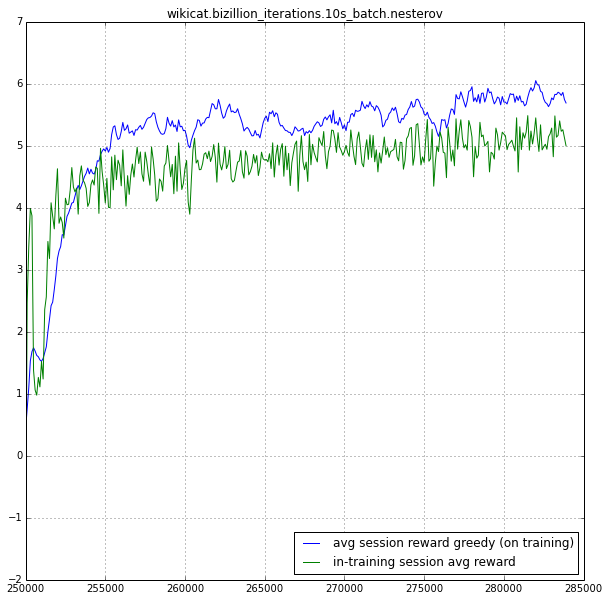

epoch 284000,loss 0.49664, greed 0.95000, rewards: ( train 5.34869, det_train 5.69085) 
rec 0.495 reg 0.001
epoch 284100,loss 0.51036, greed 0.95000, rewards: ( train 5.02008, det_train 5.78176) 
rec 0.509 reg 0.001
epoch 284200,loss 0.50783, greed 0.95000, rewards: ( train 5.21984, det_train 5.85359) 
rec 0.507 reg 0.001
epoch 284300,loss 0.52723, greed 0.95000, rewards: ( train 4.72960, det_train 5.90823) 
rec 0.526 reg 0.001
epoch 284400,loss 0.58765, greed 0.95000, rewards: ( train 5.17184, det_train 5.85741) 
rec 0.586 reg 0.001
epoch 284500,loss 0.76608, greed 0.95000, rewards: ( train 5.30942, det_train 5.92166) 
rec 0.765 reg 0.001
epoch 284600,loss 0.50553, greed 0.95000, rewards: ( train 5.33498, det_train 5.86950) 
rec 0.504 reg 0.001
epoch 284700,loss 0.71425, greed 0.95000, rewards: ( train 5.38852, det_train 5.87255) 
rec 0.713 reg 0.001
epoch 284800,loss 0.55650, greed 0.95000, rewards: ( train 4.89453, det_train 5.82529) 
rec 0.555 reg 0.001
epoch 284900,loss 0.58030, g

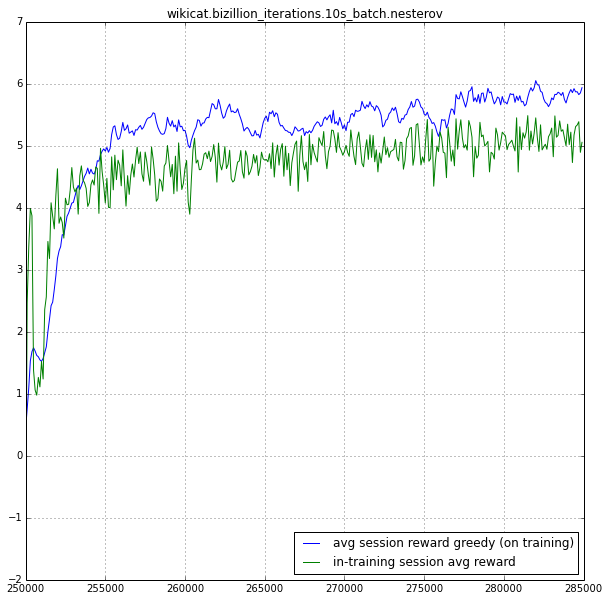

epoch 285000,loss 0.54326, greed 0.95000, rewards: ( train 5.12624, det_train 5.93749) 
rec 0.542 reg 0.001
epoch 285100,loss 0.37258, greed 0.95000, rewards: ( train 5.20566, det_train 5.95374) 
rec 0.371 reg 0.001
epoch 285200,loss 0.43980, greed 0.95000, rewards: ( train 5.26127, det_train 5.96837) 
rec 0.439 reg 0.001
epoch 285300,loss 0.50114, greed 0.95000, rewards: ( train 5.43372, det_train 5.98153) 
rec 0.500 reg 0.001
epoch 285400,loss 0.67189, greed 0.95000, rewards: ( train 4.99064, det_train 6.08338) 
rec 0.671 reg 0.001
epoch 285500,loss 0.76566, greed 0.95000, rewards: ( train 4.93958, det_train 6.05504) 
rec 0.764 reg 0.001
epoch 285600,loss 0.50027, greed 0.95000, rewards: ( train 5.58783, det_train 5.99953) 
rec 0.499 reg 0.001
epoch 285700,loss 0.50971, greed 0.95000, rewards: ( train 5.05917, det_train 6.07958) 
rec 0.508 reg 0.001
epoch 285800,loss 0.47925, greed 0.95000, rewards: ( train 5.03125, det_train 6.14162) 
rec 0.478 reg 0.001
epoch 285900,loss 0.58031, g

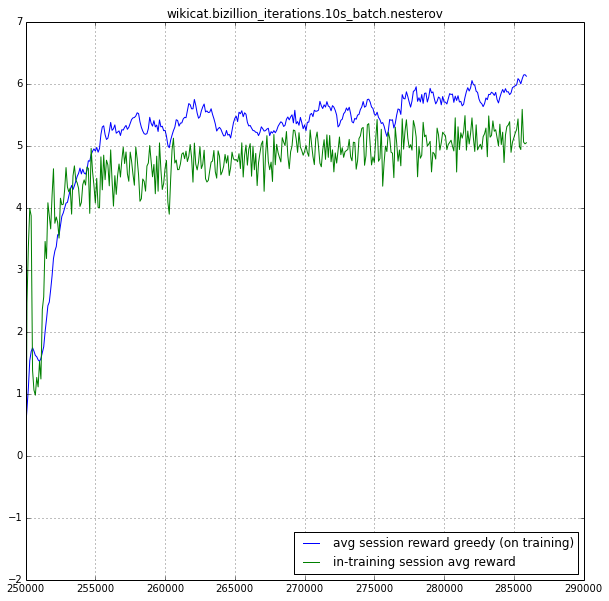

epoch 286000,loss 0.59636, greed 0.95000, rewards: ( train 5.23024, det_train 6.12271) 
rec 0.595 reg 0.001
epoch 286100,loss 0.77874, greed 0.95000, rewards: ( train 4.96055, det_train 6.16044) 
rec 0.778 reg 0.001
epoch 286200,loss 0.49146, greed 0.95000, rewards: ( train 5.16243, det_train 6.05440) 
rec 0.490 reg 0.001
epoch 286300,loss 0.63339, greed 0.95000, rewards: ( train 5.36325, det_train 5.98896) 
rec 0.632 reg 0.001
epoch 286400,loss 0.52593, greed 0.95000, rewards: ( train 5.09529, det_train 5.99006) 
rec 0.525 reg 0.001
epoch 286500,loss 0.61241, greed 0.95000, rewards: ( train 5.20119, det_train 6.06106) 
rec 0.611 reg 0.001
epoch 286600,loss 0.60206, greed 0.95000, rewards: ( train 5.15539, det_train 6.02495) 
rec 0.601 reg 0.001
epoch 286700,loss 0.58132, greed 0.95000, rewards: ( train 4.85204, det_train 6.02246) 
rec 0.580 reg 0.001
epoch 286800,loss 0.57330, greed 0.95000, rewards: ( train 4.92824, det_train 6.03021) 
rec 0.572 reg 0.001
epoch 286900,loss 0.72033, g

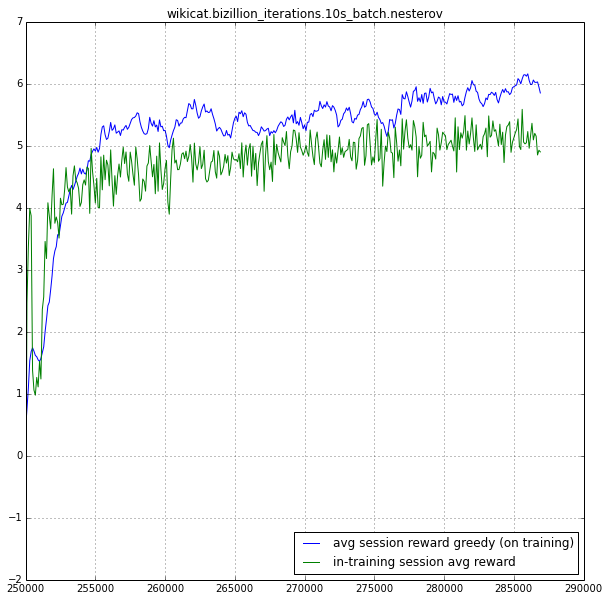

epoch 287000,loss 0.42333, greed 0.95000, rewards: ( train 4.90887, det_train 5.85247) 
rec 0.422 reg 0.001
epoch 287100,loss 0.51907, greed 0.95000, rewards: ( train 4.85666, det_train 5.79722) 
rec 0.518 reg 0.001
epoch 287200,loss 0.64391, greed 0.95000, rewards: ( train 5.01167, det_train 5.73750) 
rec 0.643 reg 0.001
epoch 287300,loss 0.60008, greed 0.95000, rewards: ( train 5.16320, det_train 5.68375) 
rec 0.599 reg 0.001
epoch 287400,loss 0.70632, greed 0.95000, rewards: ( train 4.88689, det_train 5.54538) 
rec 0.705 reg 0.001
epoch 287500,loss 0.53611, greed 0.95000, rewards: ( train 4.99202, det_train 5.57084) 
rec 0.535 reg 0.001
epoch 287600,loss 0.46363, greed 0.95000, rewards: ( train 5.36273, det_train 5.61375) 
rec 0.462 reg 0.001
epoch 287700,loss 0.74999, greed 0.95000, rewards: ( train 5.56931, det_train 5.71238) 
rec 0.749 reg 0.001
epoch 287800,loss 0.51215, greed 0.95000, rewards: ( train 5.37440, det_train 5.78114) 
rec 0.511 reg 0.001
epoch 287900,loss 0.73189, g

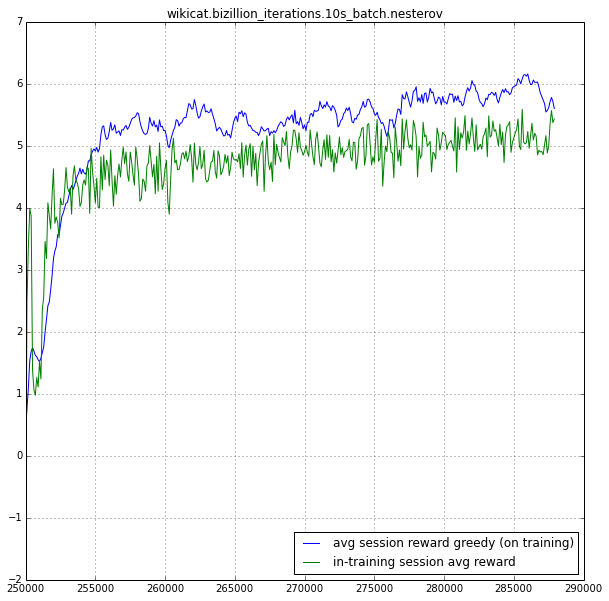

epoch 288000,loss 0.69061, greed 0.95000, rewards: ( train 5.11234, det_train 5.60172) 
rec 0.689 reg 0.001
epoch 288100,loss 0.45517, greed 0.95000, rewards: ( train 5.57257, det_train 5.61155) 
rec 0.454 reg 0.001
epoch 288200,loss 0.48432, greed 0.95000, rewards: ( train 5.22546, det_train 5.92040) 
rec 0.483 reg 0.001
epoch 288300,loss 0.52925, greed 0.95000, rewards: ( train 5.01994, det_train 5.95836) 
rec 0.528 reg 0.001
epoch 288400,loss 0.61948, greed 0.95000, rewards: ( train 4.91534, det_train 6.00252) 
rec 0.618 reg 0.001
epoch 288500,loss 0.55074, greed 0.95000, rewards: ( train 5.57301, det_train 5.85227) 
rec 0.549 reg 0.001
epoch 288600,loss 0.38874, greed 0.95000, rewards: ( train 5.92169, det_train 5.91704) 
rec 0.387 reg 0.001
epoch 288700,loss 0.63910, greed 0.95000, rewards: ( train 5.29717, det_train 6.07534) 
rec 0.638 reg 0.001
epoch 288800,loss 0.50209, greed 0.95000, rewards: ( train 5.21106, det_train 6.10780) 
rec 0.501 reg 0.001
epoch 288900,loss 0.43975, g

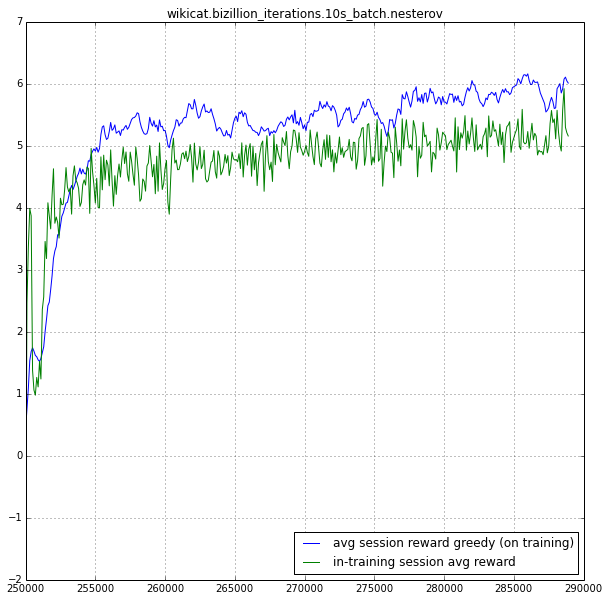

epoch 289000,loss 0.69837, greed 0.95000, rewards: ( train 4.80761, det_train 6.01232) 
rec 0.697 reg 0.001
epoch 289100,loss 0.52565, greed 0.95000, rewards: ( train 5.37428, det_train 5.95109) 
rec 0.524 reg 0.001
epoch 289200,loss 0.44876, greed 0.95000, rewards: ( train 5.22528, det_train 5.99598) 
rec 0.448 reg 0.001
epoch 289300,loss 0.89964, greed 0.95000, rewards: ( train 5.32582, det_train 6.05638) 
rec 0.898 reg 0.001
epoch 289400,loss 0.63248, greed 0.95000, rewards: ( train 5.20521, det_train 5.98074) 
rec 0.631 reg 0.001
epoch 289500,loss 0.62807, greed 0.95000, rewards: ( train 4.83484, det_train 5.92267) 
rec 0.627 reg 0.001
epoch 289600,loss 0.60033, greed 0.95000, rewards: ( train 5.14042, det_train 5.82040) 
rec 0.599 reg 0.001
epoch 289700,loss 0.53320, greed 0.95000, rewards: ( train 5.01991, det_train 5.70836) 
rec 0.532 reg 0.001
epoch 289800,loss 0.61676, greed 0.95000, rewards: ( train 5.01349, det_train 5.71753) 
rec 0.616 reg 0.001
epoch 289900,loss 0.64230, g

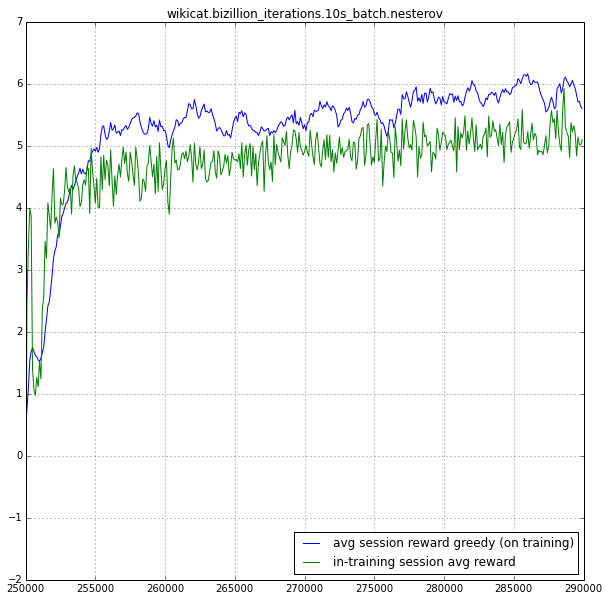

epoch 290000,loss 0.43815, greed 0.95000, rewards: ( train 5.36731, det_train 5.60320) 
rec 0.437 reg 0.001
epoch 290100,loss 0.64497, greed 0.95000, rewards: ( train 5.13898, det_train 5.71288) 
rec 0.644 reg 0.001
epoch 290200,loss 0.49382, greed 0.95000, rewards: ( train 5.22798, det_train 5.62159) 
rec 0.493 reg 0.001
epoch 290300,loss 0.57549, greed 0.95000, rewards: ( train 5.45914, det_train 5.72943) 
rec 0.574 reg 0.001
epoch 290400,loss 0.39140, greed 0.95000, rewards: ( train 5.42126, det_train 5.75649) 
rec 0.390 reg 0.001
epoch 290500,loss 0.59598, greed 0.95000, rewards: ( train 5.37279, det_train 5.84084) 
rec 0.595 reg 0.001
epoch 290600,loss 0.55487, greed 0.95000, rewards: ( train 5.62589, det_train 5.77675) 
rec 0.554 reg 0.001
epoch 290700,loss 0.71952, greed 0.95000, rewards: ( train 5.35199, det_train 5.84908) 
rec 0.718 reg 0.001
epoch 290800,loss 0.59136, greed 0.95000, rewards: ( train 5.20948, det_train 5.80417) 
rec 0.590 reg 0.001
epoch 290900,loss 0.50120, g

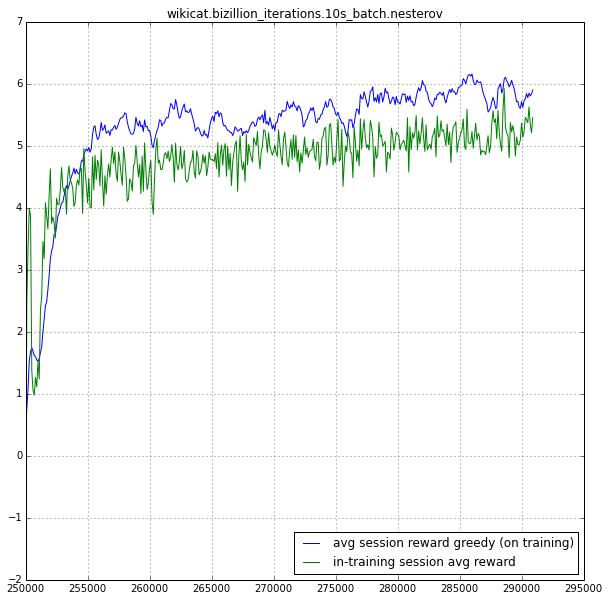

epoch 291000,loss 0.48712, greed 0.95000, rewards: ( train 5.44249, det_train 5.90038) 
rec 0.486 reg 0.001
epoch 291100,loss 0.83913, greed 0.95000, rewards: ( train 5.03124, det_train 5.95034) 
rec 0.838 reg 0.001
epoch 291200,loss 0.63831, greed 0.95000, rewards: ( train 5.89621, det_train 5.73531) 
rec 0.637 reg 0.001
epoch 291300,loss 0.68357, greed 0.95000, rewards: ( train 5.05441, det_train 5.73178) 
rec 0.682 reg 0.001
epoch 291400,loss 0.57411, greed 0.95000, rewards: ( train 5.34501, det_train 5.66860) 
rec 0.573 reg 0.001
epoch 291500,loss 0.52639, greed 0.95000, rewards: ( train 5.16587, det_train 5.70174) 
rec 0.525 reg 0.001
epoch 291600,loss 0.56485, greed 0.95000, rewards: ( train 5.09006, det_train 5.82156) 
rec 0.564 reg 0.001
epoch 291700,loss 0.68881, greed 0.95000, rewards: ( train 5.15939, det_train 5.89941) 
rec 0.688 reg 0.001
epoch 291800,loss 0.50729, greed 0.95000, rewards: ( train 5.47096, det_train 5.75947) 
rec 0.506 reg 0.001
epoch 291900,loss 0.87436, g

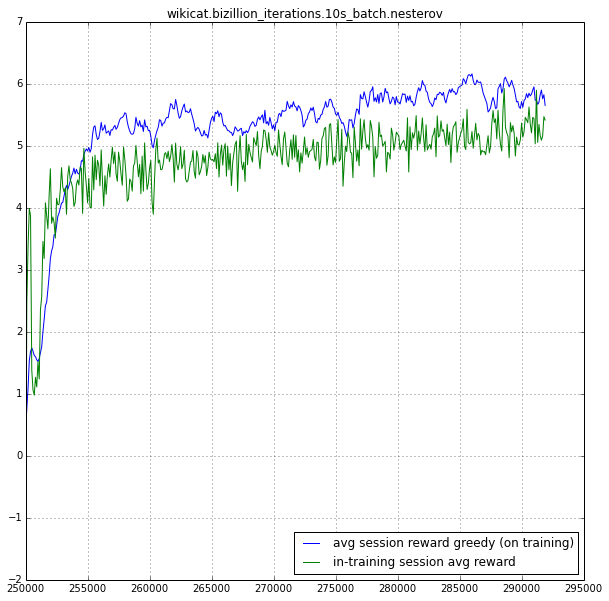

epoch 292000,loss 0.69430, greed 0.95000, rewards: ( train 5.01698, det_train 5.65117) 
rec 0.693 reg 0.001
epoch 292100,loss 0.65344, greed 0.95000, rewards: ( train 5.19187, det_train 5.55605) 
rec 0.652 reg 0.001
epoch 292200,loss 0.43238, greed 0.95000, rewards: ( train 5.61227, det_train 5.54045) 
rec 0.431 reg 0.001
epoch 292300,loss 0.65043, greed 0.95000, rewards: ( train 5.05399, det_train 5.61640) 
rec 0.649 reg 0.001
epoch 292400,loss 0.53806, greed 0.95000, rewards: ( train 5.13985, det_train 5.67476) 
rec 0.537 reg 0.001
epoch 292500,loss 0.62248, greed 0.95000, rewards: ( train 5.31074, det_train 5.73729) 
rec 0.621 reg 0.001
epoch 292600,loss 0.64664, greed 0.95000, rewards: ( train 5.17471, det_train 5.84356) 
rec 0.645 reg 0.001
epoch 292700,loss 0.57578, greed 0.95000, rewards: ( train 5.14407, det_train 5.86920) 
rec 0.575 reg 0.001
epoch 292800,loss 0.56328, greed 0.95000, rewards: ( train 5.18584, det_train 5.90228) 
rec 0.562 reg 0.001
epoch 292900,loss 0.46998, g

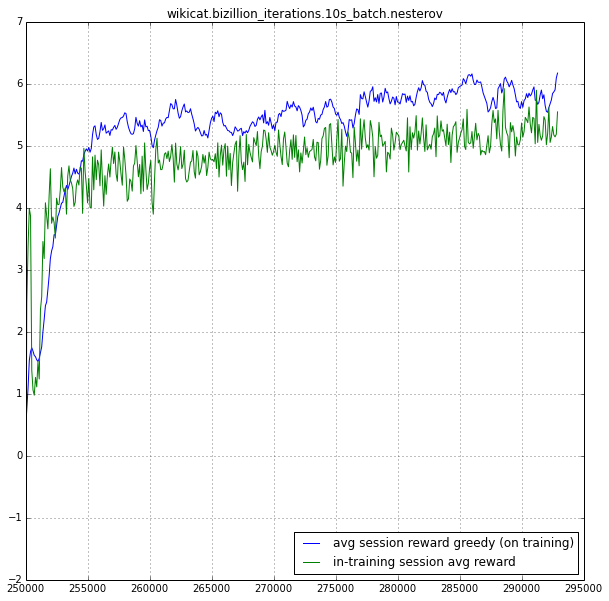

epoch 293000,loss 0.40922, greed 0.95000, rewards: ( train 5.14701, det_train 6.17285) 
rec 0.408 reg 0.001
epoch 293100,loss 0.71393, greed 0.95000, rewards: ( train 5.23305, det_train 6.16556) 
rec 0.713 reg 0.001
epoch 293200,loss 0.59585, greed 0.95000, rewards: ( train 5.14373, det_train 6.02901) 
rec 0.595 reg 0.001
epoch 293300,loss 0.59222, greed 0.95000, rewards: ( train 5.46928, det_train 5.99611) 
rec 0.591 reg 0.001
epoch 293400,loss 0.45184, greed 0.95000, rewards: ( train 5.44504, det_train 6.00650) 
rec 0.451 reg 0.001
epoch 293500,loss 0.51570, greed 0.95000, rewards: ( train 5.19768, det_train 6.03585) 
rec 0.514 reg 0.001
epoch 293600,loss 0.71221, greed 0.95000, rewards: ( train 5.66253, det_train 6.06226) 
rec 0.711 reg 0.001
epoch 293700,loss 0.70530, greed 0.95000, rewards: ( train 5.40640, det_train 6.07604) 
rec 0.704 reg 0.001
epoch 293800,loss 0.44741, greed 0.95000, rewards: ( train 5.15472, det_train 6.04843) 
rec 0.446 reg 0.001
epoch 293900,loss 0.55835, g

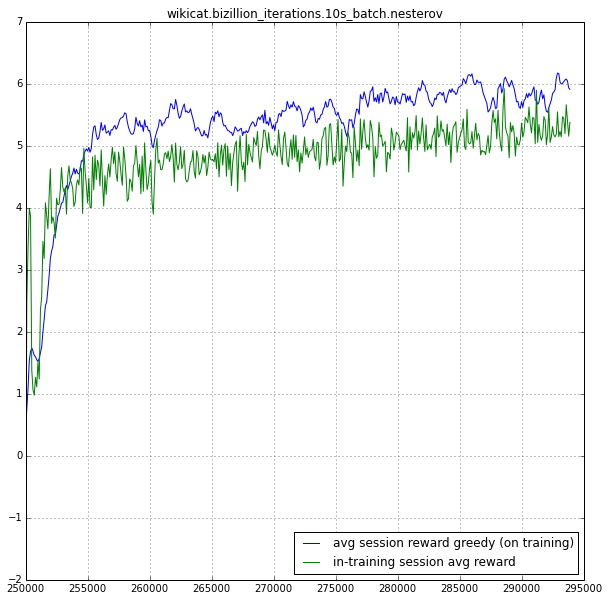

epoch 294000,loss 0.54484, greed 0.95000, rewards: ( train 4.97482, det_train 5.91023) 
rec 0.544 reg 0.001
epoch 294100,loss 0.64889, greed 0.95000, rewards: ( train 5.24443, det_train 5.75921) 
rec 0.648 reg 0.001
epoch 294200,loss 0.49013, greed 0.95000, rewards: ( train 5.14088, det_train 5.73329) 
rec 0.489 reg 0.001
epoch 294300,loss 0.57111, greed 0.95000, rewards: ( train 5.28060, det_train 5.71996) 
rec 0.570 reg 0.001
epoch 294400,loss 0.50176, greed 0.95000, rewards: ( train 5.40053, det_train 5.79796) 
rec 0.500 reg 0.001
epoch 294500,loss 0.38303, greed 0.95000, rewards: ( train 5.54532, det_train 5.78817) 
rec 0.382 reg 0.001
epoch 294600,loss 0.55178, greed 0.95000, rewards: ( train 5.43832, det_train 5.92935) 
rec 0.551 reg 0.001
epoch 294700,loss 0.71198, greed 0.95000, rewards: ( train 5.39853, det_train 6.00641) 
rec 0.711 reg 0.001
epoch 294800,loss 0.45529, greed 0.95000, rewards: ( train 5.23387, det_train 5.98577) 
rec 0.454 reg 0.001
epoch 294900,loss 0.51504, g

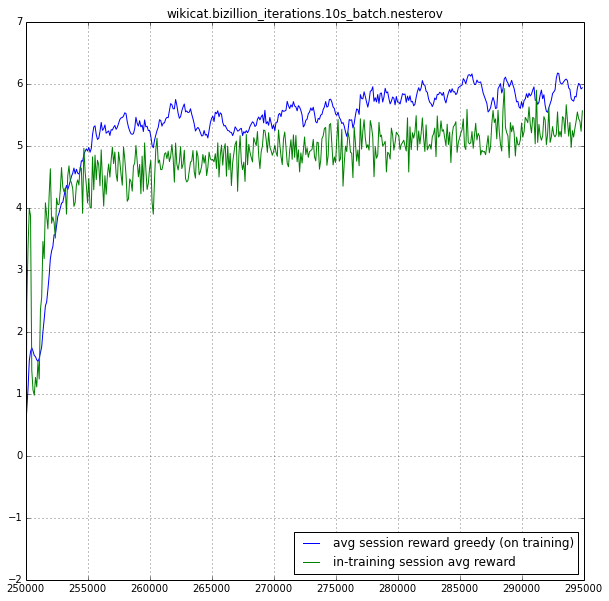

epoch 295000,loss 0.52646, greed 0.95000, rewards: ( train 5.65745, det_train 5.93548) 
rec 0.525 reg 0.001
epoch 295100,loss 0.74132, greed 0.95000, rewards: ( train 5.52185, det_train 5.91193) 
rec 0.740 reg 0.001
epoch 295200,loss 0.67878, greed 0.95000, rewards: ( train 5.14944, det_train 5.88074) 
rec 0.678 reg 0.001
epoch 295300,loss 0.53725, greed 0.95000, rewards: ( train 5.36107, det_train 5.86266) 
rec 0.536 reg 0.001
epoch 295400,loss 0.49535, greed 0.95000, rewards: ( train 5.31220, det_train 5.85640) 
rec 0.494 reg 0.001
epoch 295500,loss 0.53744, greed 0.95000, rewards: ( train 5.47584, det_train 5.84076) 
rec 0.536 reg 0.001
epoch 295600,loss 0.53715, greed 0.95000, rewards: ( train 5.21826, det_train 5.87668) 
rec 0.536 reg 0.001
epoch 295700,loss 0.37018, greed 0.95000, rewards: ( train 5.48921, det_train 5.96901) 
rec 0.369 reg 0.001
epoch 295800,loss 0.61920, greed 0.95000, rewards: ( train 5.22976, det_train 6.16211) 
rec 0.618 reg 0.001
epoch 295900,loss 0.43698, g

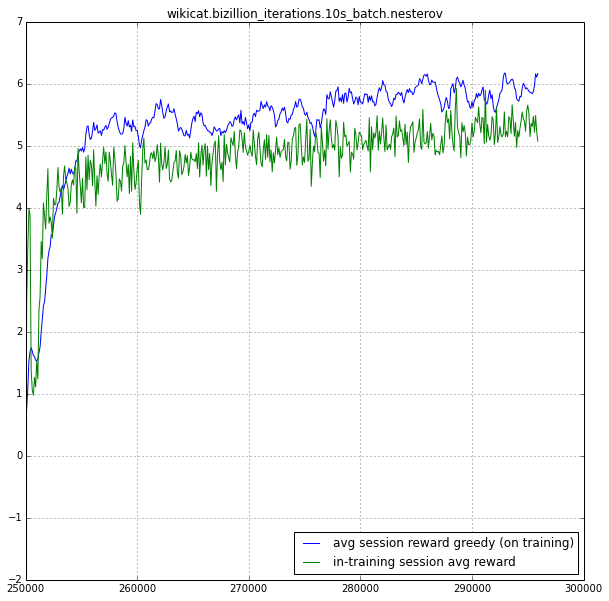

epoch 296000,loss 0.59326, greed 0.95000, rewards: ( train 4.80070, det_train 6.16531) 
rec 0.592 reg 0.001
epoch 296100,loss 0.53387, greed 0.95000, rewards: ( train 4.87275, det_train 6.04878) 
rec 0.533 reg 0.001
epoch 296200,loss 0.48899, greed 0.95000, rewards: ( train 5.43321, det_train 6.09390) 
rec 0.488 reg 0.001
epoch 296300,loss 0.42294, greed 0.95000, rewards: ( train 5.40683, det_train 6.09451) 
rec 0.422 reg 0.001
epoch 296400,loss 0.69584, greed 0.95000, rewards: ( train 5.02988, det_train 6.23506) 
rec 0.695 reg 0.001
epoch 296500,loss 0.62499, greed 0.95000, rewards: ( train 5.08457, det_train 6.21155) 
rec 0.624 reg 0.001
epoch 296600,loss 0.65514, greed 0.95000, rewards: ( train 5.13750, det_train 6.11040) 
rec 0.654 reg 0.001
epoch 296700,loss 0.61627, greed 0.95000, rewards: ( train 5.14315, det_train 5.95936) 
rec 0.615 reg 0.001
epoch 296800,loss 0.63248, greed 0.95000, rewards: ( train 5.14551, det_train 5.94342) 
rec 0.631 reg 0.001
epoch 296900,loss 0.83495, g

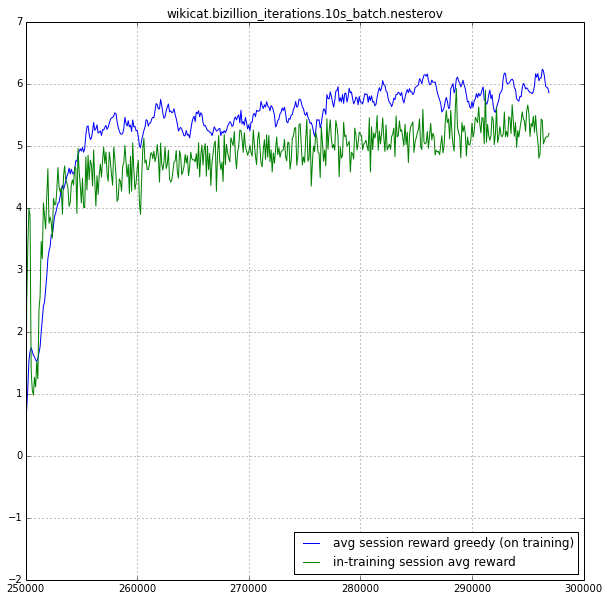

epoch 297000,loss 0.56100, greed 0.95000, rewards: ( train 5.68772, det_train 5.85617) 
rec 0.560 reg 0.001
epoch 297100,loss 0.55460, greed 0.95000, rewards: ( train 5.07363, det_train 5.98056) 
rec 0.553 reg 0.001
epoch 297200,loss 0.59476, greed 0.95000, rewards: ( train 5.90507, det_train 5.90250) 
rec 0.593 reg 0.001
epoch 297300,loss 0.77568, greed 0.95000, rewards: ( train 5.66622, det_train 6.13225) 
rec 0.774 reg 0.001
epoch 297400,loss 0.56103, greed 0.95000, rewards: ( train 5.33519, det_train 6.15902) 
rec 0.560 reg 0.001
epoch 297500,loss 0.75973, greed 0.95000, rewards: ( train 5.40372, det_train 5.97312) 
rec 0.758 reg 0.001
epoch 297600,loss 0.50208, greed 0.95000, rewards: ( train 5.50909, det_train 5.86581) 
rec 0.501 reg 0.001
epoch 297700,loss 0.58680, greed 0.95000, rewards: ( train 4.94593, det_train 5.92923) 
rec 0.586 reg 0.001
epoch 297800,loss 0.64661, greed 0.95000, rewards: ( train 5.64827, det_train 5.76631) 
rec 0.645 reg 0.001
epoch 297900,loss 0.52606, g

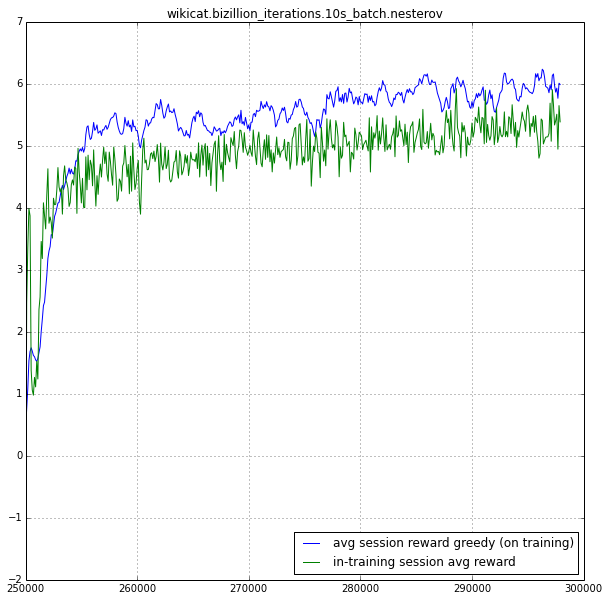

epoch 298000,loss 1.00630, greed 0.95000, rewards: ( train 5.36755, det_train 5.98871) 
rec 1.005 reg 0.001
epoch 298100,loss 0.57111, greed 0.95000, rewards: ( train 5.08089, det_train 5.83984) 
rec 0.570 reg 0.001
epoch 298200,loss 0.55794, greed 0.95000, rewards: ( train 5.68529, det_train 5.85585) 
rec 0.557 reg 0.001
epoch 298300,loss 0.73327, greed 0.95000, rewards: ( train 5.36506, det_train 5.83027) 
rec 0.732 reg 0.001
epoch 298400,loss 0.80040, greed 0.95000, rewards: ( train 5.53089, det_train 5.88724) 
rec 0.799 reg 0.001
epoch 298500,loss 0.50666, greed 0.95000, rewards: ( train 5.32681, det_train 5.72852) 
rec 0.505 reg 0.001
epoch 298600,loss 0.66522, greed 0.95000, rewards: ( train 5.64754, det_train 5.81567) 
rec 0.664 reg 0.001
epoch 298700,loss 0.78271, greed 0.95000, rewards: ( train 5.36752, det_train 5.81410) 
rec 0.781 reg 0.001
epoch 298800,loss 0.46596, greed 0.95000, rewards: ( train 5.69237, det_train 5.73269) 
rec 0.465 reg 0.001
epoch 298900,loss 0.47647, g

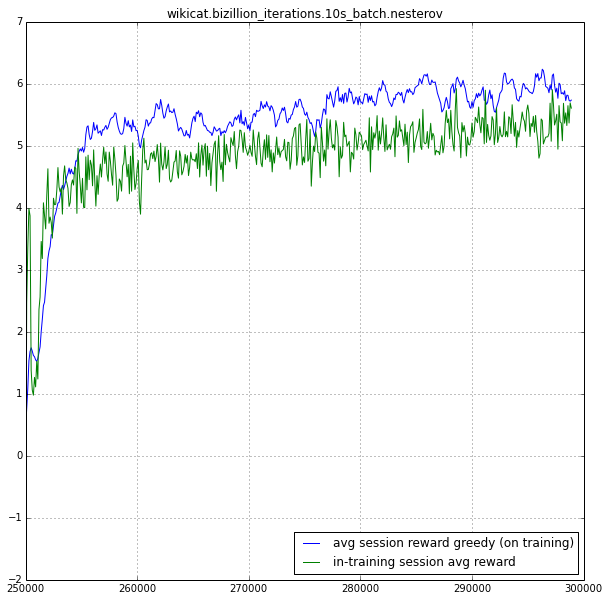

epoch 299000,loss 0.53414, greed 0.95000, rewards: ( train 5.61117, det_train 5.73748) 
rec 0.533 reg 0.001
epoch 299100,loss 0.61328, greed 0.95000, rewards: ( train 5.24889, det_train 5.92373) 
rec 0.612 reg 0.001
epoch 299200,loss 0.69022, greed 0.95000, rewards: ( train 5.68762, det_train 5.92136) 
rec 0.689 reg 0.001
epoch 299300,loss 0.58952, greed 0.95000, rewards: ( train 5.27913, det_train 5.94922) 
rec 0.588 reg 0.001
epoch 299400,loss 0.65950, greed 0.95000, rewards: ( train 5.13798, det_train 5.99430) 
rec 0.658 reg 0.001
epoch 299500,loss 0.49991, greed 0.95000, rewards: ( train 5.31239, det_train 5.97487) 
rec 0.499 reg 0.001
epoch 299600,loss 0.54197, greed 0.95000, rewards: ( train 5.43574, det_train 6.00738) 
rec 0.541 reg 0.001
epoch 299700,loss 0.45841, greed 0.95000, rewards: ( train 5.30662, det_train 6.03664) 
rec 0.457 reg 0.001
epoch 299800,loss 0.45104, greed 0.95000, rewards: ( train 5.53679, det_train 6.01298) 
rec 0.450 reg 0.001
epoch 299900,loss 0.73321, g

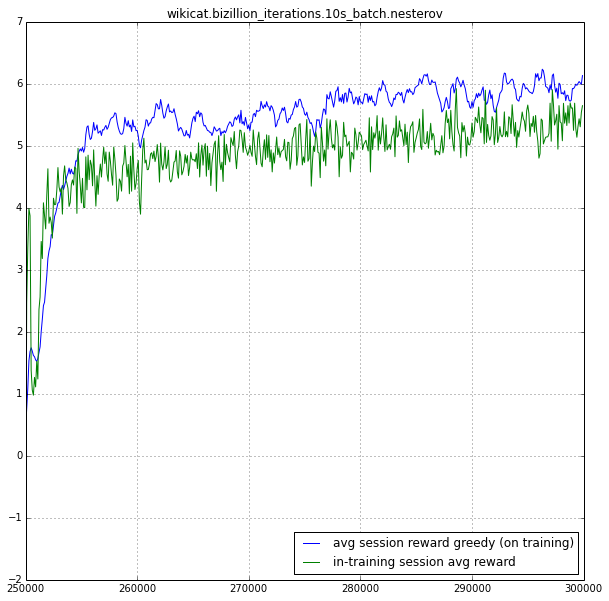

snapshot saved
epoch 300000,loss 0.64408, greed 0.95000, rewards: ( train 5.29351, det_train 6.13251) 
rec 0.643 reg 0.001
epoch 300100,loss 0.48362, greed 0.95000, rewards: ( train 5.51008, det_train 6.19926) 
rec 0.482 reg 0.001
epoch 300200,loss 0.62420, greed 0.95000, rewards: ( train 5.56613, det_train 6.28934) 
rec 0.623 reg 0.001
epoch 300300,loss 0.64757, greed 0.95000, rewards: ( train 5.30699, det_train 6.22040) 
rec 0.646 reg 0.001
epoch 300400,loss 0.41211, greed 0.95000, rewards: ( train 5.70999, det_train 6.17836) 
rec 0.411 reg 0.001
epoch 300500,loss 0.56808, greed 0.95000, rewards: ( train 5.15071, det_train 6.35053) 
rec 0.567 reg 0.001
epoch 300600,loss 0.56067, greed 0.95000, rewards: ( train 5.32444, det_train 6.35547) 
rec 0.559 reg 0.001
epoch 300700,loss 0.58444, greed 0.95000, rewards: ( train 5.40724, det_train 6.44993) 
rec 0.583 reg 0.001
epoch 300800,loss 0.82585, greed 0.95000, rewards: ( train 4.80055, det_train 6.51493) 
rec 0.825 reg 0.001
epoch 300900,

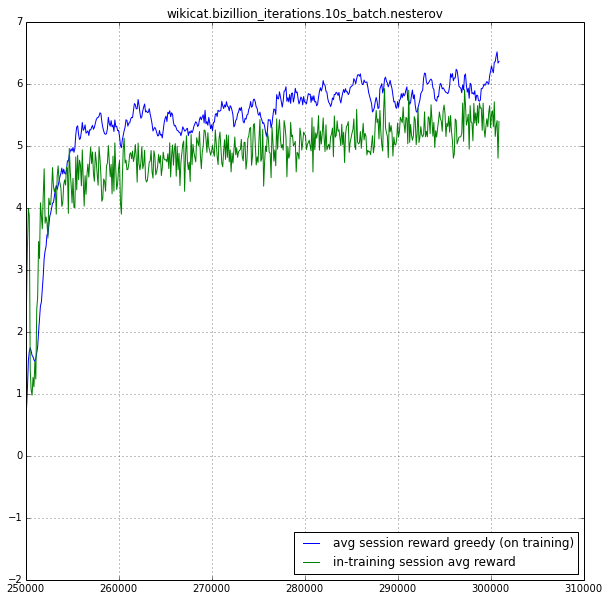

epoch 301000,loss 0.60712, greed 0.95000, rewards: ( train 5.20272, det_train 6.36010) 
rec 0.606 reg 0.001
epoch 301100,loss 0.53431, greed 0.95000, rewards: ( train 5.21873, det_train 6.37409) 
rec 0.533 reg 0.001
epoch 301200,loss 0.51289, greed 0.95000, rewards: ( train 5.23572, det_train 6.23668) 
rec 0.512 reg 0.001
epoch 301300,loss 0.51892, greed 0.95000, rewards: ( train 5.25296, det_train 6.19301) 
rec 0.518 reg 0.001
epoch 301400,loss 0.52814, greed 0.95000, rewards: ( train 5.73279, det_train 6.23371) 
rec 0.527 reg 0.001
epoch 301500,loss 0.45679, greed 0.95000, rewards: ( train 5.00107, det_train 6.38034) 
rec 0.456 reg 0.001
epoch 301600,loss 0.66785, greed 0.95000, rewards: ( train 5.08803, det_train 6.17230) 
rec 0.667 reg 0.001
epoch 301700,loss 0.48169, greed 0.95000, rewards: ( train 5.36925, det_train 6.28507) 
rec 0.480 reg 0.001
epoch 301800,loss 0.57175, greed 0.95000, rewards: ( train 5.24725, det_train 6.28657) 
rec 0.570 reg 0.001
epoch 301900,loss 0.90412, g

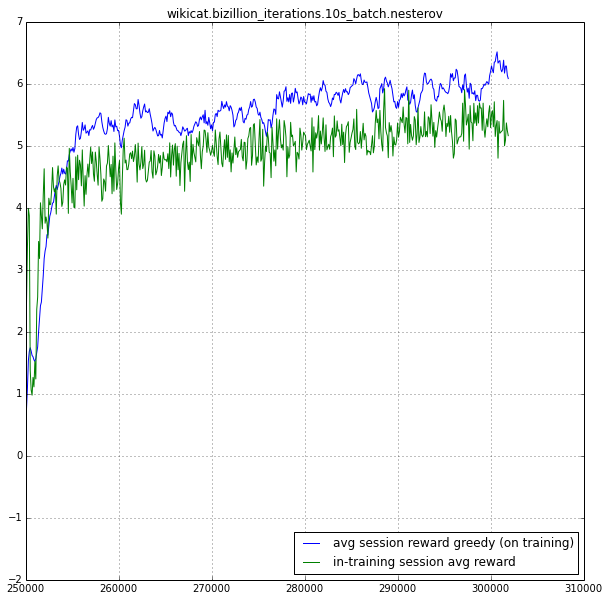

epoch 302000,loss 0.53000, greed 0.95000, rewards: ( train 5.65270, det_train 6.08412) 
rec 0.529 reg 0.001
epoch 302100,loss 0.63520, greed 0.95000, rewards: ( train 5.86631, det_train 6.23571) 
rec 0.634 reg 0.001
epoch 302200,loss 0.73778, greed 0.95000, rewards: ( train 5.53125, det_train 6.27214) 
rec 0.736 reg 0.001
epoch 302300,loss 0.67779, greed 0.95000, rewards: ( train 5.45919, det_train 6.25492) 
rec 0.677 reg 0.001
epoch 302400,loss 0.53916, greed 0.95000, rewards: ( train 5.28504, det_train 6.18943) 
rec 0.538 reg 0.001
epoch 302500,loss 0.56882, greed 0.95000, rewards: ( train 5.29934, det_train 6.19049) 
rec 0.568 reg 0.001
epoch 302600,loss 0.60128, greed 0.95000, rewards: ( train 5.46869, det_train 6.24144) 
rec 0.600 reg 0.001
epoch 302700,loss 0.77628, greed 0.95000, rewards: ( train 5.38393, det_train 6.25729) 
rec 0.775 reg 0.001
epoch 302800,loss 0.74444, greed 0.95000, rewards: ( train 5.31614, det_train 6.05157) 
rec 0.743 reg 0.001
epoch 302900,loss 0.93058, g

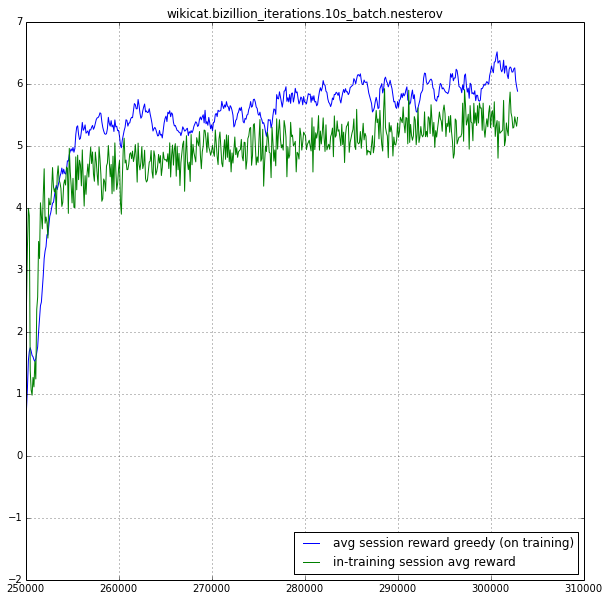

epoch 303000,loss 0.64649, greed 0.95000, rewards: ( train 5.65309, det_train 5.88077) 
rec 0.645 reg 0.001
epoch 303100,loss 0.57790, greed 0.95000, rewards: ( train 5.52373, det_train 5.81269) 
rec 0.577 reg 0.001
epoch 303200,loss 0.37695, greed 0.95000, rewards: ( train 5.42851, det_train 5.89142) 
rec 0.376 reg 0.001
epoch 303300,loss 0.53100, greed 0.95000, rewards: ( train 5.26179, det_train 5.94228) 
rec 0.530 reg 0.001
epoch 303400,loss 0.69922, greed 0.95000, rewards: ( train 5.66882, det_train 5.96805) 
rec 0.698 reg 0.001
epoch 303500,loss 0.54849, greed 0.95000, rewards: ( train 5.49761, det_train 6.11125) 
rec 0.547 reg 0.001
epoch 303600,loss 0.52060, greed 0.95000, rewards: ( train 5.16794, det_train 6.10012) 
rec 0.519 reg 0.001
epoch 303700,loss 0.60459, greed 0.95000, rewards: ( train 5.68648, det_train 6.14011) 
rec 0.603 reg 0.001
epoch 303800,loss 0.81154, greed 0.95000, rewards: ( train 5.48065, det_train 6.09610) 
rec 0.810 reg 0.001
epoch 303900,loss 0.65182, g

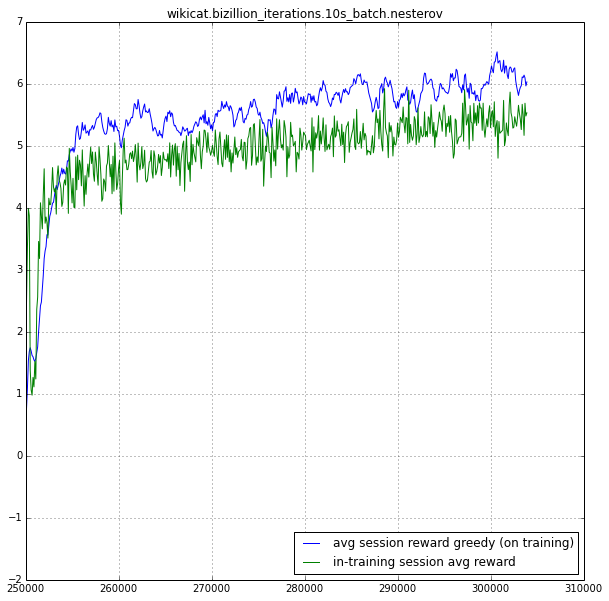

epoch 304000,loss 0.56529, greed 0.95000, rewards: ( train 5.43008, det_train 6.02984) 
rec 0.564 reg 0.001
epoch 304100,loss 0.76231, greed 0.95000, rewards: ( train 5.68003, det_train 6.08686) 
rec 0.761 reg 0.001
epoch 304200,loss 0.45775, greed 0.95000, rewards: ( train 5.50096, det_train 6.00817) 
rec 0.456 reg 0.001
epoch 304300,loss 0.46939, greed 0.95000, rewards: ( train 5.30198, det_train 6.13735) 
rec 0.468 reg 0.001
epoch 304400,loss 0.66049, greed 0.95000, rewards: ( train 5.30187, det_train 6.25362) 
rec 0.659 reg 0.001
epoch 304500,loss 0.89568, greed 0.95000, rewards: ( train 5.03259, det_train 6.14826) 
rec 0.894 reg 0.001
epoch 304600,loss 0.61203, greed 0.95000, rewards: ( train 5.37244, det_train 5.85343) 
rec 0.611 reg 0.001
epoch 304700,loss 0.59726, greed 0.95000, rewards: ( train 5.77748, det_train 6.01809) 
rec 0.596 reg 0.001
epoch 304800,loss 0.72158, greed 0.95000, rewards: ( train 5.81333, det_train 6.00628) 
rec 0.720 reg 0.001
epoch 304900,loss 0.61753, g

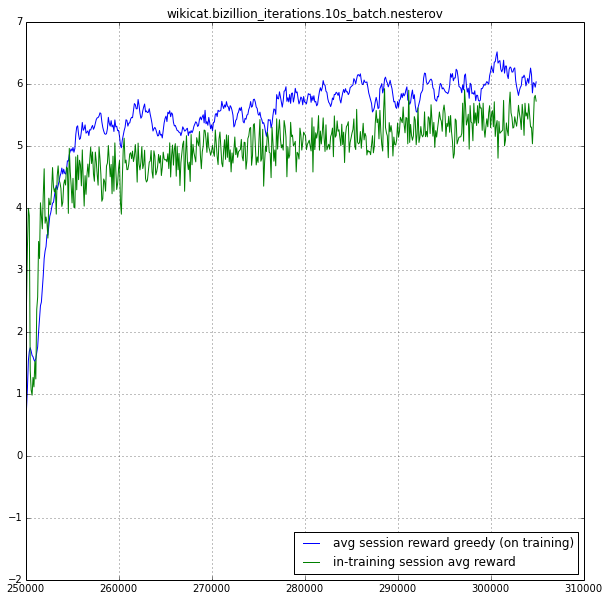

epoch 305000,loss 0.53903, greed 0.95000, rewards: ( train 5.69372, det_train 6.03109) 
rec 0.538 reg 0.001
epoch 305100,loss 0.68546, greed 0.95000, rewards: ( train 5.13992, det_train 6.00798) 
rec 0.684 reg 0.001
epoch 305200,loss 0.64136, greed 0.95000, rewards: ( train 5.72752, det_train 5.89718) 
rec 0.640 reg 0.001
epoch 305300,loss 0.57407, greed 0.95000, rewards: ( train 5.45951, det_train 6.01746) 
rec 0.573 reg 0.001
epoch 305400,loss 0.53568, greed 0.95000, rewards: ( train 5.25128, det_train 6.06572) 
rec 0.534 reg 0.001
epoch 305500,loss 0.79401, greed 0.95000, rewards: ( train 5.68442, det_train 6.29914) 
rec 0.793 reg 0.001
epoch 305600,loss 0.62045, greed 0.95000, rewards: ( train 5.08210, det_train 6.37923) 
rec 0.619 reg 0.001
epoch 305700,loss 0.63811, greed 0.95000, rewards: ( train 5.48343, det_train 6.23131) 
rec 0.637 reg 0.001
epoch 305800,loss 0.43263, greed 0.95000, rewards: ( train 5.35785, det_train 6.24818) 
rec 0.431 reg 0.001
epoch 305900,loss 0.59081, g

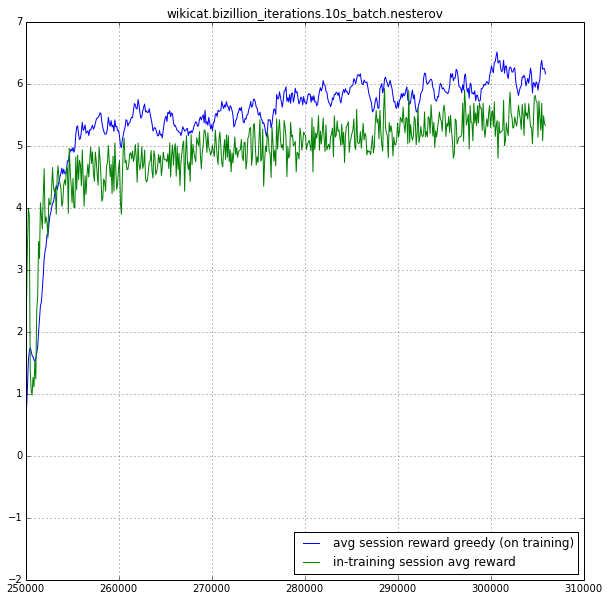

epoch 306000,loss 0.55735, greed 0.95000, rewards: ( train 5.46709, det_train 6.15902) 
rec 0.556 reg 0.001
epoch 306100,loss 0.47242, greed 0.95000, rewards: ( train 5.42493, det_train 6.17312) 
rec 0.471 reg 0.001
epoch 306200,loss 0.70461, greed 0.95000, rewards: ( train 5.39602, det_train 6.18581) 
rec 0.703 reg 0.001
epoch 306300,loss 0.52539, greed 0.95000, rewards: ( train 5.57035, det_train 6.09723) 
rec 0.524 reg 0.001
epoch 306400,loss 0.66996, greed 0.95000, rewards: ( train 5.38607, det_train 5.99750) 
rec 0.669 reg 0.001
epoch 306500,loss 0.74573, greed 0.95000, rewards: ( train 5.70048, det_train 5.90775) 
rec 0.744 reg 0.001
epoch 306600,loss 0.69620, greed 0.95000, rewards: ( train 5.40164, det_train 5.88698) 
rec 0.695 reg 0.001
epoch 306700,loss 0.43976, greed 0.95000, rewards: ( train 5.93379, det_train 5.86828) 
rec 0.438 reg 0.001
epoch 306800,loss 0.66641, greed 0.95000, rewards: ( train 5.45042, det_train 6.01145) 
rec 0.665 reg 0.001
epoch 306900,loss 0.70850, g

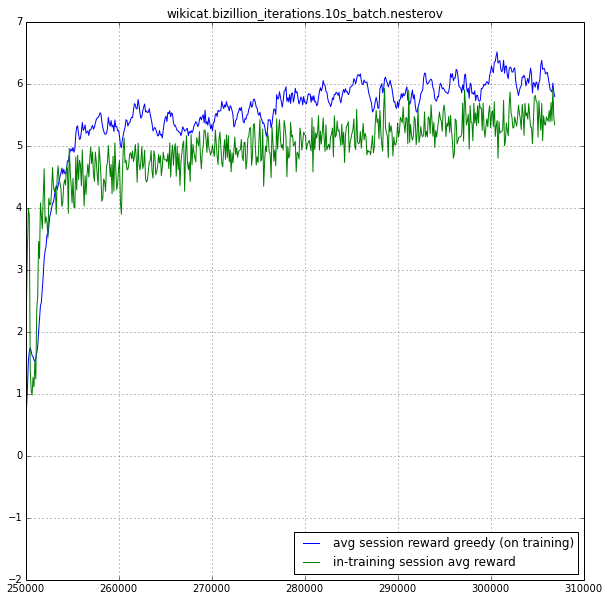

epoch 307000,loss 0.62251, greed 0.95000, rewards: ( train 5.13252, det_train 5.79428) 
rec 0.621 reg 0.001
epoch 307100,loss 0.50693, greed 0.95000, rewards: ( train 5.85710, det_train 5.75485) 
rec 0.506 reg 0.001
epoch 307200,loss 0.54864, greed 0.95000, rewards: ( train 5.28652, det_train 5.86936) 
rec 0.547 reg 0.001
epoch 307300,loss 0.57270, greed 0.95000, rewards: ( train 5.50678, det_train 5.79243) 
rec 0.571 reg 0.001
epoch 307400,loss 0.94816, greed 0.95000, rewards: ( train 5.42493, det_train 5.76318) 
rec 0.947 reg 0.001
epoch 307500,loss 0.57273, greed 0.95000, rewards: ( train 5.37383, det_train 5.87687) 
rec 0.571 reg 0.001
epoch 307600,loss 0.68200, greed 0.95000, rewards: ( train 5.69951, det_train 5.91918) 
rec 0.681 reg 0.001
epoch 307700,loss 0.66867, greed 0.95000, rewards: ( train 5.74145, det_train 6.01726) 
rec 0.667 reg 0.001
epoch 307800,loss 0.78521, greed 0.95000, rewards: ( train 5.59303, det_train 6.04554) 
rec 0.784 reg 0.001
epoch 307900,loss 0.56198, g

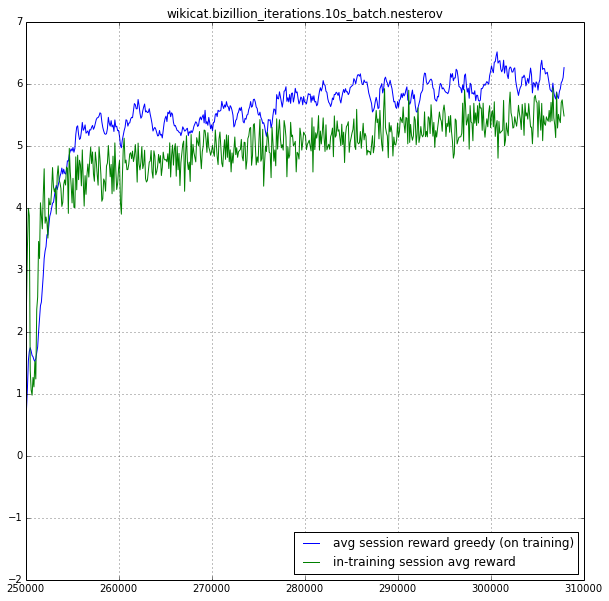

epoch 308000,loss 0.55149, greed 0.95000, rewards: ( train 5.63205, det_train 6.26088) 
rec 0.550 reg 0.001
epoch 308100,loss 0.46139, greed 0.95000, rewards: ( train 5.23593, det_train 6.30480) 
rec 0.460 reg 0.001
epoch 308200,loss 0.65785, greed 0.95000, rewards: ( train 5.53972, det_train 6.38432) 
rec 0.657 reg 0.001
epoch 308300,loss 0.62836, greed 0.95000, rewards: ( train 5.30306, det_train 6.50588) 
rec 0.627 reg 0.001
epoch 308400,loss 0.78339, greed 0.95000, rewards: ( train 5.70842, det_train 6.50530) 
rec 0.782 reg 0.001
epoch 308500,loss 0.52038, greed 0.95000, rewards: ( train 5.72598, det_train 6.34477) 
rec 0.519 reg 0.001
epoch 308600,loss 0.80420, greed 0.95000, rewards: ( train 5.66033, det_train 6.49029) 
rec 0.803 reg 0.001
epoch 308700,loss 0.69464, greed 0.95000, rewards: ( train 5.43356, det_train 6.48126) 
rec 0.693 reg 0.001
epoch 308800,loss 0.59318, greed 0.95000, rewards: ( train 5.77983, det_train 6.48313) 
rec 0.592 reg 0.001
epoch 308900,loss 0.81750, g

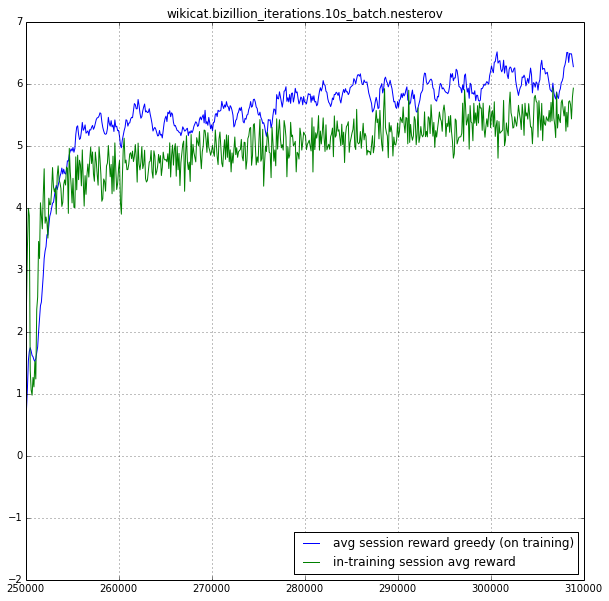

epoch 309000,loss 0.72892, greed 0.95000, rewards: ( train 5.60032, det_train 6.27634) 
rec 0.728 reg 0.001
epoch 309100,loss 0.54999, greed 0.95000, rewards: ( train 5.05777, det_train 6.25871) 
rec 0.549 reg 0.001
epoch 309200,loss 0.51480, greed 0.95000, rewards: ( train 5.49097, det_train 6.21283) 
rec 0.513 reg 0.001
epoch 309300,loss 0.63042, greed 0.95000, rewards: ( train 5.73791, det_train 6.18155) 
rec 0.629 reg 0.001
epoch 309400,loss 0.49178, greed 0.95000, rewards: ( train 5.83134, det_train 6.24340) 
rec 0.490 reg 0.001
epoch 309500,loss 0.59972, greed 0.95000, rewards: ( train 5.59081, det_train 6.37906) 
rec 0.598 reg 0.001
epoch 309600,loss 0.78975, greed 0.95000, rewards: ( train 5.47546, det_train 6.38115) 
rec 0.788 reg 0.001
epoch 309700,loss 0.81543, greed 0.95000, rewards: ( train 5.55537, det_train 6.22304) 
rec 0.814 reg 0.001
epoch 309800,loss 0.68523, greed 0.95000, rewards: ( train 5.75062, det_train 6.05073) 
rec 0.684 reg 0.001
epoch 309900,loss 0.74159, g

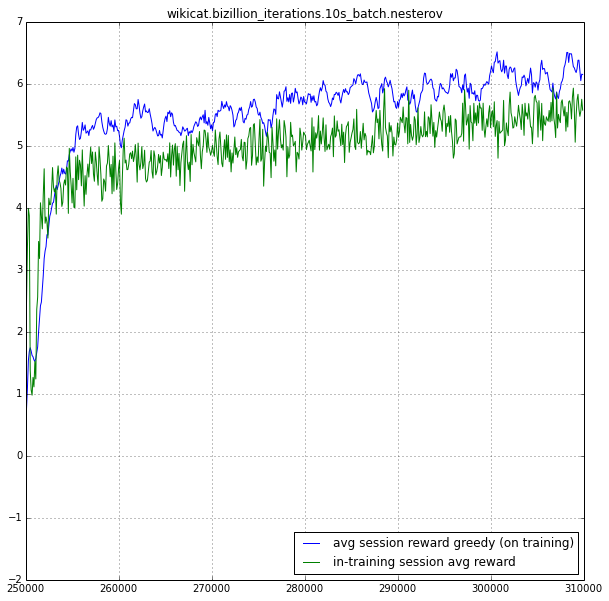

epoch 310000,loss 0.84997, greed 0.95000, rewards: ( train 5.61537, det_train 6.15009) 
rec 0.849 reg 0.001
epoch 310100,loss 0.55694, greed 0.95000, rewards: ( train 5.26124, det_train 6.18508) 
rec 0.556 reg 0.001
epoch 310200,loss 0.70873, greed 0.95000, rewards: ( train 5.55408, det_train 6.15658) 
rec 0.707 reg 0.001
epoch 310300,loss 0.55393, greed 0.95000, rewards: ( train 5.60346, det_train 6.21092) 
rec 0.553 reg 0.001
epoch 310400,loss 0.72937, greed 0.95000, rewards: ( train 5.58006, det_train 6.28983) 
rec 0.728 reg 0.001
epoch 310500,loss 0.55212, greed 0.95000, rewards: ( train 5.23482, det_train 6.32084) 
rec 0.551 reg 0.001
epoch 310600,loss 0.66443, greed 0.95000, rewards: ( train 5.05220, det_train 6.49876) 
rec 0.663 reg 0.001
epoch 310700,loss 0.76482, greed 0.95000, rewards: ( train 5.29283, det_train 6.36888) 
rec 0.764 reg 0.001
epoch 310800,loss 0.48495, greed 0.95000, rewards: ( train 5.49725, det_train 6.31199) 
rec 0.484 reg 0.001
epoch 310900,loss 0.69706, g

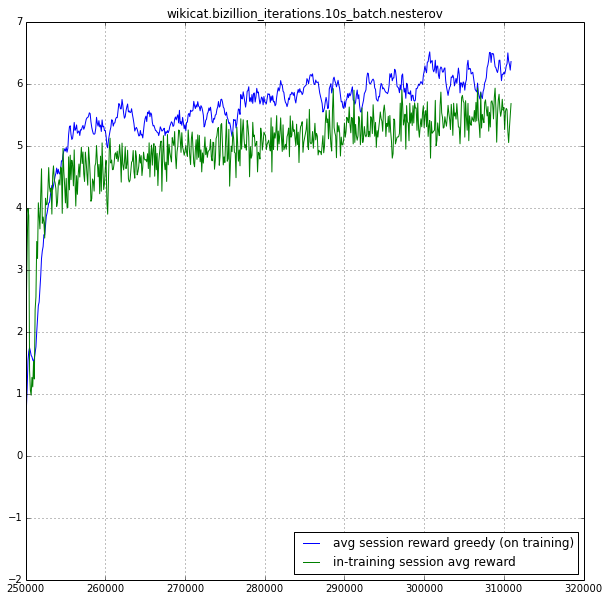

epoch 311000,loss 0.58016, greed 0.95000, rewards: ( train 5.58612, det_train 6.35872) 
rec 0.579 reg 0.001
epoch 311100,loss 0.52684, greed 0.95000, rewards: ( train 5.80440, det_train 6.33284) 
rec 0.526 reg 0.001
epoch 311200,loss 0.79884, greed 0.95000, rewards: ( train 5.72232, det_train 6.42956) 
rec 0.798 reg 0.001
epoch 311300,loss 0.69249, greed 0.95000, rewards: ( train 5.72857, det_train 6.36660) 
rec 0.691 reg 0.001
epoch 311400,loss 0.71680, greed 0.95000, rewards: ( train 5.84120, det_train 6.26994) 
rec 0.715 reg 0.001
epoch 311500,loss 0.57472, greed 0.95000, rewards: ( train 5.71220, det_train 6.27295) 
rec 0.573 reg 0.001
epoch 311600,loss 0.63893, greed 0.95000, rewards: ( train 5.66778, det_train 6.28565) 
rec 0.638 reg 0.001
epoch 311700,loss 0.63971, greed 0.95000, rewards: ( train 5.53339, det_train 6.26709) 
rec 0.638 reg 0.001
epoch 311800,loss 0.57963, greed 0.95000, rewards: ( train 5.38845, det_train 6.27038) 
rec 0.578 reg 0.001
epoch 311900,loss 0.69538, g

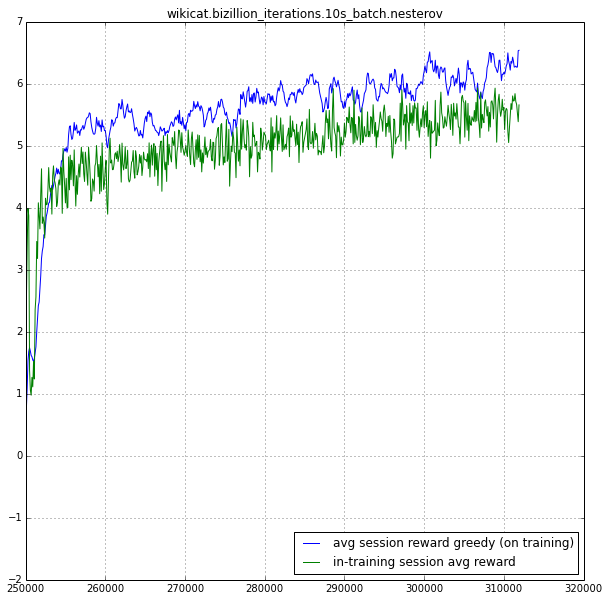

epoch 312000,loss 0.83978, greed 0.95000, rewards: ( train 5.48052, det_train 6.54001) 
rec 0.838 reg 0.001
epoch 312100,loss 0.64045, greed 0.95000, rewards: ( train 5.69627, det_train 6.38601) 
rec 0.639 reg 0.001
epoch 312200,loss 0.43082, greed 0.95000, rewards: ( train 5.77125, det_train 6.48741) 
rec 0.430 reg 0.001
epoch 312300,loss 0.66053, greed 0.95000, rewards: ( train 5.25470, det_train 6.51867) 
rec 0.659 reg 0.001
epoch 312400,loss 0.66076, greed 0.95000, rewards: ( train 5.53506, det_train 6.43680) 
rec 0.659 reg 0.001
epoch 312500,loss 0.65035, greed 0.95000, rewards: ( train 5.56035, det_train 6.40312) 
rec 0.649 reg 0.001
epoch 312600,loss 0.39688, greed 0.95000, rewards: ( train 5.56920, det_train 6.34281) 
rec 0.396 reg 0.001
epoch 312700,loss 0.69896, greed 0.95000, rewards: ( train 5.77385, det_train 6.41853) 
rec 0.698 reg 0.001
epoch 312800,loss 0.44732, greed 0.95000, rewards: ( train 5.38433, det_train 6.39667) 
rec 0.446 reg 0.001
epoch 312900,loss 0.54080, g

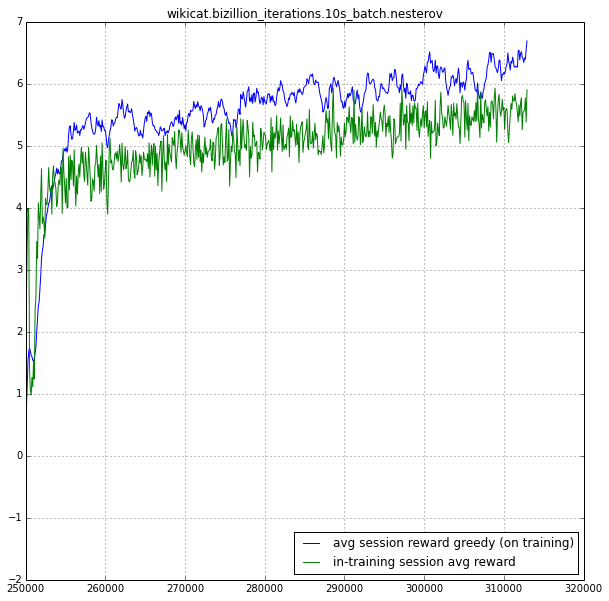

epoch 313000,loss 0.47741, greed 0.95000, rewards: ( train 5.77937, det_train 6.69131) 
rec 0.476 reg 0.001
epoch 313100,loss 0.65145, greed 0.95000, rewards: ( train 5.70169, det_train 6.76218) 
rec 0.650 reg 0.001
epoch 313200,loss 0.46501, greed 0.95000, rewards: ( train 5.48748, det_train 6.73596) 
rec 0.464 reg 0.001
epoch 313300,loss 0.70596, greed 0.95000, rewards: ( train 5.61193, det_train 6.83236) 
rec 0.705 reg 0.001
epoch 313400,loss 0.51951, greed 0.95000, rewards: ( train 6.27434, det_train 6.77913) 
rec 0.518 reg 0.001
epoch 313500,loss 0.63680, greed 0.95000, rewards: ( train 5.59097, det_train 6.98121) 
rec 0.635 reg 0.001
epoch 313600,loss 0.74088, greed 0.95000, rewards: ( train 5.46470, det_train 6.94309) 
rec 0.740 reg 0.001
epoch 313700,loss 0.57881, greed 0.95000, rewards: ( train 5.90433, det_train 6.92878) 
rec 0.577 reg 0.001
epoch 313800,loss 0.50948, greed 0.95000, rewards: ( train 5.31472, det_train 7.02590) 
rec 0.508 reg 0.001
epoch 313900,loss 0.84706, g

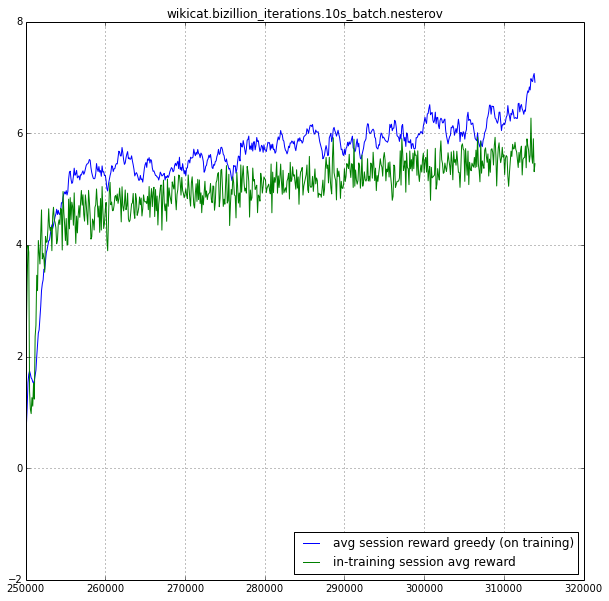

epoch 314000,loss 0.65234, greed 0.95000, rewards: ( train 5.28584, det_train 6.91598) 
rec 0.651 reg 0.001
epoch 314100,loss 0.55365, greed 0.95000, rewards: ( train 5.78576, det_train 6.75438) 
rec 0.552 reg 0.001
epoch 314200,loss 0.67765, greed 0.95000, rewards: ( train 5.65772, det_train 6.70895) 
rec 0.676 reg 0.001
epoch 314300,loss 0.76913, greed 0.95000, rewards: ( train 5.46084, det_train 6.58805) 
rec 0.768 reg 0.001
epoch 314400,loss 0.43184, greed 0.95000, rewards: ( train 5.39059, det_train 6.44925) 
rec 0.431 reg 0.001
epoch 314500,loss 0.78797, greed 0.95000, rewards: ( train 5.46749, det_train 6.44432) 
rec 0.787 reg 0.001
epoch 314600,loss 0.61471, greed 0.95000, rewards: ( train 5.24667, det_train 6.38989) 
rec 0.613 reg 0.001
epoch 314700,loss 0.65401, greed 0.95000, rewards: ( train 5.54509, det_train 6.46090) 
rec 0.653 reg 0.001
epoch 314800,loss 0.60303, greed 0.95000, rewards: ( train 5.38161, det_train 6.39481) 
rec 0.602 reg 0.001
epoch 314900,loss 0.66716, g

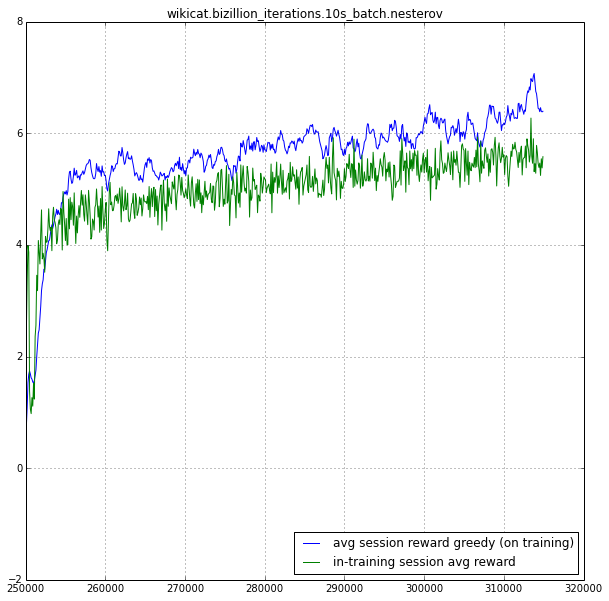

epoch 315000,loss 0.75524, greed 0.95000, rewards: ( train 5.84479, det_train 6.39680) 
rec 0.754 reg 0.001
epoch 315100,loss 0.62819, greed 0.95000, rewards: ( train 5.89115, det_train 6.42712) 
rec 0.627 reg 0.001
epoch 315200,loss 0.57979, greed 0.95000, rewards: ( train 5.68691, det_train 6.36441) 
rec 0.578 reg 0.001
epoch 315300,loss 0.64230, greed 0.95000, rewards: ( train 5.40340, det_train 6.53796) 
rec 0.641 reg 0.001
epoch 315400,loss 0.59068, greed 0.95000, rewards: ( train 5.73805, det_train 6.41417) 
rec 0.589 reg 0.001
epoch 315500,loss 0.64403, greed 0.95000, rewards: ( train 5.16075, det_train 6.40275) 
rec 0.643 reg 0.001
epoch 315600,loss 0.66851, greed 0.95000, rewards: ( train 5.96025, det_train 6.52248) 
rec 0.667 reg 0.001
epoch 315700,loss 0.71628, greed 0.95000, rewards: ( train 5.88991, det_train 6.77023) 
rec 0.715 reg 0.001
epoch 315800,loss 0.81551, greed 0.95000, rewards: ( train 5.83844, det_train 6.79321) 
rec 0.814 reg 0.001
epoch 315900,loss 0.66348, g

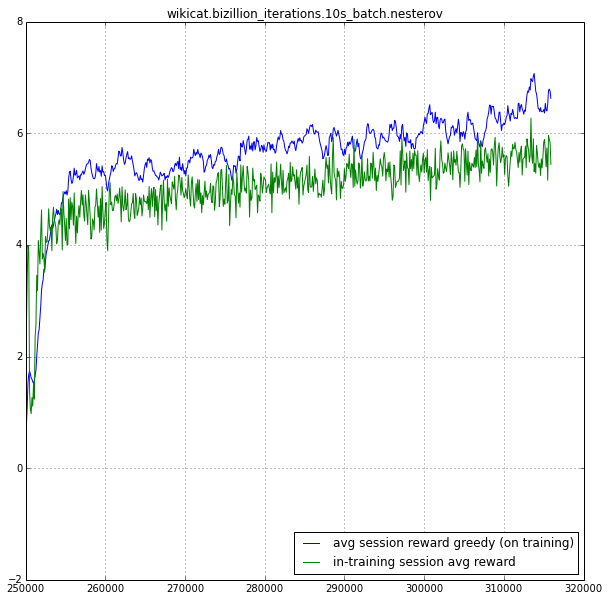

epoch 316000,loss 0.79846, greed 0.95000, rewards: ( train 5.25327, det_train 6.62850) 
rec 0.797 reg 0.001
epoch 316100,loss 0.56853, greed 0.95000, rewards: ( train 5.70181, det_train 6.59565) 
rec 0.567 reg 0.001
epoch 316200,loss 0.58097, greed 0.95000, rewards: ( train 5.54963, det_train 6.52608) 
rec 0.580 reg 0.001
epoch 316300,loss 0.46766, greed 0.95000, rewards: ( train 5.38279, det_train 6.52347) 
rec 0.466 reg 0.001
epoch 316400,loss 0.69292, greed 0.95000, rewards: ( train 5.44090, det_train 6.51113) 
rec 0.692 reg 0.001
epoch 316500,loss 0.68178, greed 0.95000, rewards: ( train 5.43791, det_train 6.38001) 
rec 0.680 reg 0.001
epoch 316600,loss 0.61376, greed 0.95000, rewards: ( train 5.42059, det_train 6.43201) 
rec 0.612 reg 0.001
epoch 316700,loss 0.39313, greed 0.95000, rewards: ( train 5.86659, det_train 6.37881) 
rec 0.392 reg 0.001
epoch 316800,loss 0.51744, greed 0.95000, rewards: ( train 5.55694, det_train 6.50093) 
rec 0.516 reg 0.001
epoch 316900,loss 0.80739, g

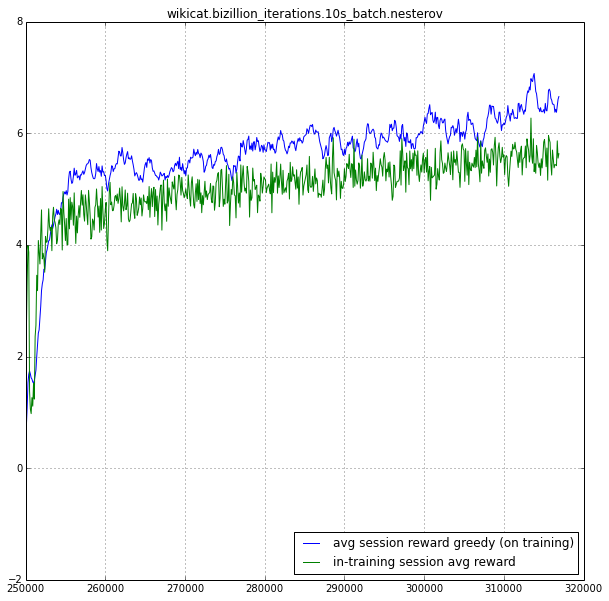

epoch 317000,loss 0.66363, greed 0.95000, rewards: ( train 5.79047, det_train 6.65975) 
rec 0.662 reg 0.001
epoch 317100,loss 0.56924, greed 0.95000, rewards: ( train 5.70426, det_train 6.67378) 
rec 0.568 reg 0.001
epoch 317200,loss 0.68532, greed 0.95000, rewards: ( train 5.53927, det_train 6.57640) 
rec 0.684 reg 0.001
epoch 317300,loss 0.53212, greed 0.95000, rewards: ( train 5.52471, det_train 6.48876) 
rec 0.531 reg 0.001
epoch 317400,loss 0.82838, greed 0.95000, rewards: ( train 5.31089, det_train 6.51988) 
rec 0.827 reg 0.001
epoch 317500,loss 0.82179, greed 0.95000, rewards: ( train 5.55680, det_train 6.40790) 
rec 0.820 reg 0.001
epoch 317600,loss 0.45720, greed 0.95000, rewards: ( train 5.52599, det_train 6.28711) 
rec 0.456 reg 0.001
epoch 317700,loss 0.52082, greed 0.95000, rewards: ( train 5.26811, det_train 6.38840) 
rec 0.520 reg 0.001
epoch 317800,loss 0.41888, greed 0.95000, rewards: ( train 5.62956, det_train 6.45956) 
rec 0.418 reg 0.001
epoch 317900,loss 0.55873, g

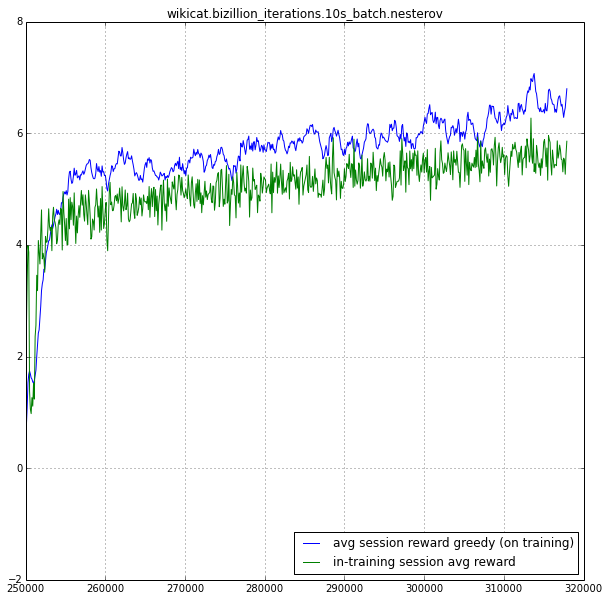

epoch 318000,loss 0.48072, greed 0.95000, rewards: ( train 5.64988, det_train 6.80024) 
rec 0.479 reg 0.001
epoch 318100,loss 0.91573, greed 0.95000, rewards: ( train 5.68278, det_train 6.72022) 
rec 0.914 reg 0.001
epoch 318200,loss 0.71330, greed 0.95000, rewards: ( train 5.87170, det_train 6.64819) 
rec 0.712 reg 0.001
epoch 318300,loss 0.52367, greed 0.95000, rewards: ( train 5.56148, det_train 6.56338) 
rec 0.522 reg 0.001
epoch 318400,loss 0.58761, greed 0.95000, rewards: ( train 5.78021, det_train 6.54704) 
rec 0.586 reg 0.001
epoch 318500,loss 0.54601, greed 0.95000, rewards: ( train 5.80915, det_train 6.57233) 
rec 0.545 reg 0.001
epoch 318600,loss 0.81926, greed 0.95000, rewards: ( train 5.78229, det_train 6.59510) 
rec 0.818 reg 0.001
epoch 318700,loss 0.44411, greed 0.95000, rewards: ( train 5.62077, det_train 6.50559) 
rec 0.443 reg 0.001
epoch 318800,loss 0.54499, greed 0.95000, rewards: ( train 5.80474, det_train 6.53503) 
rec 0.544 reg 0.001
epoch 318900,loss 0.69081, g

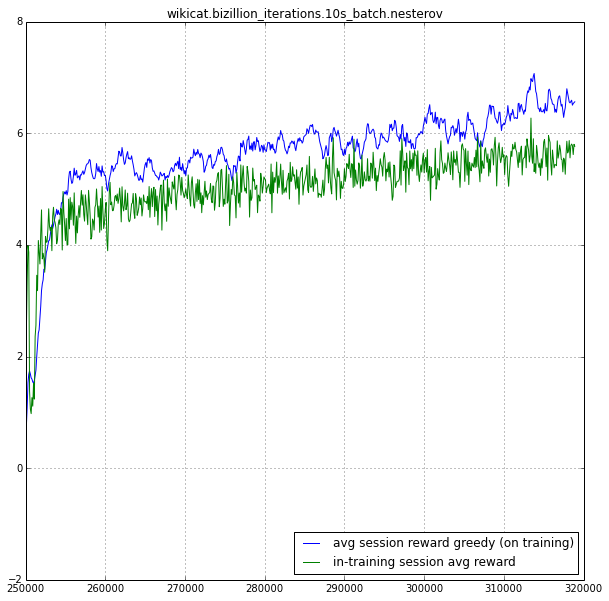

epoch 319000,loss 0.54257, greed 0.95000, rewards: ( train 5.36114, det_train 6.56638) 
rec 0.541 reg 0.001
epoch 319100,loss 0.77345, greed 0.95000, rewards: ( train 5.73224, det_train 6.58974) 
rec 0.772 reg 0.001
epoch 319200,loss 0.96385, greed 0.95000, rewards: ( train 5.01863, det_train 6.52076) 
rec 0.963 reg 0.001
epoch 319300,loss 0.69295, greed 0.95000, rewards: ( train 5.71757, det_train 6.32869) 
rec 0.692 reg 0.001
epoch 319400,loss 0.83972, greed 0.95000, rewards: ( train 5.30012, det_train 6.32582) 
rec 0.838 reg 0.001
epoch 319500,loss 0.58475, greed 0.95000, rewards: ( train 5.65880, det_train 6.31324) 
rec 0.583 reg 0.001
epoch 319600,loss 0.91442, greed 0.95000, rewards: ( train 5.70261, det_train 6.48191) 
rec 0.913 reg 0.001
epoch 319700,loss 0.56913, greed 0.95000, rewards: ( train 5.71338, det_train 6.49372) 
rec 0.568 reg 0.001
epoch 319800,loss 0.96611, greed 0.95000, rewards: ( train 5.50238, det_train 6.47435) 
rec 0.965 reg 0.001
epoch 319900,loss 0.59778, g

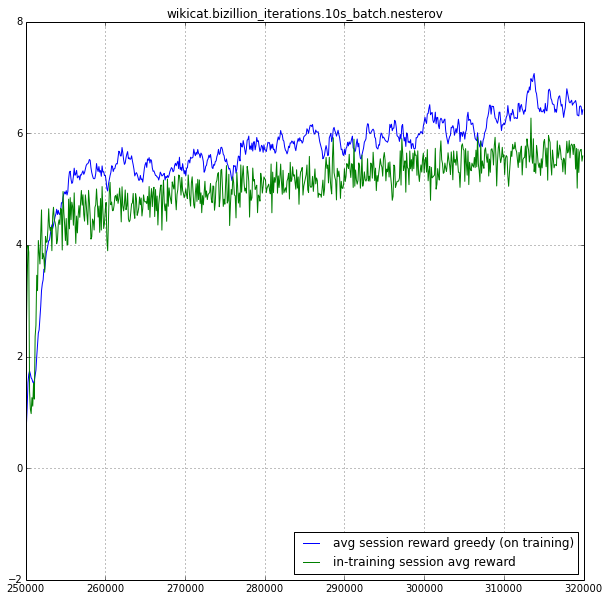

epoch 320000,loss 0.71819, greed 0.95000, rewards: ( train 5.30573, det_train 6.42322) 
rec 0.717 reg 0.001
epoch 320100,loss 0.78938, greed 0.95000, rewards: ( train 5.69181, det_train 6.34090) 
rec 0.788 reg 0.001
epoch 320200,loss 0.55599, greed 0.95000, rewards: ( train 5.68838, det_train 6.30681) 
rec 0.555 reg 0.001
epoch 320300,loss 0.53992, greed 0.95000, rewards: ( train 5.85831, det_train 6.43613) 
rec 0.539 reg 0.001
epoch 320400,loss 0.65068, greed 0.95000, rewards: ( train 5.32380, det_train 6.43252) 
rec 0.649 reg 0.001
epoch 320500,loss 0.61614, greed 0.95000, rewards: ( train 5.74637, det_train 6.35927) 
rec 0.615 reg 0.001
epoch 320600,loss 0.68269, greed 0.95000, rewards: ( train 5.46888, det_train 6.57334) 
rec 0.681 reg 0.001
epoch 320700,loss 0.66951, greed 0.95000, rewards: ( train 5.83852, det_train 6.51600) 
rec 0.668 reg 0.001
epoch 320800,loss 0.57983, greed 0.95000, rewards: ( train 5.91147, det_train 6.68440) 
rec 0.579 reg 0.001
epoch 320900,loss 0.64332, g

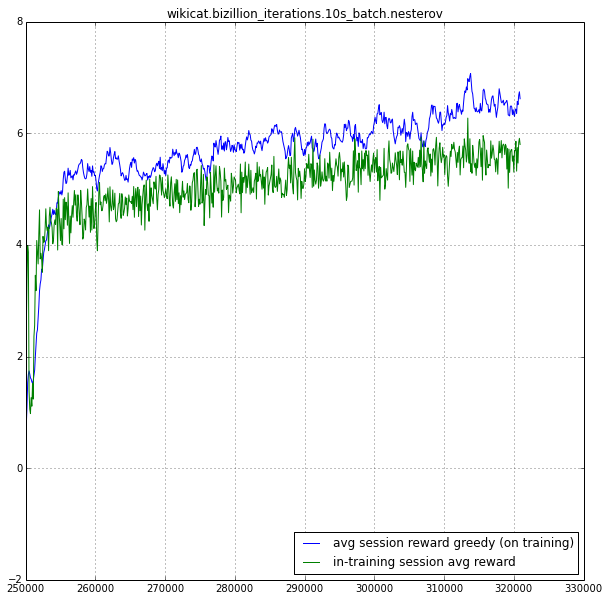

epoch 321000,loss 0.58953, greed 0.95000, rewards: ( train 5.70039, det_train 6.62137) 
rec 0.588 reg 0.001
epoch 321100,loss 0.48936, greed 0.95000, rewards: ( train 5.77217, det_train 6.60923) 
rec 0.488 reg 0.001
epoch 321200,loss 0.43470, greed 0.95000, rewards: ( train 5.52792, det_train 6.62831) 
rec 0.433 reg 0.001
epoch 321300,loss 0.66419, greed 0.95000, rewards: ( train 5.89042, det_train 6.61548) 
rec 0.663 reg 0.001
epoch 321400,loss 0.58833, greed 0.95000, rewards: ( train 6.25231, det_train 6.60393) 
rec 0.587 reg 0.001
epoch 321500,loss 0.77439, greed 0.95000, rewards: ( train 5.50730, det_train 6.86354) 
rec 0.773 reg 0.001
epoch 321600,loss 0.57214, greed 0.95000, rewards: ( train 6.16782, det_train 6.73718) 
rec 0.571 reg 0.001
epoch 321700,loss 0.71131, greed 0.95000, rewards: ( train 5.36700, det_train 6.72346) 
rec 0.710 reg 0.001
epoch 321800,loss 0.48043, greed 0.95000, rewards: ( train 5.60984, det_train 6.52112) 
rec 0.479 reg 0.001
epoch 321900,loss 0.58443, g

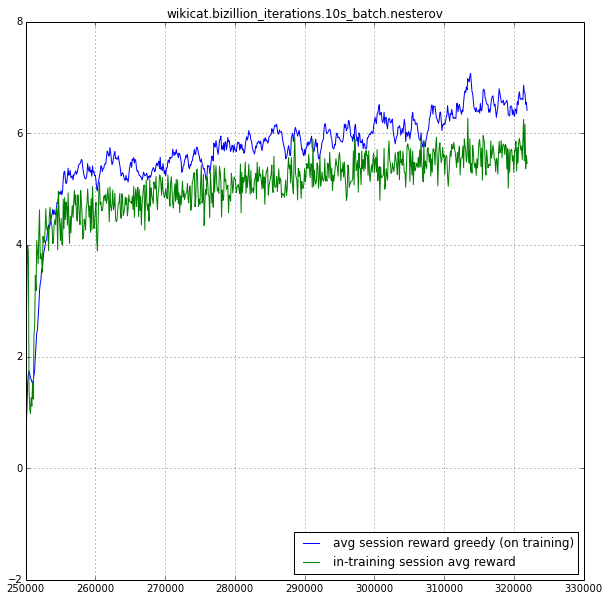

epoch 322000,loss 0.45015, greed 0.95000, rewards: ( train 5.93552, det_train 6.41311) 
rec 0.449 reg 0.001
epoch 322100,loss 0.60903, greed 0.95000, rewards: ( train 5.61390, det_train 6.60179) 
rec 0.608 reg 0.001
epoch 322200,loss 0.67564, greed 0.95000, rewards: ( train 5.53461, det_train 6.49162) 
rec 0.674 reg 0.001
epoch 322300,loss 0.66511, greed 0.95000, rewards: ( train 5.94777, det_train 6.50245) 
rec 0.664 reg 0.001
epoch 322400,loss 0.43261, greed 0.95000, rewards: ( train 5.93554, det_train 6.49221) 
rec 0.431 reg 0.001
epoch 322500,loss 0.48669, greed 0.95000, rewards: ( train 5.72974, det_train 6.63299) 
rec 0.485 reg 0.001
epoch 322600,loss 0.63763, greed 0.95000, rewards: ( train 6.09429, det_train 6.58969) 
rec 0.636 reg 0.001
epoch 322700,loss 0.68793, greed 0.95000, rewards: ( train 5.66218, det_train 6.54072) 
rec 0.687 reg 0.001
epoch 322800,loss 0.64074, greed 0.95000, rewards: ( train 5.72985, det_train 6.61665) 
rec 0.639 reg 0.001
epoch 322900,loss 0.55334, g

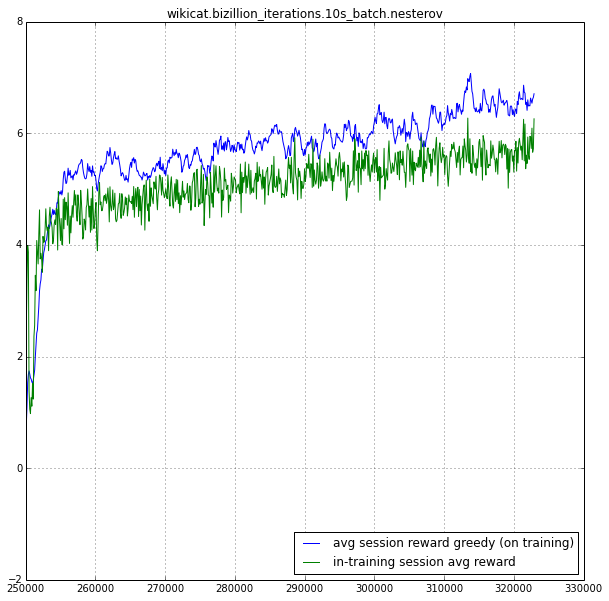

epoch 323000,loss 0.46543, greed 0.95000, rewards: ( train 6.02804, det_train 6.71048) 
rec 0.464 reg 0.001
epoch 323100,loss 0.44106, greed 0.95000, rewards: ( train 5.71673, det_train 6.82944) 
rec 0.440 reg 0.001
epoch 323200,loss 0.76413, greed 0.95000, rewards: ( train 5.60508, det_train 6.88649) 
rec 0.763 reg 0.001
epoch 323300,loss 0.52195, greed 0.95000, rewards: ( train 5.71990, det_train 6.64784) 
rec 0.521 reg 0.001
epoch 323400,loss 0.49967, greed 0.95000, rewards: ( train 5.80566, det_train 6.79306) 
rec 0.498 reg 0.001
epoch 323500,loss 0.67654, greed 0.95000, rewards: ( train 5.33222, det_train 6.79375) 
rec 0.675 reg 0.001
epoch 323600,loss 0.42809, greed 0.95000, rewards: ( train 5.98933, det_train 6.64438) 
rec 0.427 reg 0.001
epoch 323700,loss 0.64913, greed 0.95000, rewards: ( train 5.61245, det_train 6.70994) 
rec 0.648 reg 0.001
epoch 323800,loss 0.44790, greed 0.95000, rewards: ( train 6.32110, det_train 6.69895) 
rec 0.447 reg 0.001
epoch 323900,loss 0.61470, g

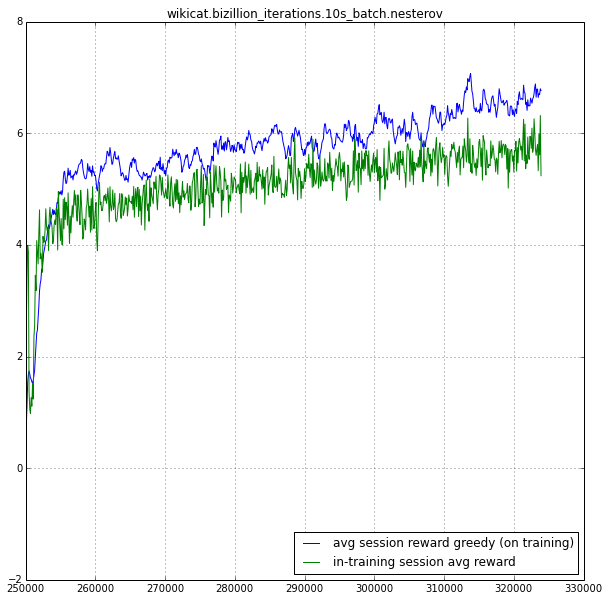

epoch 324000,loss 0.62101, greed 0.95000, rewards: ( train 6.16381, det_train 6.76915) 
rec 0.620 reg 0.001
epoch 324100,loss 0.71812, greed 0.95000, rewards: ( train 6.10995, det_train 6.80223) 
rec 0.717 reg 0.001
epoch 324200,loss 0.56817, greed 0.95000, rewards: ( train 5.75621, det_train 6.76201) 
rec 0.567 reg 0.001
epoch 324300,loss 0.45994, greed 0.95000, rewards: ( train 6.33761, det_train 6.60581) 
rec 0.459 reg 0.001
epoch 324400,loss 0.48528, greed 0.95000, rewards: ( train 5.96496, det_train 6.67523) 
rec 0.484 reg 0.001
epoch 324500,loss 0.53917, greed 0.95000, rewards: ( train 6.12384, det_train 6.69770) 
rec 0.538 reg 0.001
epoch 324600,loss 0.41424, greed 0.95000, rewards: ( train 5.88448, det_train 6.69793) 
rec 0.413 reg 0.001
epoch 324700,loss 0.46819, greed 0.95000, rewards: ( train 5.55350, det_train 6.82814) 
rec 0.467 reg 0.001
epoch 324800,loss 0.45791, greed 0.95000, rewards: ( train 5.57750, det_train 6.80533) 
rec 0.457 reg 0.001
epoch 324900,loss 0.51380, g

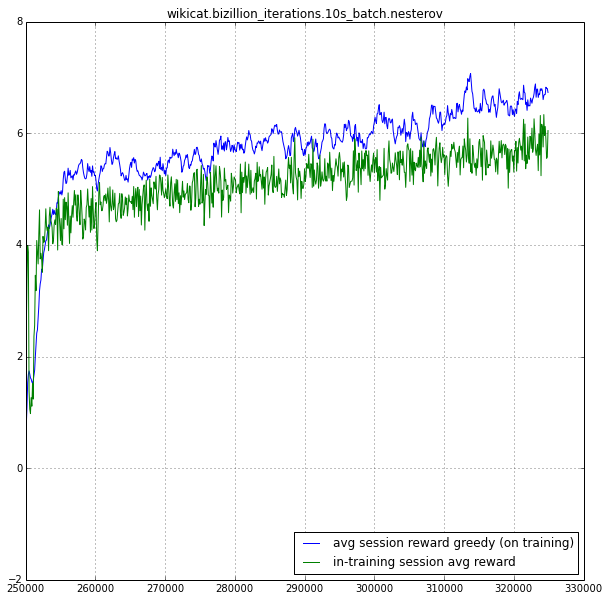

snapshot saved
epoch 325000,loss 0.54244, greed 0.95000, rewards: ( train 5.93471, det_train 6.73431) 
rec 0.541 reg 0.001
epoch 325100,loss 0.46238, greed 0.95000, rewards: ( train 6.05233, det_train 6.60088) 
rec 0.461 reg 0.001
epoch 325200,loss 0.49043, greed 0.95000, rewards: ( train 5.81092, det_train 6.65079) 
rec 0.489 reg 0.001
epoch 325300,loss 0.60886, greed 0.95000, rewards: ( train 5.64985, det_train 6.66572) 
rec 0.608 reg 0.001
epoch 325400,loss 0.49329, greed 0.95000, rewards: ( train 5.79134, det_train 6.63914) 
rec 0.492 reg 0.001
epoch 325500,loss 0.51711, greed 0.95000, rewards: ( train 6.06887, det_train 6.67523) 
rec 0.516 reg 0.001
epoch 325600,loss 0.86855, greed 0.95000, rewards: ( train 5.73866, det_train 6.65771) 
rec 0.867 reg 0.001
epoch 325700,loss 0.56239, greed 0.95000, rewards: ( train 5.77647, det_train 6.57194) 
rec 0.561 reg 0.001
epoch 325800,loss 0.45090, greed 0.95000, rewards: ( train 5.97522, det_train 6.43474) 
rec 0.450 reg 0.001
epoch 325900,

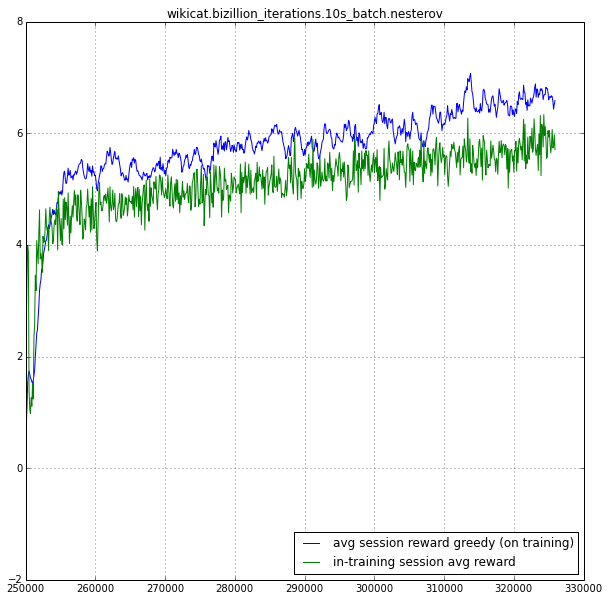

epoch 326000,loss 0.73039, greed 0.95000, rewards: ( train 5.60587, det_train 6.58914) 
rec 0.729 reg 0.001
epoch 326100,loss 0.77469, greed 0.95000, rewards: ( train 5.69309, det_train 6.44023) 
rec 0.773 reg 0.001
epoch 326200,loss 0.63189, greed 0.95000, rewards: ( train 6.01958, det_train 6.41620) 
rec 0.631 reg 0.001
epoch 326300,loss 0.46979, greed 0.95000, rewards: ( train 5.91920, det_train 6.45458) 
rec 0.468 reg 0.001
epoch 326400,loss 0.58039, greed 0.95000, rewards: ( train 6.13400, det_train 6.43913) 
rec 0.579 reg 0.001
epoch 326500,loss 0.73062, greed 0.95000, rewards: ( train 6.04682, det_train 6.47521) 
rec 0.729 reg 0.001
epoch 326600,loss 0.51259, greed 0.95000, rewards: ( train 5.79747, det_train 6.40769) 
rec 0.511 reg 0.001
epoch 326700,loss 0.53476, greed 0.95000, rewards: ( train 6.15519, det_train 6.44692) 
rec 0.533 reg 0.001
epoch 326800,loss 0.63742, greed 0.95000, rewards: ( train 5.80535, det_train 6.52223) 
rec 0.636 reg 0.001
epoch 326900,loss 0.61621, g

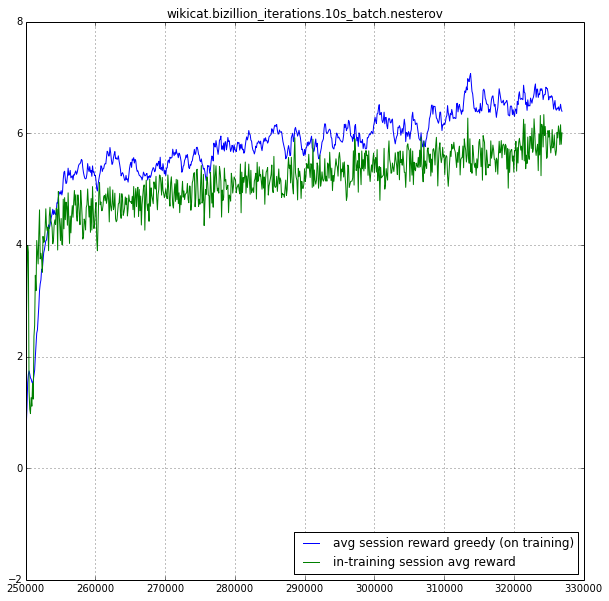

epoch 327000,loss 0.56185, greed 0.95000, rewards: ( train 5.84927, det_train 6.39701) 
rec 0.561 reg 0.001
epoch 327100,loss 0.54433, greed 0.95000, rewards: ( train 6.25698, det_train 6.38731) 
rec 0.543 reg 0.001
epoch 327200,loss 0.62351, greed 0.95000, rewards: ( train 5.49625, det_train 6.41858) 
rec 0.622 reg 0.001
epoch 327300,loss 0.63102, greed 0.95000, rewards: ( train 5.91628, det_train 6.50672) 
rec 0.630 reg 0.001
epoch 327400,loss 0.53912, greed 0.95000, rewards: ( train 6.07068, det_train 6.58605) 
rec 0.538 reg 0.001
epoch 327500,loss 0.51660, greed 0.95000, rewards: ( train 6.00924, det_train 6.52744) 
rec 0.515 reg 0.001
epoch 327600,loss 0.63353, greed 0.95000, rewards: ( train 5.47618, det_train 6.53470) 
rec 0.632 reg 0.001
epoch 327700,loss 0.55422, greed 0.95000, rewards: ( train 6.22204, det_train 6.37123) 
rec 0.553 reg 0.001
epoch 327800,loss 0.67160, greed 0.95000, rewards: ( train 5.70624, det_train 6.45410) 
rec 0.670 reg 0.001
epoch 327900,loss 0.52290, g

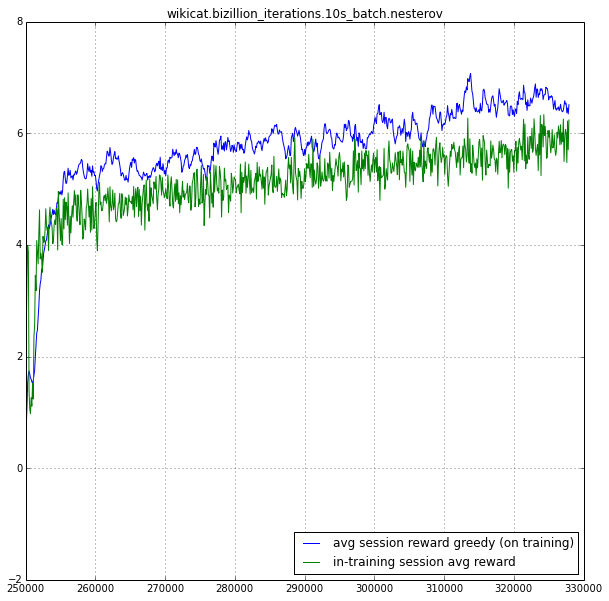

epoch 328000,loss 0.59139, greed 0.95000, rewards: ( train 5.90571, det_train 6.51382) 
rec 0.590 reg 0.001
epoch 328100,loss 0.62659, greed 0.95000, rewards: ( train 6.02449, det_train 6.62244) 
rec 0.625 reg 0.001
epoch 328200,loss 0.70025, greed 0.95000, rewards: ( train 6.31170, det_train 6.59020) 
rec 0.699 reg 0.001
epoch 328300,loss 0.53287, greed 0.95000, rewards: ( train 5.95162, det_train 6.64118) 
rec 0.532 reg 0.001
epoch 328400,loss 0.43824, greed 0.95000, rewards: ( train 5.89720, det_train 6.73706) 
rec 0.437 reg 0.001
epoch 328500,loss 0.70765, greed 0.95000, rewards: ( train 5.59565, det_train 6.81335) 
rec 0.706 reg 0.001
epoch 328600,loss 0.69141, greed 0.95000, rewards: ( train 5.67672, det_train 6.75202) 
rec 0.690 reg 0.001
epoch 328700,loss 0.45735, greed 0.95000, rewards: ( train 5.86304, det_train 6.51682) 
rec 0.456 reg 0.001
epoch 328800,loss 0.50074, greed 0.95000, rewards: ( train 5.92414, det_train 6.56514) 
rec 0.499 reg 0.001
epoch 328900,loss 0.62175, g

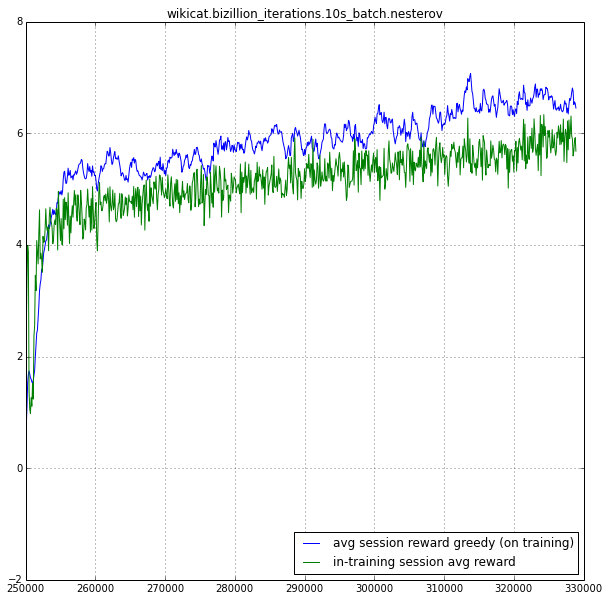

epoch 329000,loss 0.54568, greed 0.95000, rewards: ( train 5.97057, det_train 6.45476) 
rec 0.544 reg 0.001
epoch 329100,loss 0.46078, greed 0.95000, rewards: ( train 6.09933, det_train 6.57928) 
rec 0.459 reg 0.001
epoch 329200,loss 0.42999, greed 0.95000, rewards: ( train 5.42177, det_train 6.71136) 
rec 0.429 reg 0.001
epoch 329300,loss 0.84833, greed 0.95000, rewards: ( train 5.44070, det_train 6.82022) 
rec 0.847 reg 0.001
epoch 329400,loss 0.64347, greed 0.95000, rewards: ( train 6.11740, det_train 6.71820) 
rec 0.642 reg 0.001
epoch 329500,loss 0.62910, greed 0.95000, rewards: ( train 6.42536, det_train 6.92638) 
rec 0.628 reg 0.001
epoch 329600,loss 0.68189, greed 0.95000, rewards: ( train 5.48980, det_train 7.08374) 
rec 0.681 reg 0.001
epoch 329700,loss 0.49071, greed 0.95000, rewards: ( train 6.09536, det_train 6.92537) 
rec 0.489 reg 0.001
epoch 329800,loss 0.50175, greed 0.95000, rewards: ( train 6.00927, det_train 6.88283) 
rec 0.500 reg 0.001
epoch 329900,loss 0.59381, g

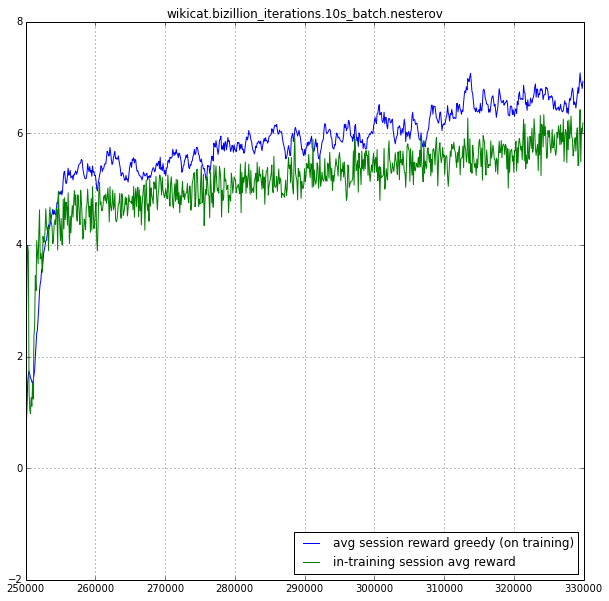

epoch 330000,loss 0.52829, greed 0.95000, rewards: ( train 5.94782, det_train 6.93409) 
rec 0.527 reg 0.001
epoch 330100,loss 0.62183, greed 0.95000, rewards: ( train 5.76415, det_train 7.03068) 
rec 0.620 reg 0.001
epoch 330200,loss 0.44488, greed 0.95000, rewards: ( train 5.65418, det_train 6.88761) 
rec 0.444 reg 0.001
epoch 330300,loss 0.55602, greed 0.95000, rewards: ( train 5.60220, det_train 6.92885) 
rec 0.555 reg 0.001
epoch 330400,loss 0.49793, greed 0.95000, rewards: ( train 6.04614, det_train 6.92597) 
rec 0.497 reg 0.001
epoch 330500,loss 0.42425, greed 0.95000, rewards: ( train 6.00049, det_train 7.16337) 
rec 0.423 reg 0.001
epoch 330600,loss 0.59550, greed 0.95000, rewards: ( train 5.86997, det_train 7.17703) 
rec 0.594 reg 0.001
epoch 330700,loss 0.56808, greed 0.95000, rewards: ( train 5.79488, det_train 7.10933) 
rec 0.567 reg 0.001
epoch 330800,loss 0.51812, greed 0.95000, rewards: ( train 5.99508, det_train 6.97840) 
rec 0.517 reg 0.001
epoch 330900,loss 0.53890, g

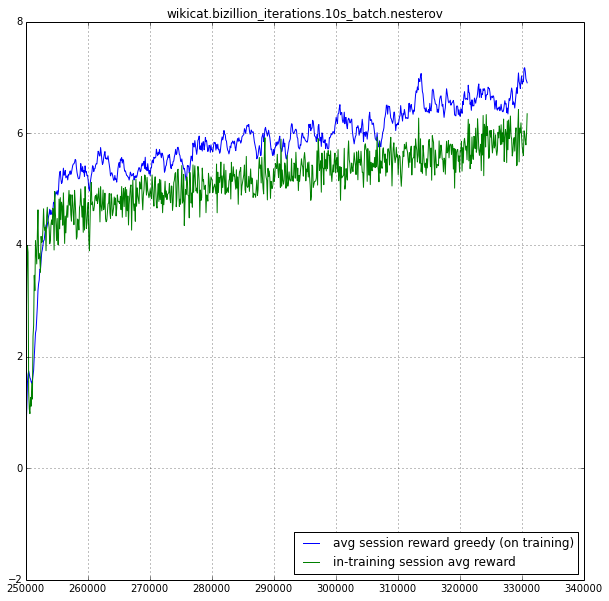

epoch 331000,loss 0.64515, greed 0.95000, rewards: ( train 5.98491, det_train 6.90650) 
rec 0.644 reg 0.001
epoch 331100,loss 0.53862, greed 0.95000, rewards: ( train 5.81309, det_train 7.09585) 
rec 0.537 reg 0.001
epoch 331200,loss 0.56433, greed 0.95000, rewards: ( train 5.64986, det_train 7.05627) 
rec 0.563 reg 0.001
epoch 331300,loss 0.52104, greed 0.95000, rewards: ( train 5.87084, det_train 7.03064) 
rec 0.520 reg 0.001
epoch 331400,loss 0.54831, greed 0.95000, rewards: ( train 5.66969, det_train 6.97758) 
rec 0.547 reg 0.001
epoch 331500,loss 0.49929, greed 0.95000, rewards: ( train 5.89680, det_train 6.91982) 
rec 0.498 reg 0.001
epoch 331600,loss 0.57910, greed 0.95000, rewards: ( train 6.12072, det_train 6.81784) 
rec 0.578 reg 0.001
epoch 331700,loss 0.59100, greed 0.95000, rewards: ( train 5.99236, det_train 6.82605) 
rec 0.590 reg 0.001
epoch 331800,loss 0.54819, greed 0.95000, rewards: ( train 6.09579, det_train 6.68345) 
rec 0.547 reg 0.001
epoch 331900,loss 0.58616, g

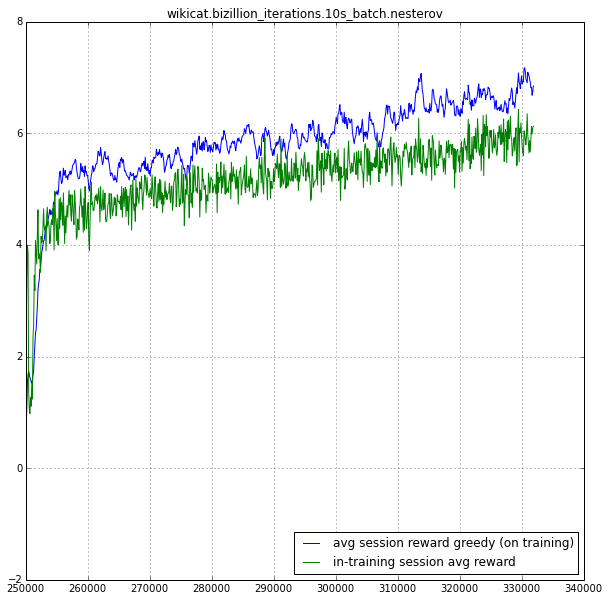

epoch 332000,loss 0.58034, greed 0.95000, rewards: ( train 6.10938, det_train 6.85059) 
rec 0.579 reg 0.001
epoch 332100,loss 0.46906, greed 0.95000, rewards: ( train 5.94421, det_train 6.99553) 
rec 0.468 reg 0.001
epoch 332200,loss 0.55979, greed 0.95000, rewards: ( train 6.22915, det_train 6.88598) 
rec 0.558 reg 0.001
epoch 332300,loss 0.52056, greed 0.95000, rewards: ( train 5.66694, det_train 6.89738) 
rec 0.519 reg 0.001
epoch 332400,loss 0.63293, greed 0.95000, rewards: ( train 6.26904, det_train 6.92764) 
rec 0.632 reg 0.001
epoch 332500,loss 0.51846, greed 0.95000, rewards: ( train 5.94014, det_train 6.90488) 
rec 0.517 reg 0.001
epoch 332600,loss 0.61789, greed 0.95000, rewards: ( train 6.19080, det_train 6.85439) 
rec 0.617 reg 0.001
epoch 332700,loss 0.51009, greed 0.95000, rewards: ( train 6.35315, det_train 6.78895) 
rec 0.509 reg 0.001
epoch 332800,loss 0.49837, greed 0.95000, rewards: ( train 5.96318, det_train 6.80006) 
rec 0.497 reg 0.001
epoch 332900,loss 0.55276, g

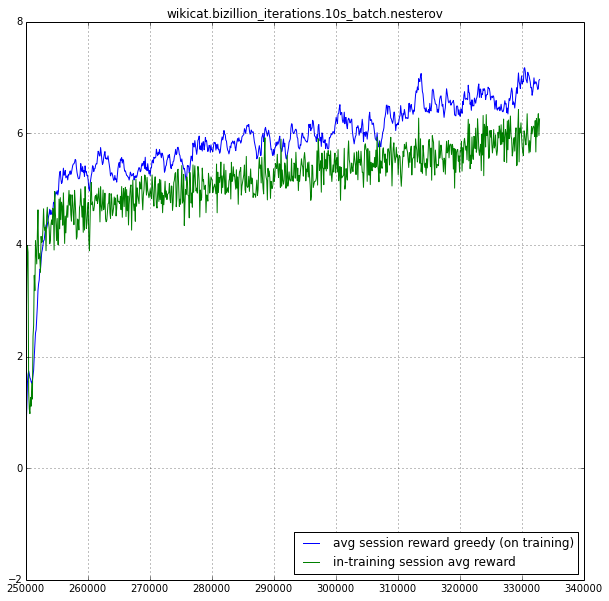

epoch 333000,loss 0.68952, greed 0.95000, rewards: ( train 5.38482, det_train 6.96505) 
rec 0.688 reg 0.001
epoch 333100,loss 0.50662, greed 0.95000, rewards: ( train 6.17292, det_train 6.76854) 
rec 0.505 reg 0.001
epoch 333200,loss 0.51995, greed 0.95000, rewards: ( train 6.17225, det_train 6.82169) 
rec 0.519 reg 0.001
epoch 333300,loss 0.52388, greed 0.95000, rewards: ( train 6.14982, det_train 7.03952) 
rec 0.523 reg 0.001
epoch 333400,loss 0.56762, greed 0.95000, rewards: ( train 6.11695, det_train 7.11557) 
rec 0.566 reg 0.001
epoch 333500,loss 0.47035, greed 0.95000, rewards: ( train 6.25069, det_train 7.03401) 
rec 0.469 reg 0.001
epoch 333600,loss 0.54163, greed 0.95000, rewards: ( train 6.10852, det_train 6.95061) 
rec 0.540 reg 0.001
epoch 333700,loss 0.49138, greed 0.95000, rewards: ( train 6.29765, det_train 6.97555) 
rec 0.490 reg 0.001
epoch 333800,loss 0.66453, greed 0.95000, rewards: ( train 6.17189, det_train 6.97799) 
rec 0.663 reg 0.001
epoch 333900,loss 0.49997, g

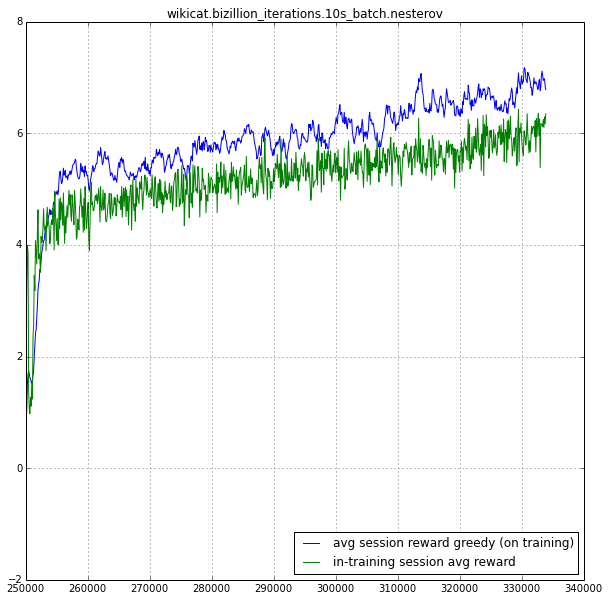

epoch 334000,loss 0.48950, greed 0.95000, rewards: ( train 6.06792, det_train 6.78517) 
rec 0.488 reg 0.001
epoch 334100,loss 0.67001, greed 0.95000, rewards: ( train 6.10641, det_train 6.74666) 
rec 0.669 reg 0.001
epoch 334200,loss 0.47863, greed 0.95000, rewards: ( train 5.73103, det_train 6.79199) 
rec 0.477 reg 0.001
epoch 334300,loss 0.57543, greed 0.95000, rewards: ( train 5.89235, det_train 6.82279) 
rec 0.574 reg 0.001
epoch 334400,loss 0.55444, greed 0.95000, rewards: ( train 5.89719, det_train 7.01051) 
rec 0.553 reg 0.001
epoch 334500,loss 0.51601, greed 0.95000, rewards: ( train 6.02681, det_train 6.91946) 
rec 0.515 reg 0.001
epoch 334600,loss 0.51473, greed 0.95000, rewards: ( train 5.97357, det_train 6.97752) 
rec 0.513 reg 0.001
epoch 334700,loss 0.59835, greed 0.95000, rewards: ( train 5.93805, det_train 6.91976) 
rec 0.597 reg 0.001
epoch 334800,loss 0.49259, greed 0.95000, rewards: ( train 5.65057, det_train 6.90779) 
rec 0.491 reg 0.001
epoch 334900,loss 0.52969, g

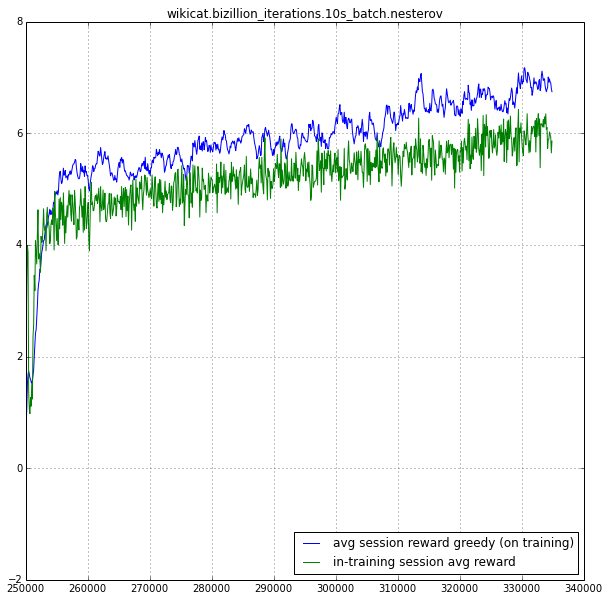

epoch 335000,loss 0.76037, greed 0.95000, rewards: ( train 6.07419, det_train 6.74631) 
rec 0.759 reg 0.001
epoch 335100,loss 0.54052, greed 0.95000, rewards: ( train 6.09338, det_train 6.70168) 
rec 0.539 reg 0.001
epoch 335200,loss 0.44194, greed 0.95000, rewards: ( train 5.70653, det_train 6.73151) 
rec 0.441 reg 0.001
epoch 335300,loss 0.58118, greed 0.95000, rewards: ( train 5.84202, det_train 6.79836) 
rec 0.580 reg 0.001
epoch 335400,loss 0.36826, greed 0.95000, rewards: ( train 5.93123, det_train 6.79852) 
rec 0.367 reg 0.001
epoch 335500,loss 0.66473, greed 0.95000, rewards: ( train 6.33559, det_train 6.80867) 
rec 0.663 reg 0.001
epoch 335600,loss 0.47435, greed 0.95000, rewards: ( train 5.84396, det_train 6.94780) 
rec 0.473 reg 0.001
epoch 335700,loss 0.61044, greed 0.95000, rewards: ( train 6.09731, det_train 6.91302) 
rec 0.609 reg 0.001
epoch 335800,loss 0.55909, greed 0.95000, rewards: ( train 5.96484, det_train 6.98172) 
rec 0.558 reg 0.001
epoch 335900,loss 0.70716, g

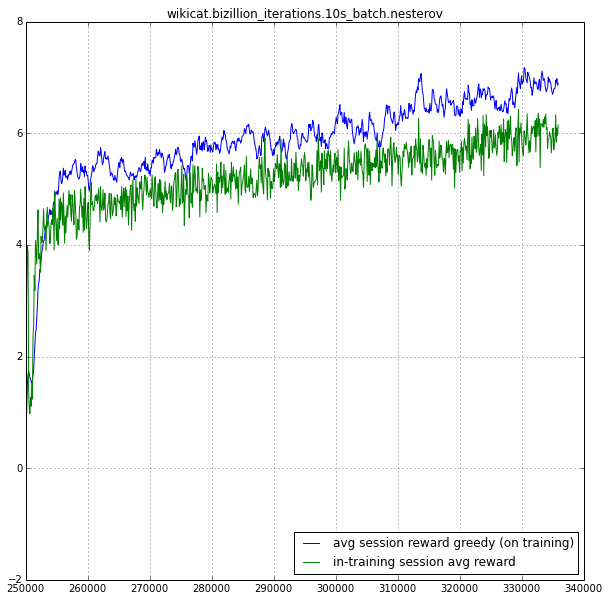

epoch 336000,loss 0.49319, greed 0.95000, rewards: ( train 5.68964, det_train 6.89719) 
rec 0.492 reg 0.001
epoch 336100,loss 0.59292, greed 0.95000, rewards: ( train 5.81275, det_train 6.83747) 
rec 0.592 reg 0.001
epoch 336200,loss 0.53213, greed 0.95000, rewards: ( train 5.97072, det_train 6.86373) 
rec 0.531 reg 0.001
epoch 336300,loss 0.46406, greed 0.95000, rewards: ( train 5.88785, det_train 6.79735) 
rec 0.463 reg 0.001
epoch 336400,loss 0.62377, greed 0.95000, rewards: ( train 5.91293, det_train 6.85762) 
rec 0.622 reg 0.001
epoch 336500,loss 0.70215, greed 0.95000, rewards: ( train 5.84680, det_train 6.88186) 
rec 0.701 reg 0.001
epoch 336600,loss 0.49004, greed 0.95000, rewards: ( train 6.01226, det_train 6.78367) 
rec 0.489 reg 0.001
epoch 336700,loss 0.44317, greed 0.95000, rewards: ( train 6.42242, det_train 6.89530) 
rec 0.442 reg 0.001
epoch 336800,loss 0.56753, greed 0.95000, rewards: ( train 6.29879, det_train 7.03577) 
rec 0.566 reg 0.001
epoch 336900,loss 0.41746, g

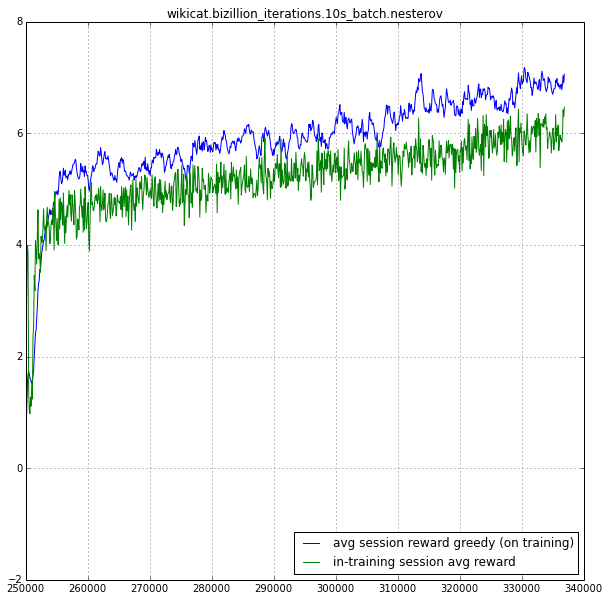

epoch 337000,loss 0.63888, greed 0.95000, rewards: ( train 6.19476, det_train 7.06198) 
rec 0.638 reg 0.001
epoch 337100,loss 0.53093, greed 0.95000, rewards: ( train 5.89895, det_train 6.97578) 
rec 0.530 reg 0.001
epoch 337200,loss 0.68117, greed 0.95000, rewards: ( train 6.17022, det_train 7.04820) 
rec 0.680 reg 0.001
epoch 337300,loss 0.65028, greed 0.95000, rewards: ( train 6.06169, det_train 6.91338) 
rec 0.649 reg 0.001
epoch 337400,loss 0.45281, greed 0.95000, rewards: ( train 5.76582, det_train 6.85204) 
rec 0.451 reg 0.001
epoch 337500,loss 0.49381, greed 0.95000, rewards: ( train 5.85273, det_train 6.96684) 
rec 0.492 reg 0.001
epoch 337600,loss 0.60857, greed 0.95000, rewards: ( train 6.24916, det_train 6.91015) 
rec 0.607 reg 0.001
epoch 337700,loss 0.69487, greed 0.95000, rewards: ( train 6.04671, det_train 6.88914) 
rec 0.694 reg 0.001
epoch 337800,loss 0.58688, greed 0.95000, rewards: ( train 5.78081, det_train 6.82023) 
rec 0.586 reg 0.001
epoch 337900,loss 0.86750, g

In [ ]:
n_epochs = 10**6
batch_size=10
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/100000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1)
        
        plot_scores(experiment_setup_name)

    if epoch_counter% 25000 ==0:
        save(resolver,"/root/agentnet_snapshots/{}.epoch{}.pcl".format(experiment_setup_name,epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy
        
        score_log
        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


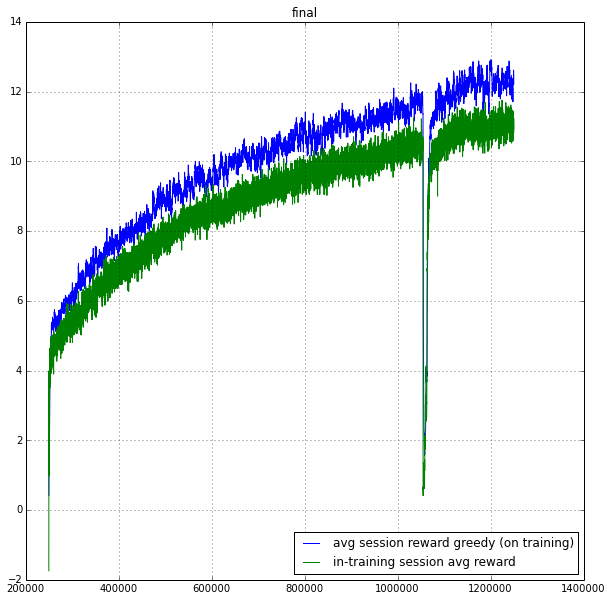

In [40]:
plot_scores("final")

In [ ]:
#before epoch 250k, sgd mommentum = 0.5, after - 0.9

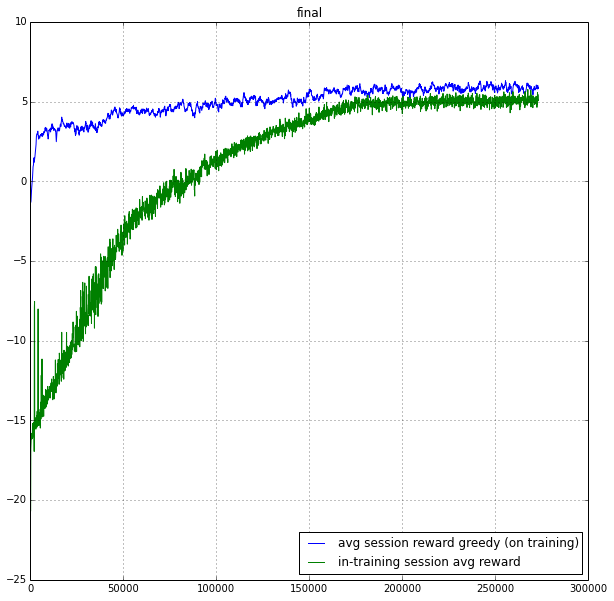

In [31]:
plot_scores("final")

In [41]:
load_random_batch(env,train_attrs,train_cats,10)
print_session(10)

#25: last_activity:still_active (8.306) -> -1.0 | #239: Died:is_known (9.096) -> 1.0 | #149: Labels:is_known (8.975) -> -1.0 | #260: decades_active:1990 (8.279) -> 1.0 | #91: decades_active:1980 (8.034) -> 1.0 | #221: decades_active:1970 (7.299) -> 1.0 | #43: decades_active:1960 (6.573) -> 1.0 | #45: decades_active:1950 (5.655) -> 1.0 | #166: decades_active:2000 (4.122) -> 1.0 | #128: decades_active:1930 (2.377) -> -1.0 | #2: Cause of death:is_known (5.295) -> 1.0 | #261: Spouse(s):is_known (4.521) -> 1.0 | #268: Occupation:actor (3.639) -> 1.0 | #165: last_activity:2004 (2.787) -> 1.0 | #250: Native name:is_known (1.892) -> 1.0 | #58: Other names:is_known (0.913) -> 1.0 | #393: <end_session_action> (0.000) -> 0.0 | <end>
true: category:List_of_Asian-American_hip_hop_musicians

#25: last_activity:still_active (8.306) -> 1.0 | #26: decades_active:2010 (7.859) -> 1.0 | #166: decades_active:2000 (7.243) -> 1.0 | #149: Labels:is_known (6.632) -> 1.0 | #260: decades_active:1990 (5.999) -> 1

#25: last_activity:still_active (8.306) -> -1.0 | #239: Died:is_known (9.096) -> 1.0 | #149: Labels:is_known (8.975) -> -1.0 | #260: decades_active:1990 (8.279) -> 1.0 | #91: decades_active:1980 (8.034) -> 1.0 | #221: decades_active:1970 (7.299) -> 1.0 | #43: decades_active:1960 (6.573) -> 1.0 | #45: decades_active:1950 (5.655) -> 1.0 | #166: decades_active:2000 (4.122) -> 1.0 | #14: Genres:urban (1.462) -> -1.0 | #128: decades_active:1930 (2.588) -> -1.0 | #2: Cause of death:is_known (5.388) -> 1.0 | #261: Spouse(s):is_known (4.504) -> 1.0 | #268: Occupation:actor (3.559) -> 1.0 | #165: last_activity:2004 (2.772) -> 1.0 | #250: Native name:is_known (1.894) -> 1.0 | #58: Other names:is_known (0.923) -> 1.0 | #393: <end_session_action> (-0.000) -> 0.0 | <end>
true: category:List_of_Asian-American_hip_hop_musicians


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


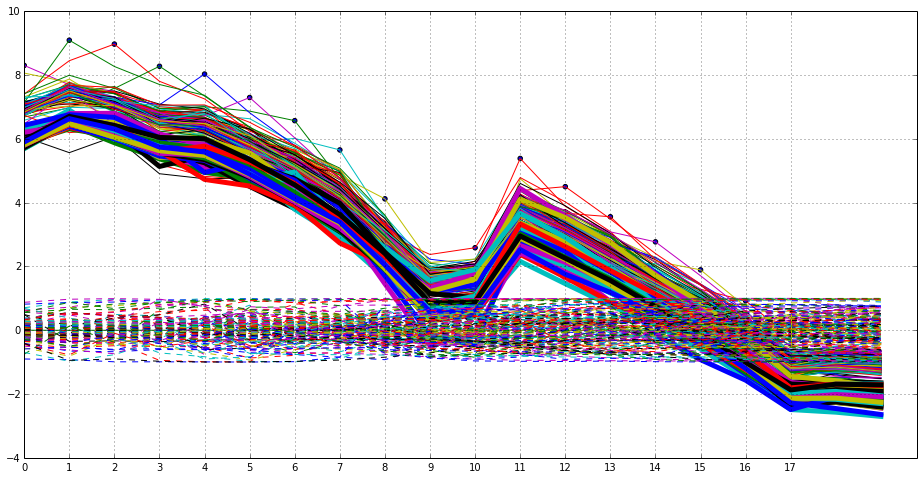


#25: last_activity:still_active (8.306) -> 1.0 | #26: decades_active:2010 (7.859) -> 1.0 | #166: decades_active:2000 (7.243) -> 1.0 | #215: Origin:ontario (5.042) -> -1.0 | #149: Labels:is_known (6.546) -> 1.0 | #260: decades_active:1990 (5.968) -> 1.0 | #247: Website:is_known (5.194) -> 1.0 | #1: Birth name:is_known (4.334) -> -1.0 | #3: Instruments:guitar (4.800) -> -1.0 | #108: Genres:r&b (7.535) -> 1.0 | #295: first_activity:1998 (6.903) -> 1.0 | #356: category:List_of_R%26B_musicians (6.183) -> 2.0 | #7: Occupation:actress (4.386) -> 1.0 | #246: Occupation:songwriter (3.645) -> -1.0 | #80: Genres:jazz (4.583) -> 1.0 | #55: Origin:united (3.676) -> 1.0 | #191: Occupation:singer-songwriter (2.763) -> 1.0 | #77: Genres:soul (1.920) -> 1.0 | #146: Origin:states (1.011) -> 1.0 | #393: <end_session_action> (-0.000) -> 0.0 | <end>
true: category:List_of_soul_musicians category:List_of_smooth_jazz_musicians category:List_of_R%26B_musicians


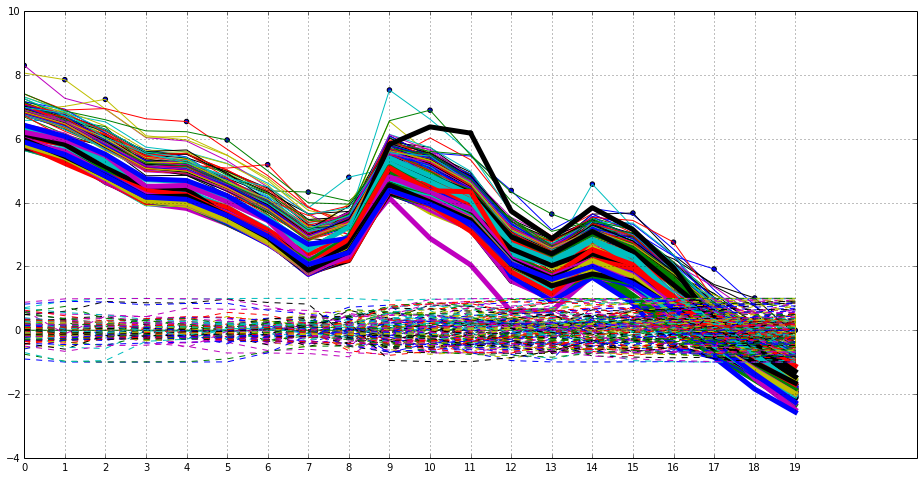


#25: last_activity:still_active (8.306) -> 1.0 | #26: decades_active:2010 (7.859) -> 1.0 | #166: decades_active:2000 (7.243) -> 1.0 | #149: Labels:is_known (6.632) -> 1.0 | #260: decades_active:1990 (5.999) -> 1.0 | #247: Website:is_known (5.232) -> 1.0 | #1: Birth name:is_known (4.352) -> 1.0 | #170: Genres:hip (4.013) -> 1.0 | #3: Instruments:guitar (0.865) -> -1.0 | #297: Genres:hop (0.967) -> 1.0 | #393: <end_session_action> (-0.000) -> 0.0 | <end>
true:


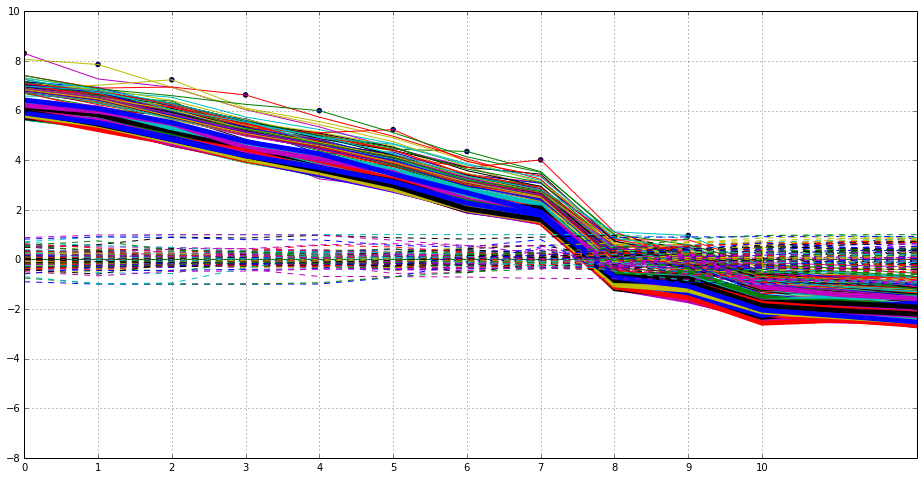

In [42]:
print_session(display=True,legend=False)